In [1]:
wDupRemoveDir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.with_pcr_rm.pickle'

woDupRemoveDir='/cellar/users/btsui/all_seq_snp/Homo_sapiens_all_merged_snp.TCGA.pickle'

import pandas as pd
from tqdm import tqdm
import numpy as np

from scipy import stats

wDupRemoved=pd.read_pickle(wDupRemoveDir).loc['TCGA']

ProcessedRunDigits=wDupRemoved.index.get_level_values('Run_digits').unique()

woDupRemoved=pd.read_pickle(woDupRemoveDir)

m=woDupRemoved.index.get_level_values('Run_digits').isin(ProcessedRunDigits)

In [2]:
woDupRemoved_inDf=woDupRemoved[m].loc['TCGA']

In [3]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)



/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index

In [17]:
statDict={}
nDict={}
for queryUUID in tqdm(ProcessedRunDigits):
    woDupRemoved_inDf_tmp=woDupRemoved_inDf['ReadDepth'].loc[queryUUID]
    wDupRemoved_inDf_tmp=wDupRemoved['ReadDepth'].loc[queryUUID]
    
    woDupRemoved_inDf_DepthS=(woDupRemoved_inDf_tmp.groupby(['Chr','Pos']).sum())
    wDupRemoved_inDf_DepthS=wDupRemoved_inDf_tmp.groupby(['Chr','Pos']).sum()

    #wDupRemoved_inDf_DepthS

    tmpI=woDupRemoved_inDf_tmp.index.to_frame().set_index(['Chr','Pos']).index

    woDupRemoved_inDf_DepthS_algned=woDupRemoved_inDf_DepthS[tmpI]

    tmpI=wDupRemoved_inDf_tmp.index.to_frame().set_index(['Chr','Pos']).index

    wDupRemoved_inDf_DepthS_algned=wDupRemoved_inDf_DepthS[tmpI]

    woDupRemoved_inDf_AllelicFreqS=woDupRemoved_inDf_tmp/woDupRemoved_inDf_DepthS_algned.values
    wDupRemoved_inDf_AllelicFreqS=wDupRemoved_inDf_tmp/wDupRemoved_inDf_DepthS_algned.values

    %time allelicDf=pd.DataFrame({'woDupRemoved':woDupRemoved_inDf_AllelicFreqS,'wDupRemoved':wDupRemoved_inDf_AllelicFreqS}).dropna()
    
    
    allelicDfResetDf=allelicDf.reset_index()
    
    ChrPosI=allelicDfResetDf.set_index(['Chr','Pos','base']).index

    ref_m=ChrPosI.isin(refI)

    allelicDfResetDf['is_ref']=ref_m

    bins = np.linspace(0, 1, 11)


    allelicDfResetDf['wDupRemoved_bin']=np.digitize(allelicDfResetDf['wDupRemoved'],bins)

    #(allelicDfResetDf['woDupRemoved']-allelicDfResetDf['wDupRemoved']).abs()

    allelicDfResetDf['abs_diff']=(allelicDfResetDf['woDupRemoved']-allelicDfResetDf['wDupRemoved']).abs()
    allelicDfResetDf['woDupRemoved_inDf_DepthS']=woDupRemoved_inDf_DepthS[ChrPosI].values
    allelicDfResetDf['woDupRemoved_inDf_DepthS_log10']=np.log10(allelicDfResetDf['woDupRemoved_inDf_DepthS'])
    binsize=1
    allelicDfResetDf['woDupRemoved_inDf_DepthS_bin']=(allelicDfResetDf['woDupRemoved_inDf_DepthS_log10']/binsize).astype(int)*binsize
    tmpDict={}
    for myBin in np.arange(0,4):
        abs_diff=allelicDfResetDf['abs_diff'][(allelicDfResetDf['woDupRemoved_inDf_DepthS_bin']==myBin)&(~allelicDfResetDf.is_ref)]#.sample(1000)
        tmpDict[myBin]=(abs_diff<=0.05).mean()
        tmpDict['bin_'+str(myBin)]=len(abs_diff)
    statDict[queryUUID]=tmpDict
    
    print (statDict[queryUUID])
    #mergedDf=np.log2(pd.DataFrame({'wo':woDupRemoved_inDf_tmp,
    #              'w':wDupRemoved_inDf_tmp})+1).dropna()
    #r,p=stats.pearsonr(mergedDf['wo'],mergedDf['w'])
    #print (r)
    #corrDict[queryUUID]=r
    










  0%|          | 0/452 [00:00<?, ?it/s]

CPU times: user 18.9 s, sys: 724 ms, total: 19.6 s
Wall time: 2.25 s











  0%|          | 1/452 [00:06<47:08,  6.27s/it]

{0: 0.9550580997949419, 'bin_0': 5852, 1: 0.9398329552485049, 'bin_1': 19396, 2: 0.9486007263405255, 'bin_2': 23405, 3: 0.7303030303030303, 'bin_3': 330}
CPU times: user 2 s, sys: 92 ms, total: 2.1 s
Wall time: 2.09 s











  0%|          | 2/452 [00:12<46:13,  6.16s/it]

{0: 0.9359078590785908, 'bin_0': 7380, 1: 0.9150632075950652, 'bin_1': 19697, 2: 0.9409551374819103, 'bin_2': 17275, 3: 0.7008928571428571, 'bin_3': 224}
CPU times: user 1.82 s, sys: 52 ms, total: 1.87 s
Wall time: 1.87 s











  1%|          | 3/452 [00:17<44:42,  5.97s/it]

{0: 0.9437980674423191, 'bin_0': 5071, 1: 0.9385759748475901, 'bin_1': 26081, 2: 0.9358772055659159, 'bin_2': 6971, 3: 0.7064220183486238, 'bin_3': 109}
CPU times: user 2.04 s, sys: 112 ms, total: 2.16 s
Wall time: 2.16 s











  1%|          | 4/452 [00:24<44:50,  6.01s/it]

{0: 0.9285560576716161, 'bin_0': 4647, 1: 0.9332702105595383, 'bin_1': 22179, 2: 0.9509891874026158, 'bin_2': 21179, 3: 0.68, 'bin_3': 250}
CPU times: user 1.98 s, sys: 72 ms, total: 2.05 s
Wall time: 2.05 s











  1%|          | 5/452 [00:29<44:38,  5.99s/it]

{0: 0.9062079569479147, 'bin_0': 5203, 1: 0.9265996421572804, 'bin_1': 23474, 2: 0.9526765375854214, 'bin_2': 17560, 3: 0.6578947368421053, 'bin_3': 228}
CPU times: user 2.02 s, sys: 96 ms, total: 2.11 s
Wall time: 2.11 s











  1%|▏         | 6/452 [00:35<44:31,  5.99s/it]

{0: 0.9619907959775013, 'bin_0': 5867, 1: 0.936305005422065, 'bin_1': 17521, 2: 0.9479375798503377, 'bin_2': 21916, 3: 0.6813186813186813, 'bin_3': 273}
CPU times: user 2.1 s, sys: 44 ms, total: 2.14 s
Wall time: 2.14 s











  2%|▏         | 7/452 [00:42<44:32,  6.00s/it]

{0: 0.8893113645965357, 'bin_0': 4734, 1: 0.9305719171575147, 'bin_1': 26315, 2: 0.9574760699746947, 'bin_2': 18178, 3: 0.6902173913043478, 'bin_3': 184}
CPU times: user 1.91 s, sys: 68 ms, total: 1.98 s
Wall time: 1.98 s











  2%|▏         | 8/452 [00:47<44:09,  5.97s/it]

{0: 0.9026512013256006, 'bin_0': 4828, 1: 0.9128959840359192, 'bin_1': 20045, 2: 0.9382237077712785, 'bin_2': 16754, 3: 0.7289719626168224, 'bin_3': 214}
CPU times: user 2 s, sys: 52 ms, total: 2.06 s
Wall time: 2.06 s











  2%|▏         | 9/452 [00:53<43:58,  5.96s/it]

{0: 0.8816308636562911, 'bin_0': 4562, 1: 0.9102345084640472, 'bin_1': 19317, 2: 0.9443171985544867, 'bin_2': 19647, 3: 0.748, 'bin_3': 250}
CPU times: user 2 s, sys: 92 ms, total: 2.09 s
Wall time: 2.09 s











  2%|▏         | 10/452 [00:59<43:55,  5.96s/it]

{0: 0.91015625, 'bin_0': 4608, 1: 0.9179995779700358, 'bin_1': 23695, 2: 0.9423693225770804, 'bin_2': 18098, 3: 0.6515837104072398, 'bin_3': 221}
CPU times: user 2.06 s, sys: 68 ms, total: 2.12 s
Wall time: 2.12 s











  2%|▏         | 11/452 [01:05<43:56,  5.98s/it]

{0: 0.9611352133044107, 'bin_0': 5532, 1: 0.9393379355329673, 'bin_1': 18397, 2: 0.9484843465297333, 'bin_2': 24148, 3: 0.6360153256704981, 'bin_3': 261}
CPU times: user 2 s, sys: 64 ms, total: 2.06 s
Wall time: 2.07 s











  3%|▎         | 12/452 [01:11<43:47,  5.97s/it]

{0: 0.9022525315147758, 'bin_0': 4839, 1: 0.9305911550510598, 'bin_1': 24579, 2: 0.952185214290032, 'bin_2': 16543, 3: 0.743801652892562, 'bin_3': 242}
CPU times: user 1.97 s, sys: 92 ms, total: 2.06 s
Wall time: 2.06 s











  3%|▎         | 13/452 [01:17<43:40,  5.97s/it]

{0: 0.9163416536661466, 'bin_0': 5128, 1: 0.9295168234731302, 'bin_1': 25084, 2: 0.9485525723713815, 'bin_2': 13334, 3: 0.72, 'bin_3': 150}
CPU times: user 1.97 s, sys: 64 ms, total: 2.03 s
Wall time: 2.03 s











  3%|▎         | 14/452 [01:23<43:35,  5.97s/it]

{0: 0.9025555786411802, 'bin_0': 4813, 1: 0.9287314192628793, 'bin_1': 24555, 2: 0.9567783370942544, 'bin_2': 17283, 3: 0.6542553191489362, 'bin_3': 188}
CPU times: user 1.94 s, sys: 56 ms, total: 1.99 s
Wall time: 1.99 s











  3%|▎         | 15/452 [01:29<43:26,  5.96s/it]

{0: 0.9117851354480204, 'bin_0': 4319, 1: 0.9295528589640681, 'bin_1': 21179, 2: 0.9409262185486812, 'bin_2': 16454, 3: 0.6789473684210526, 'bin_3': 190}
CPU times: user 1.95 s, sys: 84 ms, total: 2.04 s
Wall time: 2.04 s











  4%|▎         | 16/452 [01:35<43:21,  5.97s/it]

{0: 0.9065800162469537, 'bin_0': 4924, 1: 0.9227507672427717, 'bin_1': 24764, 2: 0.9477906764723758, 'bin_2': 16453, 3: 0.6855670103092784, 'bin_3': 194}
CPU times: user 19.6 s, sys: 832 ms, total: 20.4 s
Wall time: 2.46 s











  4%|▍         | 17/452 [01:42<43:30,  6.00s/it]

{0: 0.9673369507394404, 'bin_0': 9399, 1: 0.9377252195097193, 'bin_1': 19703, 2: 0.956102734356988, 'bin_2': 21687, 3: 0.7012448132780082, 'bin_3': 241}
CPU times: user 1.95 s, sys: 56 ms, total: 2.01 s
Wall time: 2.01 s











  4%|▍         | 18/452 [01:47<43:15,  5.98s/it]

{0: 0.8936526946107785, 'bin_0': 4175, 1: 0.9080664899041403, 'bin_1': 19612, 2: 0.9371234527330485, 'bin_2': 18258, 3: 0.7227272727272728, 'bin_3': 220}
CPU times: user 1.99 s, sys: 60 ms, total: 2.05 s
Wall time: 2.05 s











  4%|▍         | 19/452 [01:53<43:05,  5.97s/it]

{0: 0.8869216241737489, 'bin_0': 4236, 1: 0.8997400668399554, 'bin_1': 18851, 2: 0.9251490271060623, 'bin_2': 17782, 3: 0.6192660550458715, 'bin_3': 218}
CPU times: user 1.97 s, sys: 96 ms, total: 2.06 s
Wall time: 2.06 s











  4%|▍         | 20/452 [01:59<42:56,  5.96s/it]

{0: 0.9596440397350994, 'bin_0': 4832, 1: 0.941651279345819, 'bin_1': 18955, 2: 0.9484681632076803, 'bin_2': 21249, 3: 0.6576923076923077, 'bin_3': 260}
CPU times: user 1.98 s, sys: 64 ms, total: 2.05 s
Wall time: 2.05 s











  5%|▍         | 21/452 [02:05<42:48,  5.96s/it]

{0: 0.953672075149445, 'bin_0': 4684, 1: 0.9325091317785895, 'bin_1': 17795, 2: 0.9450834879406308, 'bin_2': 21560, 3: 0.6091954022988506, 'bin_3': 261}
CPU times: user 2.03 s, sys: 64 ms, total: 2.1 s
Wall time: 2.09 s











  5%|▍         | 22/452 [02:11<42:42,  5.96s/it]

{0: 0.9009717723276262, 'bin_0': 4322, 1: 0.9039560561504744, 'bin_1': 18023, 2: 0.9494859186410372, 'bin_2': 22370, 3: 0.7793594306049823, 'bin_3': 281}
CPU times: user 1.92 s, sys: 76 ms, total: 1.99 s
Wall time: 1.99 s











  5%|▌         | 23/452 [02:16<42:35,  5.96s/it]

{0: 0.9065108514190318, 'bin_0': 4792, 1: 0.9282596394794277, 'bin_1': 24742, 2: 0.94597184344365, 'bin_2': 13567, 3: 0.653179190751445, 'bin_3': 173}
CPU times: user 19.6 s, sys: 900 ms, total: 20.5 s
Wall time: 2.65 s











  5%|▌         | 24/452 [02:23<42:41,  5.98s/it]

{0: 0.897503285151117, 'bin_0': 5327, 1: 0.9237846433439346, 'bin_1': 26412, 2: 0.95844862131476, 'bin_2': 20962, 3: 0.71875, 'bin_3': 224}
CPU times: user 1.94 s, sys: 84 ms, total: 2.02 s
Wall time: 2.02 s











  6%|▌         | 25/452 [02:29<42:32,  5.98s/it]

{0: 0.9115101687581134, 'bin_0': 4622, 1: 0.930392196218538, 'bin_1': 24911, 2: 0.9557077338694477, 'bin_2': 15917, 3: 0.7644628099173554, 'bin_3': 242}
CPU times: user 1.95 s, sys: 60 ms, total: 2.01 s
Wall time: 2.01 s











  6%|▌         | 26/452 [02:35<42:25,  5.98s/it]

{0: 0.9076188499065808, 'bin_0': 4817, 1: 0.927203530507308, 'bin_1': 24699, 2: 0.9496138020645347, 'bin_2': 13853, 3: 0.7189542483660131, 'bin_3': 153}
CPU times: user 25.4 s, sys: 1 s, total: 26.4 s
Wall time: 2.94 s











  6%|▌         | 27/452 [02:42<42:45,  6.04s/it]

{0: 0.8977923139820114, 'bin_0': 4892, 1: 0.939549355489452, 'bin_1': 29247, 2: 0.9746549893842887, 'bin_2': 30144, 3: 0.7713178294573644, 'bin_3': 258}
CPU times: user 2.13 s, sys: 64 ms, total: 2.2 s
Wall time: 2.2 s











  6%|▌         | 28/452 [02:49<42:44,  6.05s/it]

{0: 0.9595456357114388, 'bin_0': 5018, 1: 0.936002572760894, 'bin_1': 18657, 2: 0.9455679957516484, 'bin_2': 22597, 3: 0.6923076923076923, 'bin_3': 286}
CPU times: user 2.04 s, sys: 92 ms, total: 2.14 s
Wall time: 2.14 s











  6%|▋         | 29/452 [02:55<42:42,  6.06s/it]

{0: 0.9125069073494197, 'bin_0': 5429, 1: 0.9292782196333221, 'bin_1': 26781, 2: 0.9492017416545718, 'bin_2': 10335, 3: 0.725925925925926, 'bin_3': 135}
CPU times: user 1.98 s, sys: 80 ms, total: 2.06 s
Wall time: 2.06 s











  7%|▋         | 30/452 [03:01<42:33,  6.05s/it]

{0: 0.913902205177373, 'bin_0': 5215, 1: 0.931516552341187, 'bin_1': 26824, 2: 0.949376880103137, 'bin_2': 11635, 3: 0.7235294117647059, 'bin_3': 170}
CPU times: user 23.9 s, sys: 956 ms, total: 24.8 s
Wall time: 2.45 s











  7%|▋         | 31/452 [03:08<42:35,  6.07s/it]

{0: 0.9117030201342282, 'bin_0': 4768, 1: 0.9395398424871891, 'bin_1': 29077, 2: 0.9708762114097312, 'bin_2': 20018, 3: 0.8277777777777777, 'bin_3': 180}
CPU times: user 2.01 s, sys: 48 ms, total: 2.06 s
Wall time: 2.06 s











  7%|▋         | 32/452 [03:13<42:25,  6.06s/it]

{0: 0.9094836453404649, 'bin_0': 4861, 1: 0.9245290728558002, 'bin_1': 24473, 2: 0.949978982765868, 'bin_2': 16653, 3: 0.7280334728033473, 'bin_3': 239}
CPU times: user 2.06 s, sys: 28 ms, total: 2.08 s
Wall time: 2.08 s











  7%|▋         | 33/452 [03:20<42:21,  6.07s/it]

{0: 0.958190664984682, 'bin_0': 5549, 1: 0.9413152462400471, 'bin_1': 20346, 2: 0.9512081568043205, 'bin_2': 21479, 3: 0.6696428571428571, 'bin_3': 224}
CPU times: user 24.6 s, sys: 1 s, total: 25.6 s
Wall time: 3.06 s











  8%|▊         | 34/452 [03:27<42:36,  6.12s/it]

{0: 0.939664297595645, 'bin_0': 13226, 1: 0.9173198482932996, 'bin_1': 19775, 2: 0.9427755568246716, 'bin_2': 17510, 3: 0.7739130434782608, 'bin_3': 230}
CPU times: user 2.5 s, sys: 48 ms, total: 2.55 s
Wall time: 2.55 s











  8%|▊         | 35/452 [03:34<42:39,  6.14s/it]

{0: 0.9188995215311004, 'bin_0': 4180, 1: 0.9148146407931212, 'bin_1': 21283, 2: 0.9347007115948095, 'bin_2': 19112, 3: 0.62, 'bin_3': 200}
CPU times: user 2.19 s, sys: 64 ms, total: 2.26 s
Wall time: 2.26 s











  8%|▊         | 36/452 [03:40<42:31,  6.13s/it]

{0: 0.9582978723404255, 'bin_0': 4700, 1: 0.9446578806594369, 'bin_1': 20563, 2: 0.950183297343444, 'bin_2': 19913, 3: 0.6367713004484304, 'bin_3': 223}
CPU times: user 2.14 s, sys: 56 ms, total: 2.19 s
Wall time: 2.19 s











  8%|▊         | 37/452 [03:47<42:26,  6.14s/it]

{0: 0.9276076803321225, 'bin_0': 7708, 1: 0.9044377605403409, 'bin_1': 18951, 2: 0.9514105058365758, 'bin_2': 20560, 3: 0.7094017094017094, 'bin_3': 234}
CPU times: user 19.2 s, sys: 636 ms, total: 19.8 s
Wall time: 2.3 s











  8%|▊         | 38/452 [03:53<42:22,  6.14s/it]

{0: 0.904019688269073, 'bin_0': 4876, 1: 0.9302498758894588, 'bin_1': 24172, 2: 0.9590006963788301, 'bin_2': 22976, 3: 0.6977777777777778, 'bin_3': 225}
CPU times: user 2 s, sys: 48 ms, total: 2.05 s
Wall time: 2.05 s











  9%|▊         | 39/452 [03:59<42:13,  6.14s/it]

{0: 0.8921706516643225, 'bin_0': 4266, 1: 0.9011086474501109, 'bin_1': 18040, 2: 0.944068197963533, 'bin_2': 21115, 3: 0.7213740458015268, 'bin_3': 262}
CPU times: user 1.8 s, sys: 48 ms, total: 1.85 s
Wall time: 1.85 s











  9%|▉         | 40/452 [04:04<42:03,  6.12s/it]

{0: 0.904603068712475, 'bin_0': 4497, 1: 0.9274334904374245, 'bin_1': 25673, 2: 0.9293710563810299, 'bin_2': 9826, 3: 0.6148148148148148, 'bin_3': 135}
CPU times: user 24.8 s, sys: 944 ms, total: 25.7 s
Wall time: 2.7 s











  9%|▉         | 41/452 [04:11<42:04,  6.14s/it]

{0: 0.9111776447105788, 'bin_0': 5010, 1: 0.9438729874776386, 'bin_1': 31304, 2: 0.9708493693556377, 'bin_2': 26243, 3: 0.7566371681415929, 'bin_3': 226}
CPU times: user 2.09 s, sys: 36 ms, total: 2.13 s
Wall time: 2.12 s











  9%|▉         | 42/452 [04:18<41:59,  6.15s/it]

{0: 0.9207985958753839, 'bin_0': 4558, 1: 0.9353528039263014, 'bin_1': 24858, 2: 0.9561569844279721, 'bin_2': 17403, 3: 0.6685393258426966, 'bin_3': 178}
CPU times: user 1.98 s, sys: 40 ms, total: 2.02 s
Wall time: 2.02 s











 10%|▉         | 43/452 [04:23<41:50,  6.14s/it]

{0: 0.9263772954924875, 'bin_0': 5990, 1: 0.9131231264572, 'bin_1': 18014, 2: 0.9415974507652928, 'bin_2': 19143, 3: 0.7333333333333333, 'bin_3': 255}
CPU times: user 1.97 s, sys: 72 ms, total: 2.04 s
Wall time: 2.04 s











 10%|▉         | 44/452 [04:30<41:44,  6.14s/it]

{0: 0.8924825174825175, 'bin_0': 4576, 1: 0.9089287534400163, 'bin_1': 19622, 2: 0.9409897486600406, 'bin_2': 19217, 3: 0.6860986547085202, 'bin_3': 223}
CPU times: user 1.93 s, sys: 60 ms, total: 1.99 s
Wall time: 1.99 s











 10%|▉         | 45/452 [04:35<41:34,  6.13s/it]

{0: 0.9023059757004711, 'bin_0': 4033, 1: 0.9114766940853898, 'bin_1': 20424, 2: 0.9424154025670946, 'bin_2': 17140, 3: 0.6519607843137255, 'bin_3': 204}
CPU times: user 1.99 s, sys: 32 ms, total: 2.02 s
Wall time: 2.02 s











 10%|█         | 46/452 [04:41<41:24,  6.12s/it]

{0: 0.9146928944199116, 'bin_0': 4982, 1: 0.9269028496881243, 'bin_1': 24529, 2: 0.9471733759627962, 'bin_2': 13762, 3: 0.7745098039215687, 'bin_3': 204}
CPU times: user 2 s, sys: 52 ms, total: 2.06 s
Wall time: 2.05 s











 10%|█         | 47/452 [04:47<41:16,  6.12s/it]

{0: 0.8861470803811385, 'bin_0': 4093, 1: 0.8895491301151679, 'bin_1': 16324, 2: 0.942519580512412, 'bin_2': 22599, 3: 0.732484076433121, 'bin_3': 314}
CPU times: user 18.9 s, sys: 784 ms, total: 19.7 s
Wall time: 2.29 s











 11%|█         | 48/452 [04:53<41:11,  6.12s/it]

{0: 0.9035087719298246, 'bin_0': 4560, 1: 0.9256816536636371, 'bin_1': 24866, 2: 0.9608781185728338, 'bin_2': 22366, 3: 0.6962616822429907, 'bin_3': 214}
CPU times: user 2.07 s, sys: 56 ms, total: 2.12 s
Wall time: 2.12 s











 11%|█         | 49/452 [04:59<41:04,  6.12s/it]

{0: 0.9661828941806397, 'bin_0': 7097, 1: 0.9402716328840416, 'bin_1': 19438, 2: 0.9546530517521467, 'bin_2': 21545, 3: 0.6981981981981982, 'bin_3': 222}
CPU times: user 2.03 s, sys: 56 ms, total: 2.08 s
Wall time: 2.08 s











 11%|█         | 50/452 [05:05<40:57,  6.11s/it]

{0: 0.9114626129827444, 'bin_0': 4868, 1: 0.9211290020595394, 'bin_1': 21364, 2: 0.9517389305959859, 'bin_2': 19581, 3: 0.6440677966101694, 'bin_3': 236}
CPU times: user 1.97 s, sys: 32 ms, total: 2 s
Wall time: 2 s











 11%|█▏        | 51/452 [05:11<40:48,  6.11s/it]

{0: 0.9052101576182137, 'bin_0': 4568, 1: 0.9195732044894056, 'bin_1': 19869, 2: 0.9490670427424605, 'bin_2': 18436, 3: 0.688212927756654, 'bin_3': 263}
CPU times: user 2.02 s, sys: 32 ms, total: 2.05 s
Wall time: 2.05 s











 12%|█▏        | 52/452 [05:17<40:40,  6.10s/it]

{0: 0.8979336255479023, 'bin_0': 4791, 1: 0.9089033840664548, 'bin_1': 17937, 2: 0.9457335845241924, 'bin_2': 21763, 3: 0.7272727272727273, 'bin_3': 275}
CPU times: user 22.5 s, sys: 980 ms, total: 23.4 s
Wall time: 2.34 s











 12%|█▏        | 53/452 [05:23<40:35,  6.10s/it]

{0: 0.9124687388352983, 'bin_0': 5598, 1: 0.9175272249342846, 'bin_1': 21304, 2: 0.9581969546036716, 'bin_2': 28108, 3: 0.7885906040268457, 'bin_3': 298}
CPU times: user 1.94 s, sys: 48 ms, total: 1.99 s
Wall time: 1.99 s











 12%|█▏        | 54/452 [05:29<40:26,  6.10s/it]

{0: 0.916953693073096, 'bin_0': 5226, 1: 0.9251508894536213, 'bin_1': 25184, 2: 0.9463102076889085, 'bin_2': 13578, 3: 0.6554054054054054, 'bin_3': 148}
CPU times: user 1.98 s, sys: 40 ms, total: 2.02 s
Wall time: 2.02 s











 12%|█▏        | 55/452 [05:35<40:19,  6.09s/it]

{0: 0.8919393806281573, 'bin_0': 4553, 1: 0.905588484335309, 'bin_1': 18896, 2: 0.9477057039428627, 'bin_2': 20442, 3: 0.720164609053498, 'bin_3': 243}
CPU times: user 1.91 s, sys: 40 ms, total: 1.95 s
Wall time: 1.94 s











 12%|█▏        | 56/452 [05:40<40:10,  6.09s/it]

{0: 0.9064007014467339, 'bin_0': 4562, 1: 0.9138599243333025, 'bin_1': 21674, 2: 0.9322709163346613, 'bin_2': 14558, 3: 0.6608695652173913, 'bin_3': 230}
CPU times: user 2 s, sys: 56 ms, total: 2.05 s
Wall time: 2.05 s











 13%|█▎        | 57/452 [05:46<40:02,  6.08s/it]

{0: 0.9013172583165885, 'bin_0': 4479, 1: 0.9207640608418819, 'bin_1': 22616, 2: 0.9535914416709119, 'bin_2': 19630, 3: 0.6727272727272727, 'bin_3': 220}
CPU times: user 28.7 s, sys: 1.09 s, total: 29.8 s
Wall time: 2.79 s











 13%|█▎        | 58/452 [05:53<40:04,  6.10s/it]

{0: 0.974869764534278, 'bin_0': 23995, 1: 0.9492188890075086, 'bin_1': 28101, 2: 0.9545354469396742, 'bin_2': 9084, 3: 0.6942148760330579, 'bin_3': 121}
CPU times: user 1.9 s, sys: 44 ms, total: 1.95 s
Wall time: 1.95 s











 13%|█▎        | 59/452 [05:59<39:55,  6.10s/it]

{0: 0.9194230769230769, 'bin_0': 5200, 1: 0.9300744210645612, 'bin_1': 26471, 2: 0.9418488068979346, 'bin_2': 9974, 3: 0.6928571428571428, 'bin_3': 140}
CPU times: user 18.7 s, sys: 872 ms, total: 19.5 s
Wall time: 2.24 s











 13%|█▎        | 60/452 [06:05<39:50,  6.10s/it]

{0: 0.9675534368752883, 'bin_0': 6503, 1: 0.9344000911109845, 'bin_1': 17561, 2: 0.9490474080638015, 'bin_2': 24827, 3: 0.717948717948718, 'bin_3': 312}
CPU times: user 1.96 s, sys: 32 ms, total: 2 s
Wall time: 2 s











 13%|█▎        | 61/452 [06:11<39:42,  6.09s/it]

{0: 0.9115467367917762, 'bin_0': 4183, 1: 0.9251384274640089, 'bin_1': 22575, 2: 0.9357846898424128, 'bin_2': 16943, 3: 0.519774011299435, 'bin_3': 177}
CPU times: user 2.18 s, sys: 52 ms, total: 2.24 s
Wall time: 2.24 s











 14%|█▎        | 62/452 [06:17<39:36,  6.09s/it]

{0: 0.9108604291086043, 'bin_0': 4521, 1: 0.9222180697000841, 'bin_1': 21406, 2: 0.9535432699117133, 'bin_2': 21181, 3: 0.6697674418604651, 'bin_3': 215}
CPU times: user 2.03 s, sys: 60 ms, total: 2.09 s
Wall time: 2.09 s











 14%|█▍        | 63/452 [06:23<39:28,  6.09s/it]

{0: 0.9166666666666666, 'bin_0': 4956, 1: 0.9405357772294678, 'bin_1': 28370, 2: 0.9601025143727921, 'bin_2': 14437, 3: 0.6708074534161491, 'bin_3': 161}
CPU times: user 2.1 s, sys: 40 ms, total: 2.14 s
Wall time: 2.14 s











 14%|█▍        | 64/452 [06:29<39:23,  6.09s/it]

{0: 0.9176822257990342, 'bin_0': 4349, 1: 0.9249846369941181, 'bin_1': 22782, 2: 0.9433027977222085, 'bin_2': 20195, 3: 0.5863874345549738, 'bin_3': 191}
CPU times: user 1.9 s, sys: 44 ms, total: 1.95 s
Wall time: 1.95 s











 14%|█▍        | 65/452 [06:35<39:14,  6.08s/it]

{0: 0.9040423861852434, 'bin_0': 5096, 1: 0.920062103982208, 'bin_1': 23831, 2: 0.9488368498338356, 'bin_2': 12939, 3: 0.686046511627907, 'bin_3': 172}
CPU times: user 1.92 s, sys: 40 ms, total: 1.96 s
Wall time: 1.96 s











 15%|█▍        | 66/452 [06:41<39:06,  6.08s/it]

{0: 0.921319199057715, 'bin_0': 4245, 1: 0.9256989152482582, 'bin_1': 22678, 2: 0.9282011559315975, 'bin_2': 16783, 3: 0.6, 'bin_3': 190}
CPU times: user 1.82 s, sys: 32 ms, total: 1.86 s
Wall time: 1.86 s











 15%|█▍        | 67/452 [06:46<38:57,  6.07s/it]

{0: 0.9098687963491158, 'bin_0': 5259, 1: 0.9255529446868822, 'bin_1': 26811, 2: 0.9460903915417683, 'bin_2': 8607, 3: 0.6115702479338843, 'bin_3': 121}
CPU times: user 23.4 s, sys: 900 ms, total: 24.3 s
Wall time: 2.53 s











 15%|█▌        | 68/452 [06:53<38:54,  6.08s/it]

{0: 0.9724559453881568, 'bin_0': 12598, 1: 0.9353745044857084, 'bin_1': 19172, 2: 0.9451390184735958, 'bin_2': 21436, 3: 0.6239316239316239, 'bin_3': 234}
CPU times: user 19.3 s, sys: 716 ms, total: 20 s
Wall time: 2.36 s











 15%|█▌        | 69/452 [06:59<38:49,  6.08s/it]

{0: 0.9179671024884015, 'bin_0': 4742, 1: 0.9355381969327792, 'bin_1': 27908, 2: 0.9660697455230914, 'bin_2': 24403, 3: 0.7531914893617021, 'bin_3': 235}
CPU times: user 1.93 s, sys: 32 ms, total: 1.96 s
Wall time: 1.96 s











 15%|█▌        | 70/452 [07:05<38:40,  6.08s/it]

{0: 0.9040031092110377, 'bin_0': 5146, 1: 0.9198330049723239, 'bin_1': 21318, 2: 0.9435721631813507, 'bin_2': 14585, 3: 0.7252747252747253, 'bin_3': 182}
CPU times: user 1.91 s, sys: 36 ms, total: 1.95 s
Wall time: 1.95 s











 16%|█▌        | 71/452 [07:10<38:32,  6.07s/it]

{0: 0.9156421411008133, 'bin_0': 5287, 1: 0.9387631653857103, 'bin_1': 28104, 2: 0.9505389342198046, 'bin_2': 9927, 3: 0.6808510638297872, 'bin_3': 141}
CPU times: user 1.89 s, sys: 32 ms, total: 1.92 s
Wall time: 1.92 s











 16%|█▌        | 72/452 [07:16<38:24,  6.06s/it]

{0: 0.9052374159364174, 'bin_0': 4907, 1: 0.9238994472017108, 'bin_1': 24783, 2: 0.9351657235246564, 'bin_2': 12370, 3: 0.6024096385542169, 'bin_3': 166}
CPU times: user 1.99 s, sys: 68 ms, total: 2.06 s
Wall time: 2.06 s











 16%|█▌        | 73/452 [07:22<38:17,  6.06s/it]

{0: 0.9017295597484277, 'bin_0': 5088, 1: 0.9122797818791947, 'bin_1': 19072, 2: 0.9477016651710041, 'bin_2': 20058, 3: 0.7885906040268457, 'bin_3': 298}
CPU times: user 1.97 s, sys: 20 ms, total: 1.99 s
Wall time: 1.99 s











 16%|█▋        | 74/452 [07:28<38:09,  6.06s/it]

{0: 0.9163872590108969, 'bin_0': 4772, 1: 0.9258213842158745, 'bin_1': 26571, 2: 0.9407996295152825, 'bin_2': 12956, 3: 0.6363636363636364, 'bin_3': 143}
CPU times: user 2.12 s, sys: 72 ms, total: 2.2 s
Wall time: 2.2 s











 17%|█▋        | 75/452 [07:34<38:03,  6.06s/it]

{0: 0.8979827089337176, 'bin_0': 5205, 1: 0.908513962116774, 'bin_1': 20484, 2: 0.9481542173062042, 'bin_2': 21969, 3: 0.6585365853658537, 'bin_3': 246}
CPU times: user 2.09 s, sys: 36 ms, total: 2.13 s
Wall time: 2.13 s











 17%|█▋        | 76/452 [07:40<37:57,  6.06s/it]

{0: 0.9049795525619437, 'bin_0': 4157, 1: 0.9171941670183336, 'bin_1': 21327, 2: 0.9395293808334428, 'bin_2': 22821, 3: 0.6027397260273972, 'bin_3': 219}
CPU times: user 2.01 s, sys: 48 ms, total: 2.06 s
Wall time: 2.05 s











 17%|█▋        | 77/452 [07:46<37:50,  6.05s/it]

{0: 0.8997938144329897, 'bin_0': 4850, 1: 0.9245457469046471, 'bin_1': 24876, 2: 0.9455982848720353, 'bin_2': 14926, 3: 0.7377777777777778, 'bin_3': 225}
CPU times: user 2.06 s, sys: 40 ms, total: 2.1 s
Wall time: 2.1 s











 17%|█▋        | 78/452 [07:52<37:43,  6.05s/it]

{0: 0.9074392339798674, 'bin_0': 4073, 1: 0.9124497578068639, 'bin_1': 19406, 2: 0.9285918309054556, 'bin_2': 21006, 3: 0.610236220472441, 'bin_3': 254}
CPU times: user 2.08 s, sys: 44 ms, total: 2.13 s
Wall time: 2.13 s











 17%|█▋        | 79/452 [07:58<37:37,  6.05s/it]

{0: 0.9567990721948391, 'bin_0': 6898, 1: 0.9398327187696736, 'bin_1': 22238, 2: 0.9511599511599511, 'bin_2': 19656, 3: 0.6721311475409836, 'bin_3': 244}
CPU times: user 1.95 s, sys: 24 ms, total: 1.97 s
Wall time: 1.97 s











 18%|█▊        | 80/452 [08:03<37:30,  6.05s/it]

{0: 0.9051587301587302, 'bin_0': 5040, 1: 0.9206183776272364, 'bin_1': 23028, 2: 0.9452013863989482, 'bin_2': 16734, 3: 0.6329787234042553, 'bin_3': 188}
CPU times: user 19.1 s, sys: 888 ms, total: 19.9 s
Wall time: 2.46 s











 18%|█▊        | 81/452 [08:10<37:26,  6.06s/it]

{0: 0.9323774876952707, 'bin_0': 4673, 1: 0.9555970949652193, 'bin_1': 32633, 2: 0.9710017118846294, 'bin_2': 19277, 3: 0.7583892617449665, 'bin_3': 149}
CPU times: user 23.7 s, sys: 940 ms, total: 24.6 s
Wall time: 2.47 s











 18%|█▊        | 82/452 [08:16<37:22,  6.06s/it]

{0: 0.9276872964169381, 'bin_0': 4605, 1: 0.9540258449304175, 'bin_1': 32192, 2: 0.969080181127933, 'bin_2': 21863, 3: 0.7378048780487805, 'bin_3': 164}
CPU times: user 2.04 s, sys: 56 ms, total: 2.09 s
Wall time: 2.09 s











 18%|█▊        | 83/452 [08:22<37:15,  6.06s/it]

{0: 0.9075369075369075, 'bin_0': 5148, 1: 0.9281488784816366, 'bin_1': 24342, 2: 0.9553213426509337, 'bin_2': 17458, 3: 0.6490384615384616, 'bin_3': 208}
CPU times: user 2 s, sys: 60 ms, total: 2.06 s
Wall time: 2.07 s











 19%|█▊        | 84/452 [08:28<37:09,  6.06s/it]

{0: 0.884365526201819, 'bin_0': 4618, 1: 0.9057208482452861, 'bin_1': 18721, 2: 0.944627327666683, 'bin_2': 20353, 3: 0.751004016064257, 'bin_3': 249}
CPU times: user 23.6 s, sys: 796 ms, total: 24.4 s
Wall time: 2.37 s











 19%|█▉        | 85/452 [08:35<37:04,  6.06s/it]

{0: 0.9472727272727273, 'bin_0': 6600, 1: 0.9511182495908843, 'bin_1': 32998, 2: 0.9693641333793036, 'bin_2': 20303, 3: 0.7272727272727273, 'bin_3': 176}
CPU times: user 24.8 s, sys: 920 ms, total: 25.8 s
Wall time: 2.79 s











 19%|█▉        | 86/452 [08:42<37:01,  6.07s/it]

{0: 0.9071969696969697, 'bin_0': 5280, 1: 0.9262280058651027, 'bin_1': 21824, 2: 0.9605563555898985, 'bin_2': 28471, 3: 0.7816455696202531, 'bin_3': 316}
CPU times: user 19.2 s, sys: 904 ms, total: 20.2 s
Wall time: 2.56 s











 19%|█▉        | 87/452 [08:48<36:57,  6.07s/it]

{0: 0.9615310264836652, 'bin_0': 5173, 1: 0.9293271760098205, 'bin_1': 17107, 2: 0.9493273026946223, 'bin_2': 26089, 3: 0.6808510638297872, 'bin_3': 329}
CPU times: user 19.1 s, sys: 756 ms, total: 19.8 s
Wall time: 2.33 s











 19%|█▉        | 88/452 [08:54<36:52,  6.08s/it]

{0: 0.9208, 'bin_0': 5000, 1: 0.9223291389094498, 'bin_1': 20265, 2: 0.9478027821499979, 'bin_2': 23507, 3: 0.6743421052631579, 'bin_3': 304}
CPU times: user 2 s, sys: 40 ms, total: 2.04 s
Wall time: 2.04 s











 20%|█▉        | 89/452 [09:00<36:45,  6.08s/it]

{0: 0.8871080139372822, 'bin_0': 4305, 1: 0.899964187656679, 'bin_1': 16754, 2: 0.946334258347507, 'bin_2': 22342, 3: 0.7175324675324676, 'bin_3': 308}
CPU times: user 2.01 s, sys: 48 ms, total: 2.06 s
Wall time: 2.06 s











 20%|█▉        | 90/452 [09:06<36:38,  6.07s/it]

{0: 0.952297165200391, 'bin_0': 5115, 1: 0.940590208566289, 'bin_1': 20569, 2: 0.9519174329876736, 'bin_2': 20444, 3: 0.7053571428571429, 'bin_3': 224}
CPU times: user 1.92 s, sys: 32 ms, total: 1.95 s
Wall time: 1.95 s











 20%|██        | 91/452 [09:12<36:31,  6.07s/it]

{0: 0.8953913679590344, 'bin_0': 4101, 1: 0.89798087141339, 'bin_1': 18820, 2: 0.9437612554669411, 'bin_2': 19435, 3: 0.7404255319148936, 'bin_3': 235}
CPU times: user 2 s, sys: 40 ms, total: 2.04 s
Wall time: 2.04 s











 20%|██        | 92/452 [09:18<36:24,  6.07s/it]

{0: 0.9363764264498984, 'bin_0': 6397, 1: 0.917220744680851, 'bin_1': 18048, 2: 0.948733850129199, 'bin_2': 19350, 3: 0.7364341085271318, 'bin_3': 258}
CPU times: user 1.92 s, sys: 48 ms, total: 1.97 s
Wall time: 1.97 s











 21%|██        | 93/452 [09:24<36:17,  6.07s/it]

{0: 0.9267719180382936, 'bin_0': 5954, 1: 0.9324975182911136, 'bin_1': 27199, 2: 0.9512628096506092, 'bin_2': 12393, 3: 0.7668711656441718, 'bin_3': 163}
CPU times: user 24.6 s, sys: 952 ms, total: 25.5 s
Wall time: 2.9 s











 21%|██        | 94/452 [09:31<36:15,  6.08s/it]

{0: 0.9226724404577792, 'bin_0': 6466, 1: 0.9245537520794929, 'bin_1': 22241, 2: 0.9619444140097148, 'bin_2': 27381, 3: 0.7681159420289855, 'bin_3': 276}
CPU times: user 1.93 s, sys: 24 ms, total: 1.96 s
Wall time: 1.96 s











 21%|██        | 95/452 [09:37<36:08,  6.07s/it]

{0: 0.9060730326108182, 'bin_0': 5121, 1: 0.9272698016814835, 'bin_1': 24859, 2: 0.9437275508846614, 'bin_2': 15034, 3: 0.6598984771573604, 'bin_3': 197}
CPU times: user 18.8 s, sys: 664 ms, total: 19.5 s
Wall time: 2.21 s











 21%|██        | 96/452 [09:43<36:03,  6.08s/it]

{0: 0.9221987315010571, 'bin_0': 4730, 1: 0.9177205308352849, 'bin_1': 19215, 2: 0.9499878512999109, 'bin_2': 24694, 3: 0.6278195488721805, 'bin_3': 266}
CPU times: user 2.01 s, sys: 24 ms, total: 2.03 s
Wall time: 2.03 s











 21%|██▏       | 97/452 [09:49<35:56,  6.08s/it]

{0: 0.9573372563442442, 'bin_0': 5438, 1: 0.9346661170651278, 'bin_1': 19408, 2: 0.9410390533746381, 'bin_2': 19691, 3: 0.6337448559670782, 'bin_3': 243}
CPU times: user 19.3 s, sys: 576 ms, total: 19.9 s
Wall time: 2.3 s











 22%|██▏       | 98/452 [09:55<35:52,  6.08s/it]

{0: 0.8982115257231177, 'bin_0': 4529, 1: 0.9239842726081258, 'bin_1': 22890, 2: 0.955619370839316, 'bin_2': 22983, 3: 0.6695278969957081, 'bin_3': 233}
CPU times: user 1.96 s, sys: 32 ms, total: 1.99 s
Wall time: 1.99 s











 22%|██▏       | 99/452 [10:01<35:45,  6.08s/it]

{0: 0.9561279935600725, 'bin_0': 4969, 1: 0.933042064621012, 'bin_1': 19684, 2: 0.9473939159077698, 'bin_2': 20644, 3: 0.6514522821576764, 'bin_3': 241}
CPU times: user 28.2 s, sys: 1.11 s, total: 29.3 s
Wall time: 2.91 s











 22%|██▏       | 100/452 [10:10<35:47,  6.10s/it]

{0: 0.9718328601845281, 'bin_0': 22544, 1: 0.9485283662732831, 'bin_1': 28132, 2: 0.9571648969960976, 'bin_2': 11019, 3: 0.7740112994350282, 'bin_3': 177}
CPU times: user 25.4 s, sys: 1.08 s, total: 26.5 s
Wall time: 2.74 s











 22%|██▏       | 101/452 [10:17<35:45,  6.11s/it]

{0: 0.9093501731513547, 'bin_0': 4909, 1: 0.9423366311273332, 'bin_1': 31233, 2: 0.9739193724475355, 'bin_2': 24731, 3: 0.7663551401869159, 'bin_3': 214}
CPU times: user 1.98 s, sys: 60 ms, total: 2.04 s
Wall time: 2.04 s











 23%|██▎       | 102/452 [10:23<35:37,  6.11s/it]

{0: 0.8931965032307108, 'bin_0': 5262, 1: 0.9210400382836178, 'bin_1': 25076, 2: 0.9461377306210719, 'bin_2': 14797, 3: 0.6467661691542289, 'bin_3': 201}
CPU times: user 1.96 s, sys: 32 ms, total: 1.99 s
Wall time: 1.99 s











 23%|██▎       | 103/452 [10:28<35:30,  6.10s/it]

{0: 0.914569923932124, 'bin_0': 5127, 1: 0.9356390539013812, 'bin_1': 27439, 2: 0.9451633336349652, 'bin_2': 11051, 3: 0.6986301369863014, 'bin_3': 146}
CPU times: user 1.9 s, sys: 48 ms, total: 1.94 s
Wall time: 1.94 s











 23%|██▎       | 104/452 [10:34<35:22,  6.10s/it]

{0: 0.9134037704578413, 'bin_0': 4827, 1: 0.9326410214966866, 'bin_1': 24748, 2: 0.9460197606233433, 'bin_2': 12449, 3: 0.6785714285714286, 'bin_3': 168}
CPU times: user 2.1 s, sys: 36 ms, total: 2.14 s
Wall time: 2.14 s











 23%|██▎       | 105/452 [10:40<35:16,  6.10s/it]

{0: 0.9370722433460076, 'bin_0': 10520, 1: 0.9118327230680285, 'bin_1': 20756, 2: 0.9357147302259008, 'bin_2': 16069, 3: 0.6666666666666666, 'bin_3': 204}
CPU times: user 1.94 s, sys: 32 ms, total: 1.97 s
Wall time: 1.97 s











 23%|██▎       | 106/452 [10:46<35:09,  6.10s/it]

{0: 0.8957631198844487, 'bin_0': 4154, 1: 0.9135789361928018, 'bin_1': 18838, 2: 0.9455356684958203, 'bin_2': 19499, 3: 0.7458333333333333, 'bin_3': 240}
CPU times: user 2.07 s, sys: 52 ms, total: 2.12 s
Wall time: 2.12 s











 24%|██▎       | 107/452 [10:52<35:03,  6.10s/it]

{0: 0.9275301077540672, 'bin_0': 4733, 1: 0.9342350939795029, 'bin_1': 24101, 2: 0.9593965945530916, 'bin_2': 22141, 3: 0.7414448669201521, 'bin_3': 263}
CPU times: user 19.7 s, sys: 764 ms, total: 20.5 s
Wall time: 2.67 s











 24%|██▍       | 108/452 [10:59<34:59,  6.10s/it]

{0: 0.9321967470115619, 'bin_0': 5103, 1: 0.95222104394957, 'bin_1': 33948, 2: 0.9697735650342285, 'bin_2': 18990, 3: 0.7169811320754716, 'bin_3': 159}
CPU times: user 24 s, sys: 884 ms, total: 24.9 s
Wall time: 2.54 s











 24%|██▍       | 109/452 [11:05<34:55,  6.11s/it]

{0: 0.9088785046728972, 'bin_0': 5136, 1: 0.951986892893838, 'bin_1': 36011, 2: 0.973463457426394, 'bin_2': 18239, 3: 0.7762237762237763, 'bin_3': 143}
CPU times: user 1.94 s, sys: 48 ms, total: 1.99 s
Wall time: 1.99 s











 24%|██▍       | 110/452 [11:11<34:47,  6.10s/it]

{0: 0.9092852054143908, 'bin_0': 4211, 1: 0.9175819018116962, 'bin_1': 21306, 2: 0.929876252209782, 'bin_2': 18667, 3: 0.5990338164251208, 'bin_3': 207}
CPU times: user 1.98 s, sys: 36 ms, total: 2.02 s
Wall time: 2.02 s











 25%|██▍       | 111/452 [11:17<34:41,  6.10s/it]

{0: 0.9017415609546334, 'bin_0': 4651, 1: 0.9067620712256936, 'bin_1': 18308, 2: 0.9442480795513455, 'bin_2': 21219, 3: 0.7602996254681648, 'bin_3': 267}
CPU times: user 26.8 s, sys: 1.04 s, total: 27.8 s
Wall time: 2.49 s











 25%|██▍       | 112/452 [11:24<34:36,  6.11s/it]

{0: 0.965375854214123, 'bin_0': 15365, 1: 0.9409908488482172, 'bin_1': 22183, 2: 0.9543751950889605, 'bin_2': 19222, 3: 0.6972477064220184, 'bin_3': 218}
CPU times: user 18.9 s, sys: 684 ms, total: 19.6 s
Wall time: 2.24 s











 25%|██▌       | 113/452 [11:30<34:30,  6.11s/it]

{0: 0.9240986717267552, 'bin_0': 4743, 1: 0.9267445373074212, 'bin_1': 19862, 2: 0.9523828546318859, 'bin_2': 25033, 3: 0.6871165644171779, 'bin_3': 326}
CPU times: user 18.8 s, sys: 672 ms, total: 19.5 s
Wall time: 2.21 s











 25%|██▌       | 114/452 [11:36<34:25,  6.11s/it]

{0: 0.9698643410852713, 'bin_0': 10320, 1: 0.9440219424011969, 'bin_1': 24063, 2: 0.9497512437810945, 'bin_2': 16080, 3: 0.68, 'bin_3': 200}
CPU times: user 1.98 s, sys: 40 ms, total: 2.02 s
Wall time: 2.02 s











 25%|██▌       | 115/452 [11:42<34:18,  6.11s/it]

{0: 0.8983293556085918, 'bin_0': 4190, 1: 0.8978425225889729, 'bin_1': 16269, 2: 0.9319312528267752, 'bin_2': 22110, 3: 0.6677524429967426, 'bin_3': 307}
CPU times: user 1.91 s, sys: 24 ms, total: 1.93 s
Wall time: 1.93 s











 26%|██▌       | 116/452 [11:47<34:10,  6.10s/it]

{0: 0.9070416916018352, 'bin_0': 5013, 1: 0.9293521425059567, 'bin_1': 26441, 2: 0.9492753623188406, 'bin_2': 12834, 3: 0.6684782608695652, 'bin_3': 184}
CPU times: user 2.06 s, sys: 40 ms, total: 2.1 s
Wall time: 2.1 s











 26%|██▌       | 117/452 [11:54<34:04,  6.10s/it]

{0: 0.9521531100478469, 'bin_0': 4389, 1: 0.9306735623691663, 'bin_1': 16242, 2: 0.9465562189891514, 'bin_2': 23782, 3: 0.674496644295302, 'bin_3': 298}
CPU times: user 23.6 s, sys: 908 ms, total: 24.5 s
Wall time: 2.35 s











 26%|██▌       | 118/452 [12:00<33:59,  6.11s/it]

{0: 0.9245565291729002, 'bin_0': 4679, 1: 0.9517892801673588, 'bin_1': 31549, 2: 0.9691188132667817, 'bin_2': 21437, 3: 0.6666666666666666, 'bin_3': 171}
CPU times: user 19.3 s, sys: 704 ms, total: 20 s
Wall time: 2.35 s











 26%|██▋       | 119/452 [12:06<33:53,  6.11s/it]

{0: 0.9111760737575894, 'bin_0': 4447, 1: 0.9295309403215151, 'bin_1': 22705, 2: 0.9598973920478837, 'bin_2': 23390, 3: 0.6724890829694323, 'bin_3': 229}
CPU times: user 2.06 s, sys: 40 ms, total: 2.1 s
Wall time: 2.1 s











 27%|██▋       | 120/452 [12:12<33:47,  6.11s/it]

{0: 0.9290853031860226, 'bin_0': 4865, 1: 0.9211361157926043, 'bin_1': 20174, 2: 0.9473476718209295, 'bin_2': 22829, 3: 0.7138263665594855, 'bin_3': 311}
CPU times: user 27.1 s, sys: 1.12 s, total: 28.2 s
Wall time: 2.62 s











 27%|██▋       | 121/452 [12:19<33:42,  6.11s/it]

{0: 0.9647655259822561, 'bin_0': 15780, 1: 0.9429936181042246, 'bin_1': 25541, 2: 0.9566272965879266, 'bin_2': 15240, 3: 0.7193877551020408, 'bin_3': 196}
CPU times: user 23.1 s, sys: 1.06 s, total: 24.2 s
Wall time: 2.53 s











 27%|██▋       | 122/452 [12:25<33:37,  6.11s/it]

{0: 0.9172699069286453, 'bin_0': 4835, 1: 0.9183940536013401, 'bin_1': 19104, 2: 0.9580951725087804, 'bin_2': 29042, 3: 0.75, 'bin_3': 404}
CPU times: user 2.01 s, sys: 28 ms, total: 2.04 s
Wall time: 2.04 s











 27%|██▋       | 123/452 [12:31<33:30,  6.11s/it]

{0: 0.9056439311396819, 'bin_0': 4589, 1: 0.9272173041590112, 'bin_1': 23948, 2: 0.9533469681056879, 'bin_2': 18091, 3: 0.7205882352941176, 'bin_3': 204}
CPU times: user 2.07 s, sys: 36 ms, total: 2.1 s
Wall time: 2.1 s











 27%|██▋       | 124/452 [12:37<33:24,  6.11s/it]

{0: 0.9088744588744588, 'bin_0': 4620, 1: 0.9218076537942445, 'bin_1': 22969, 2: 0.950184144213995, 'bin_2': 20636, 3: 0.6363636363636364, 'bin_3': 242}
CPU times: user 1.87 s, sys: 36 ms, total: 1.9 s
Wall time: 1.9 s











 28%|██▊       | 125/452 [12:43<33:16,  6.11s/it]

{0: 0.9177009738399847, 'bin_0': 5237, 1: 0.9286532131100615, 'bin_1': 27948, 2: 0.9370763669227293, 'bin_2': 8852, 3: 0.5819672131147541, 'bin_3': 122}
CPU times: user 19.6 s, sys: 868 ms, total: 20.4 s
Wall time: 2.57 s











 28%|██▊       | 126/452 [12:50<33:12,  6.11s/it]

{0: 0.9085274631331481, 'bin_0': 4679, 1: 0.9284878374989551, 'bin_1': 23926, 2: 0.961835298108727, 'bin_2': 23582, 3: 0.6772727272727272, 'bin_3': 220}
CPU times: user 1.94 s, sys: 8 ms, total: 1.95 s
Wall time: 1.95 s











 28%|██▊       | 127/452 [12:55<33:04,  6.11s/it]

{0: 0.9005343197698314, 'bin_0': 4866, 1: 0.9247135187114353, 'bin_1': 24958, 2: 0.9501280699111044, 'bin_2': 13274, 3: 0.6745562130177515, 'bin_3': 169}
CPU times: user 1.96 s, sys: 48 ms, total: 2.01 s
Wall time: 2.01 s











 28%|██▊       | 128/452 [13:01<32:57,  6.10s/it]

{0: 0.9095681221665474, 'bin_0': 4191, 1: 0.9117537808437252, 'bin_1': 18845, 2: 0.9322343464618554, 'bin_2': 21353, 3: 0.5638766519823789, 'bin_3': 227}
CPU times: user 2 s, sys: 32 ms, total: 2.04 s
Wall time: 2.04 s











 29%|██▊       | 129/452 [13:06<32:50,  6.10s/it]

{0: 0.8905676667386143, 'bin_0': 4633, 1: 0.8997950219619326, 'bin_1': 17075, 2: 0.9428400899866857, 'bin_2': 21781, 3: 0.7313432835820896, 'bin_3': 268}
CPU times: user 1.97 s, sys: 16 ms, total: 1.98 s
Wall time: 1.99 s











 29%|██▉       | 130/452 [13:12<32:43,  6.10s/it]

{0: 0.900216528329123, 'bin_0': 5542, 1: 0.9271804470681401, 'bin_1': 27781, 2: 0.9480714791224345, 'bin_2': 11304, 3: 0.7125, 'bin_3': 160}
CPU times: user 1.83 s, sys: 40 ms, total: 1.87 s
Wall time: 1.87 s











 29%|██▉       | 131/452 [13:18<32:35,  6.09s/it]

{0: 0.9282474226804124, 'bin_0': 4850, 1: 0.9333193892491111, 'bin_1': 23905, 2: 0.9407894736842105, 'bin_2': 11400, 3: 0.695364238410596, 'bin_3': 151}
CPU times: user 24.4 s, sys: 856 ms, total: 25.3 s
Wall time: 2.92 s











 29%|██▉       | 132/452 [13:24<32:31,  6.10s/it]

{0: 0.9081531442174172, 'bin_0': 5041, 1: 0.9451986218675461, 'bin_1': 33959, 2: 0.9735018172597414, 'bin_2': 23662, 3: 0.8072916666666666, 'bin_3': 192}
CPU times: user 18.9 s, sys: 780 ms, total: 19.7 s
Wall time: 2.3 s











 29%|██▉       | 133/452 [13:31<32:25,  6.10s/it]

{0: 0.9357247200129849, 'bin_0': 6161, 1: 0.9283648603802209, 'bin_1': 21093, 2: 0.9536792854104637, 'bin_2': 23510, 3: 0.671280276816609, 'bin_3': 289}
CPU times: user 1.93 s, sys: 28 ms, total: 1.96 s
Wall time: 1.96 s











 30%|██▉       | 134/452 [13:36<32:18,  6.09s/it]

{0: 0.9077534791252485, 'bin_0': 5030, 1: 0.9241539780381272, 'bin_1': 24497, 2: 0.9395243310905962, 'bin_2': 12782, 3: 0.6666666666666666, 'bin_3': 165}
CPU times: user 1.94 s, sys: 28 ms, total: 1.96 s
Wall time: 1.97 s











 30%|██▉       | 135/452 [13:42<32:11,  6.09s/it]

{0: 0.9444200351493849, 'bin_0': 4552, 1: 0.9320222317229585, 'bin_1': 18712, 2: 0.9417254045468083, 'bin_2': 20146, 3: 0.6410256410256411, 'bin_3': 234}
CPU times: user 2 s, sys: 52 ms, total: 2.06 s
Wall time: 2.06 s











 30%|███       | 136/452 [13:48<32:04,  6.09s/it]

{0: 0.8979547900968784, 'bin_0': 4645, 1: 0.914733872124719, 'bin_1': 20911, 2: 0.945516697344202, 'bin_2': 19015, 3: 0.6712962962962963, 'bin_3': 216}
CPU times: user 23.7 s, sys: 832 ms, total: 24.5 s
Wall time: 2.54 s











 30%|███       | 137/452 [13:54<31:59,  6.09s/it]

{0: 0.9332247557003257, 'bin_0': 4912, 1: 0.9535653026219064, 'bin_1': 32648, 2: 0.966301761066159, 'bin_2': 21010, 3: 0.7017543859649122, 'bin_3': 171}
CPU times: user 1.9 s, sys: 20 ms, total: 1.92 s
Wall time: 1.92 s











 31%|███       | 138/452 [14:00<31:52,  6.09s/it]

{0: 0.9157080108763856, 'bin_0': 4781, 1: 0.926446410396931, 'bin_1': 25546, 2: 0.9439658642621367, 'bin_2': 12421, 3: 0.6303030303030303, 'bin_3': 165}
CPU times: user 1.99 s, sys: 40 ms, total: 2.03 s
Wall time: 2.03 s











 31%|███       | 139/452 [14:06<31:45,  6.09s/it]

{0: 0.9115762494660401, 'bin_0': 4682, 1: 0.9170981900675642, 'bin_1': 20277, 2: 0.953075600421543, 'bin_2': 18029, 3: 0.77, 'bin_3': 200}
CPU times: user 1.95 s, sys: 72 ms, total: 2.02 s
Wall time: 2.02 s











 31%|███       | 140/452 [14:12<31:39,  6.09s/it]

{0: 0.911563255439162, 'bin_0': 4964, 1: 0.9216780144959368, 'bin_1': 22765, 2: 0.9511787422906219, 'bin_2': 17349, 3: 0.68, 'bin_3': 200}
CPU times: user 2 s, sys: 40 ms, total: 2.04 s
Wall time: 2.04 s











 31%|███       | 141/452 [14:18<31:32,  6.09s/it]

{0: 0.9036379385015159, 'bin_0': 4618, 1: 0.9221126181668722, 'bin_1': 24330, 2: 0.9524069127187483, 'bin_2': 18343, 3: 0.7272727272727273, 'bin_3': 187}
CPU times: user 1.92 s, sys: 36 ms, total: 1.95 s
Wall time: 1.95 s











 31%|███▏      | 142/452 [14:23<31:25,  6.08s/it]

{0: 0.9003947062920826, 'bin_0': 4307, 1: 0.9144698584997093, 'bin_1': 20636, 2: 0.9488443036489499, 'bin_2': 17046, 3: 0.7326732673267327, 'bin_3': 202}
CPU times: user 23.9 s, sys: 988 ms, total: 24.9 s
Wall time: 2.47 s











 32%|███▏      | 143/452 [14:30<31:20,  6.09s/it]

{0: 0.9082550469718169, 'bin_0': 5003, 1: 0.9431563870736729, 'bin_1': 33513, 2: 0.9727198697068404, 'bin_2': 22104, 3: 0.7849462365591398, 'bin_3': 186}
CPU times: user 1.98 s, sys: 32 ms, total: 2.02 s
Wall time: 2.02 s











 32%|███▏      | 144/452 [14:36<31:13,  6.08s/it]

{0: 0.9069500287191269, 'bin_0': 5223, 1: 0.9258368410503107, 'bin_1': 24945, 2: 0.9529933766317279, 'bin_2': 15551, 3: 0.6830601092896175, 'bin_3': 183}
CPU times: user 2.09 s, sys: 44 ms, total: 2.13 s
Wall time: 2.13 s











 32%|███▏      | 145/452 [14:42<31:07,  6.08s/it]

{0: 0.9110285006195787, 'bin_0': 4035, 1: 0.9161966558522585, 'bin_1': 20035, 2: 0.9422042432327753, 'bin_2': 23237, 3: 0.6188340807174888, 'bin_3': 223}
CPU times: user 24.5 s, sys: 912 ms, total: 25.4 s
Wall time: 2.86 s











 32%|███▏      | 146/452 [14:49<31:03,  6.09s/it]

{0: 0.9149084568439407, 'bin_0': 5735, 1: 0.9212690380030168, 'bin_1': 20551, 2: 0.9638833664678595, 'bin_2': 30180, 3: 0.7445482866043613, 'bin_3': 321}
CPU times: user 2.02 s, sys: 24 ms, total: 2.04 s
Wall time: 2.05 s











 33%|███▎      | 147/452 [14:55<30:57,  6.09s/it]

{0: 0.8715749344770074, 'bin_0': 4197, 1: 0.8949912392000483, 'bin_1': 16551, 2: 0.9442834277804213, 'bin_2': 23117, 3: 0.7033333333333334, 'bin_3': 300}
CPU times: user 1.97 s, sys: 44 ms, total: 2.02 s
Wall time: 2.02 s











 33%|███▎      | 148/452 [15:00<30:50,  6.09s/it]

{0: 0.8904205607476635, 'bin_0': 4280, 1: 0.8935026868588177, 'bin_1': 16376, 2: 0.9343912521669556, 'bin_2': 22497, 3: 0.6732673267326733, 'bin_3': 303}
CPU times: user 1.99 s, sys: 16 ms, total: 2 s
Wall time: 2.01 s











 33%|███▎      | 149/452 [15:06<30:43,  6.09s/it]

{0: 0.9122983870967742, 'bin_0': 4960, 1: 0.9242916294552245, 'bin_1': 24634, 2: 0.9481899457716547, 'bin_2': 13646, 3: 0.7590361445783133, 'bin_3': 249}
CPU times: user 19.1 s, sys: 644 ms, total: 19.7 s
Wall time: 2.31 s











 33%|███▎      | 150/452 [15:12<30:37,  6.09s/it]

{0: 0.9291808873720137, 'bin_0': 4688, 1: 0.953681641192538, 'bin_1': 34414, 2: 0.9675973429821245, 'bin_2': 18517, 3: 0.7165354330708661, 'bin_3': 127}
CPU times: user 1.91 s, sys: 28 ms, total: 1.94 s
Wall time: 1.94 s











 33%|███▎      | 151/452 [15:18<30:31,  6.08s/it]

{0: 0.9103295893942184, 'bin_0': 5431, 1: 0.9336045736733191, 'bin_1': 28511, 2: 0.9475413201929986, 'bin_2': 9741, 3: 0.6793893129770993, 'bin_3': 131}
CPU times: user 2.05 s, sys: 36 ms, total: 2.09 s
Wall time: 2.09 s











 34%|███▎      | 152/452 [15:24<30:24,  6.08s/it]

{0: 0.8861488822309288, 'bin_0': 4339, 1: 0.9055383594959098, 'bin_1': 18092, 2: 0.9473930763104886, 'bin_2': 21347, 3: 0.8, 'bin_3': 350}
CPU times: user 23.9 s, sys: 964 ms, total: 24.8 s
Wall time: 2.87 s











 34%|███▍      | 153/452 [15:31<30:20,  6.09s/it]

{0: 0.9283076254616555, 'bin_0': 4603, 1: 0.9514335868929198, 'bin_1': 30762, 2: 0.9673455056179775, 'bin_2': 22784, 3: 0.7321428571428571, 'bin_3': 224}
CPU times: user 1.9 s, sys: 16 ms, total: 1.92 s
Wall time: 1.92 s











 34%|███▍      | 154/452 [15:37<30:13,  6.09s/it]

{0: 0.9198287604592333, 'bin_0': 5139, 1: 0.9308825653618373, 'bin_1': 27692, 2: 0.9369389587073609, 'bin_2': 8912, 3: 0.5867768595041323, 'bin_3': 121}
CPU times: user 2.12 s, sys: 60 ms, total: 2.18 s
Wall time: 2.18 s











 34%|███▍      | 155/452 [15:43<30:07,  6.09s/it]

{0: 0.9708048055806743, 'bin_0': 7741, 1: 0.9423028470647519, 'bin_1': 19845, 2: 0.9474061188990075, 'bin_2': 19546, 3: 0.6090909090909091, 'bin_3': 220}
CPU times: user 2.08 s, sys: 40 ms, total: 2.12 s
Wall time: 2.12 s











 35%|███▍      | 156/452 [15:49<30:01,  6.09s/it]

{0: 0.9150354019158684, 'bin_0': 4802, 1: 0.9342611315966853, 'bin_1': 25221, 2: 0.9611579866162351, 'bin_2': 20622, 3: 0.665, 'bin_3': 200}
CPU times: user 2.01 s, sys: 36 ms, total: 2.05 s
Wall time: 2.05 s











 35%|███▍      | 157/452 [15:55<29:55,  6.09s/it]

{0: 0.9199620373299588, 'bin_0': 6322, 1: 0.8929182145173654, 'bin_1': 16959, 2: 0.9351509250243427, 'bin_2': 20540, 3: 0.7188498402555911, 'bin_3': 313}
CPU times: user 18.8 s, sys: 704 ms, total: 19.5 s
Wall time: 2.17 s











 35%|███▍      | 158/452 [16:01<29:49,  6.09s/it]

{0: 0.9047921967769296, 'bin_0': 4716, 1: 0.9280666125101543, 'bin_1': 24620, 2: 0.9605370025321294, 'bin_2': 20931, 3: 0.6866359447004609, 'bin_3': 217}
CPU times: user 2.01 s, sys: 36 ms, total: 2.05 s
Wall time: 2.05 s











 35%|███▌      | 159/452 [16:07<29:42,  6.08s/it]

{0: 0.9684554973821989, 'bin_0': 7640, 1: 0.941905225432503, 'bin_1': 22601, 2: 0.9532726739066627, 'bin_2': 17035, 3: 0.6444444444444445, 'bin_3': 180}
CPU times: user 19.3 s, sys: 748 ms, total: 20 s
Wall time: 2.41 s











 35%|███▌      | 160/452 [16:13<29:37,  6.09s/it]

{0: 0.909500321681321, 'bin_0': 4663, 1: 0.9298438358314368, 'bin_1': 25486, 2: 0.9628214685054044, 'bin_2': 21464, 3: 0.6857142857142857, 'bin_3': 210}
CPU times: user 1.9 s, sys: 28 ms, total: 1.93 s
Wall time: 1.93 s











 36%|███▌      | 161/452 [16:19<29:30,  6.08s/it]

{0: 0.9139112903225807, 'bin_0': 4960, 1: 0.9355160251495169, 'bin_1': 26084, 2: 0.9459990641085634, 'bin_2': 10685, 3: 0.6456692913385826, 'bin_3': 127}
CPU times: user 1.97 s, sys: 32 ms, total: 2 s
Wall time: 2 s











 36%|███▌      | 162/452 [16:25<29:23,  6.08s/it]

{0: 0.896199782844734, 'bin_0': 4605, 1: 0.9076203469109335, 'bin_1': 20524, 2: 0.9487149803195184, 'bin_2': 17276, 3: 0.7610619469026548, 'bin_3': 226}
CPU times: user 2.03 s, sys: 24 ms, total: 2.05 s
Wall time: 2.05 s











 36%|███▌      | 163/452 [16:31<29:17,  6.08s/it]

{0: 0.8855257168866636, 'bin_0': 4394, 1: 0.8988058530021865, 'bin_1': 17837, 2: 0.9446976460085514, 'bin_2': 21283, 3: 0.7169811320754716, 'bin_3': 265}
CPU times: user 1.95 s, sys: 28 ms, total: 1.98 s
Wall time: 1.98 s











 36%|███▋      | 164/452 [16:37<29:10,  6.08s/it]

{0: 0.8903557842917879, 'bin_0': 4469, 1: 0.917873667270167, 'bin_1': 19884, 2: 0.9418870735990634, 'bin_2': 18791, 3: 0.754863813229572, 'bin_3': 257}
CPU times: user 2.02 s, sys: 32 ms, total: 2.05 s
Wall time: 2.05 s











 37%|███▋      | 165/452 [16:43<29:04,  6.08s/it]

{0: 0.9093843670740143, 'bin_0': 4337, 1: 0.9275052374301676, 'bin_1': 22912, 2: 0.9512106411721917, 'bin_2': 19246, 3: 0.6990740740740741, 'bin_3': 216}
CPU times: user 1.96 s, sys: 28 ms, total: 1.98 s
Wall time: 1.99 s











 37%|███▋      | 166/452 [16:48<28:58,  6.08s/it]

{0: 0.9199307509197143, 'bin_0': 4621, 1: 0.9188198103266596, 'bin_1': 23725, 2: 0.943503821281599, 'bin_2': 17010, 3: 0.6410256410256411, 'bin_3': 195}
CPU times: user 2.08 s, sys: 32 ms, total: 2.11 s
Wall time: 2.11 s











 37%|███▋      | 167/452 [16:55<28:52,  6.08s/it]

{0: 0.9110525448855213, 'bin_0': 6071, 1: 0.8987197724039829, 'bin_1': 17575, 2: 0.949238578680203, 'bin_2': 22261, 3: 0.7883211678832117, 'bin_3': 274}
CPU times: user 18.6 s, sys: 640 ms, total: 19.3 s
Wall time: 2.14 s











 37%|███▋      | 168/452 [17:01<28:46,  6.08s/it]

{0: 0.9211643420254699, 'bin_0': 4947, 1: 0.9210368594545999, 'bin_1': 20022, 2: 0.9492223623371164, 'bin_2': 23790, 3: 0.7113702623906706, 'bin_3': 343}
CPU times: user 1.96 s, sys: 16 ms, total: 1.97 s
Wall time: 1.97 s











 37%|███▋      | 169/452 [17:07<28:39,  6.08s/it]

{0: 0.9276849642004773, 'bin_0': 4190, 1: 0.9250416964498451, 'bin_1': 20985, 2: 0.9323324630113142, 'bin_2': 18384, 3: 0.59, 'bin_3': 200}
CPU times: user 1.94 s, sys: 40 ms, total: 1.98 s
Wall time: 1.98 s











 38%|███▊      | 170/452 [17:12<28:33,  6.08s/it]

{0: 0.9024550635686103, 'bin_0': 4562, 1: 0.9130660303957674, 'bin_1': 19279, 2: 0.950514945993469, 'bin_2': 19905, 3: 0.7236842105263158, 'bin_3': 228}
CPU times: user 19.2 s, sys: 748 ms, total: 20 s
Wall time: 2.32 s











 38%|███▊      | 171/452 [17:19<28:27,  6.08s/it]

{0: 0.9244969923252437, 'bin_0': 4821, 1: 0.9156143625782365, 'bin_1': 18214, 2: 0.9522624266290215, 'bin_2': 26918, 3: 0.7012658227848101, 'bin_3': 395}
CPU times: user 1.93 s, sys: 24 ms, total: 1.96 s
Wall time: 1.96 s











 38%|███▊      | 172/452 [17:25<28:21,  6.08s/it]

{0: 0.9070863173765549, 'bin_0': 5306, 1: 0.9291292392300642, 'bin_1': 27275, 2: 0.947113090504215, 'bin_2': 12574, 3: 0.6609195402298851, 'bin_3': 174}
CPU times: user 1.95 s, sys: 40 ms, total: 1.99 s
Wall time: 1.99 s











 38%|███▊      | 173/452 [17:31<28:15,  6.08s/it]

{0: 0.8979420411591769, 'bin_0': 4762, 1: 0.9119187950229207, 'bin_1': 21378, 2: 0.9520328917313842, 'bin_2': 17512, 3: 0.7525252525252525, 'bin_3': 198}
CPU times: user 1.83 s, sys: 32 ms, total: 1.86 s
Wall time: 1.86 s











 38%|███▊      | 174/452 [17:36<28:08,  6.07s/it]

{0: 0.9157375251325169, 'bin_0': 5471, 1: 0.9342883046237535, 'bin_1': 27575, 2: 0.9524472280213407, 'bin_2': 8622, 3: 0.7345132743362832, 'bin_3': 113}
CPU times: user 2 s, sys: 48 ms, total: 2.05 s
Wall time: 2.05 s











 39%|███▊      | 175/452 [17:42<28:01,  6.07s/it]

{0: 0.9561555075593953, 'bin_0': 4630, 1: 0.9320945561995682, 'bin_1': 17598, 2: 0.9431792660468041, 'bin_2': 22263, 3: 0.6557971014492754, 'bin_3': 276}
CPU times: user 18.6 s, sys: 776 ms, total: 19.3 s
Wall time: 2.16 s











 39%|███▉      | 176/452 [17:48<27:55,  6.07s/it]

{0: 0.9142918362974073, 'bin_0': 4667, 1: 0.9175273162700195, 'bin_1': 20043, 2: 0.9494241956547549, 'bin_2': 25269, 3: 0.7632850241545893, 'bin_3': 414}
CPU times: user 1.92 s, sys: 40 ms, total: 1.96 s
Wall time: 1.96 s











 39%|███▉      | 177/452 [17:54<27:48,  6.07s/it]

{0: 0.9008342813803565, 'bin_0': 5274, 1: 0.93161985274066, 'bin_1': 29336, 2: 0.9506281683932114, 'bin_2': 9074, 3: 0.6885245901639344, 'bin_3': 122}
CPU times: user 25.1 s, sys: 880 ms, total: 26 s
Wall time: 2.68 s











 39%|███▉      | 178/452 [18:01<27:44,  6.07s/it]

{0: 0.9020759068987209, 'bin_0': 4769, 1: 0.9390964783434242, 'bin_1': 27913, 2: 0.970470520969966, 'bin_2': 29733, 3: 0.7380073800738007, 'bin_3': 271}
CPU times: user 19.2 s, sys: 696 ms, total: 19.9 s
Wall time: 2.47 s











 40%|███▉      | 179/452 [18:07<27:38,  6.08s/it]

{0: 0.9411764705882353, 'bin_0': 4828, 1: 0.9540572440247861, 'bin_1': 33890, 2: 0.9696591402518454, 'bin_2': 18424, 3: 0.7045454545454546, 'bin_3': 132}
CPU times: user 23.9 s, sys: 812 ms, total: 24.7 s
Wall time: 2.48 s











 40%|███▉      | 180/452 [18:14<27:33,  6.08s/it]

{0: 0.9151905528717122, 'bin_0': 5589, 1: 0.9210946067191705, 'bin_1': 20062, 2: 0.9602343801435249, 'bin_2': 30378, 3: 0.7671641791044777, 'bin_3': 335}
CPU times: user 2 s, sys: 16 ms, total: 2.01 s
Wall time: 2.01 s











 40%|████      | 181/452 [18:20<27:26,  6.08s/it]

{0: 0.9527248850952068, 'bin_0': 4569, 1: 0.9344314390127642, 'bin_1': 18881, 2: 0.9406096361848574, 'bin_2': 20340, 3: 0.6290322580645161, 'bin_3': 248}
CPU times: user 2.04 s, sys: 28 ms, total: 2.06 s
Wall time: 2.06 s











 40%|████      | 182/452 [18:25<27:20,  6.08s/it]

{0: 0.9369794558578567, 'bin_0': 7204, 1: 0.9144546192187318, 'bin_1': 17254, 2: 0.9487345233951568, 'bin_2': 20111, 3: 0.7530864197530864, 'bin_3': 324}
CPU times: user 2.02 s, sys: 28 ms, total: 2.04 s
Wall time: 2.04 s











 40%|████      | 183/452 [18:31<27:14,  6.08s/it]

{0: 0.9072874493927126, 'bin_0': 4940, 1: 0.9226743478437259, 'bin_1': 24649, 2: 0.9527005834012923, 'bin_2': 15941, 3: 0.7233201581027668, 'bin_3': 253}
CPU times: user 1.9 s, sys: 40 ms, total: 1.94 s
Wall time: 1.94 s











 41%|████      | 184/452 [18:37<27:07,  6.07s/it]

{0: 0.909476934954642, 'bin_0': 5181, 1: 0.9295754132983759, 'bin_1': 27462, 2: 0.9451631046119235, 'bin_2': 10668, 3: 0.65, 'bin_3': 140}
CPU times: user 2.03 s, sys: 36 ms, total: 2.06 s
Wall time: 2.06 s











 41%|████      | 185/452 [18:43<27:01,  6.07s/it]

{0: 0.9136826234451564, 'bin_0': 5306, 1: 0.9338248516453875, 'bin_1': 27805, 2: 0.9456026629292221, 'bin_2': 11416, 3: 0.745, 'bin_3': 200}
CPU times: user 1.85 s, sys: 8 ms, total: 1.86 s
Wall time: 1.86 s











 41%|████      | 186/452 [18:48<26:54,  6.07s/it]

{0: 0.9175917215428034, 'bin_0': 5315, 1: 0.9304206535475718, 'bin_1': 27695, 2: 0.9344937549827266, 'bin_2': 7526, 3: 0.6052631578947368, 'bin_3': 114}
CPU times: user 18.5 s, sys: 708 ms, total: 19.2 s
Wall time: 2.21 s











 41%|████▏     | 187/452 [18:55<26:48,  6.07s/it]

{0: 0.9050267820354347, 'bin_0': 4854, 1: 0.9263683662851196, 'bin_1': 24025, 2: 0.9581773952095808, 'bin_2': 21376, 3: 0.7282608695652174, 'bin_3': 276}
CPU times: user 25.2 s, sys: 904 ms, total: 26.1 s
Wall time: 2.99 s











 42%|████▏     | 188/452 [19:02<26:44,  6.08s/it]

{0: 0.9041658116150215, 'bin_0': 4873, 1: 0.9381005045966683, 'bin_1': 28934, 2: 0.9725189766657295, 'bin_2': 28456, 3: 0.7713178294573644, 'bin_3': 258}
CPU times: user 2.01 s, sys: 48 ms, total: 2.06 s
Wall time: 2.06 s











 42%|████▏     | 189/452 [19:08<26:37,  6.08s/it]

{0: 0.8830328247803976, 'bin_0': 4326, 1: 0.8982008125362739, 'bin_1': 17230, 2: 0.9456404736275565, 'bin_2': 22296, 3: 0.7467948717948718, 'bin_3': 312}
CPU times: user 2.02 s, sys: 24 ms, total: 2.05 s
Wall time: 2.05 s











 42%|████▏     | 190/452 [19:14<26:31,  6.07s/it]

{0: 0.9125795198029961, 'bin_0': 4873, 1: 0.9210690465908545, 'bin_1': 20841, 2: 0.950133445708667, 'bin_2': 21357, 3: 0.6311111111111111, 'bin_3': 225}
CPU times: user 18.8 s, sys: 892 ms, total: 19.7 s
Wall time: 2.29 s











 42%|████▏     | 191/452 [19:20<26:25,  6.07s/it]

{0: 0.9321206743566992, 'bin_0': 4508, 1: 0.9548853517018834, 'bin_1': 32229, 2: 0.9679866855940085, 'bin_2': 20429, 3: 0.7727272727272727, 'bin_3': 154}
CPU times: user 2.02 s, sys: 40 ms, total: 2.06 s
Wall time: 2.06 s











 42%|████▏     | 192/452 [19:26<26:19,  6.07s/it]

{0: 0.9078519121236778, 'bin_0': 4916, 1: 0.9112028626479494, 'bin_1': 18165, 2: 0.9374204111333455, 'bin_2': 21988, 3: 0.6044776119402985, 'bin_3': 268}
CPU times: user 2.06 s, sys: 48 ms, total: 2.11 s
Wall time: 2.11 s











 43%|████▎     | 193/452 [19:32<26:12,  6.07s/it]

{0: 0.9633754955635265, 'bin_0': 5297, 1: 0.9414498141263941, 'bin_1': 19368, 2: 0.9538649025069638, 'bin_2': 22976, 3: 0.6959706959706959, 'bin_3': 273}
CPU times: user 2.08 s, sys: 44 ms, total: 2.12 s
Wall time: 2.12 s











 43%|████▎     | 194/452 [19:38<26:06,  6.07s/it]

{0: 0.9204943357363543, 'bin_0': 4855, 1: 0.9315662086196127, 'bin_1': 25616, 2: 0.9595913619582258, 'bin_2': 19773, 3: 0.7079207920792079, 'bin_3': 202}
CPU times: user 1.97 s, sys: 16 ms, total: 1.99 s
Wall time: 1.99 s











 43%|████▎     | 195/452 [19:44<26:00,  6.07s/it]

{0: 0.8902275769745649, 'bin_0': 4482, 1: 0.9007551919446193, 'bin_1': 15890, 2: 0.9325234930093972, 'bin_2': 21815, 3: 0.6502890173410405, 'bin_3': 346}
CPU times: user 23.7 s, sys: 988 ms, total: 24.7 s
Wall time: 2.54 s











 43%|████▎     | 196/452 [19:50<25:55,  6.08s/it]

{0: 0.9048205128205128, 'bin_0': 4875, 1: 0.9422164020297921, 'bin_1': 30545, 2: 0.9748598299873394, 'bin_2': 27645, 3: 0.7454545454545455, 'bin_3': 220}
CPU times: user 18.9 s, sys: 660 ms, total: 19.6 s
Wall time: 2.26 s











 44%|████▎     | 197/452 [19:56<25:49,  6.08s/it]

{0: 0.9158859470468432, 'bin_0': 4910, 1: 0.9264045504440674, 'bin_1': 20042, 2: 0.9555495376997176, 'bin_2': 25849, 3: 0.7493917274939172, 'bin_3': 411}
CPU times: user 2.03 s, sys: 40 ms, total: 2.07 s
Wall time: 2.07 s











 44%|████▍     | 198/452 [20:02<25:43,  6.08s/it]

{0: 0.8936475409836065, 'bin_0': 4880, 1: 0.8887382874653781, 'bin_1': 16969, 2: 0.9447525597269625, 'bin_2': 23440, 3: 0.7491408934707904, 'bin_3': 291}
CPU times: user 1.99 s, sys: 20 ms, total: 2.01 s
Wall time: 2.01 s











 44%|████▍     | 199/452 [20:08<25:36,  6.07s/it]

{0: 0.9037388969221235, 'bin_0': 4841, 1: 0.9192962167520238, 'bin_1': 24212, 2: 0.9463064059152788, 'bin_2': 14471, 3: 0.6900584795321637, 'bin_3': 171}
CPU times: user 1.9 s, sys: 28 ms, total: 1.92 s
Wall time: 1.93 s











 44%|████▍     | 200/452 [20:14<25:29,  6.07s/it]

{0: 0.9166167963295432, 'bin_0': 5013, 1: 0.9320717204815728, 'bin_1': 27161, 2: 0.9434609426864351, 'bin_2': 9038, 3: 0.6560509554140127, 'bin_3': 157}
CPU times: user 1.89 s, sys: 24 ms, total: 1.91 s
Wall time: 1.92 s











 44%|████▍     | 201/452 [20:19<25:23,  6.07s/it]

{0: 0.9199604743083004, 'bin_0': 5060, 1: 0.9267616129833568, 'bin_1': 24154, 2: 0.9456024796590469, 'bin_2': 12905, 3: 0.6347305389221557, 'bin_3': 167}
CPU times: user 2.01 s, sys: 56 ms, total: 2.06 s
Wall time: 2.06 s











 45%|████▍     | 202/452 [20:25<25:16,  6.07s/it]

{0: 0.8916737468139337, 'bin_0': 4708, 1: 0.9042756860242501, 'bin_1': 18804, 2: 0.9437714175394566, 'bin_2': 20719, 3: 0.6946564885496184, 'bin_3': 262}
CPU times: user 1.92 s, sys: 28 ms, total: 1.95 s
Wall time: 1.95 s











 45%|████▍     | 203/452 [20:31<25:10,  6.07s/it]

{0: 0.8926315789473684, 'bin_0': 4750, 1: 0.9016867216646524, 'bin_1': 19031, 2: 0.9445428599547289, 'bin_2': 20322, 3: 0.7426160337552743, 'bin_3': 237}
CPU times: user 1.97 s, sys: 24 ms, total: 2 s
Wall time: 2 s











 45%|████▌     | 204/452 [20:37<25:04,  6.07s/it]

{0: 0.9199066874027994, 'bin_0': 5144, 1: 0.9290139583488841, 'bin_1': 26794, 2: 0.9484880282361919, 'bin_2': 10483, 3: 0.6370370370370371, 'bin_3': 135}
CPU times: user 18.9 s, sys: 860 ms, total: 19.8 s
Wall time: 2.3 s











 45%|████▌     | 205/452 [20:43<24:58,  6.07s/it]

{0: 0.9113605573833946, 'bin_0': 5167, 1: 0.9488440867859073, 'bin_1': 35167, 2: 0.9701965347814844, 'bin_2': 15468, 3: 0.753968253968254, 'bin_3': 126}
CPU times: user 1.99 s, sys: 28 ms, total: 2.02 s
Wall time: 2.02 s











 46%|████▌     | 206/452 [20:49<24:52,  6.07s/it]

{0: 0.9123018262091109, 'bin_0': 4983, 1: 0.9305138339920949, 'bin_1': 25300, 2: 0.951931330472103, 'bin_2': 13980, 3: 0.7142857142857143, 'bin_3': 168}
CPU times: user 1.96 s, sys: 24 ms, total: 1.99 s
Wall time: 1.99 s











 46%|████▌     | 207/452 [20:55<24:45,  6.06s/it]

{0: 0.9157329598506069, 'bin_0': 4284, 1: 0.9193687107594393, 'bin_1': 23254, 2: 0.9366785443074946, 'bin_2': 17119, 3: 0.5597826086956522, 'bin_3': 184}
CPU times: user 1.88 s, sys: 24 ms, total: 1.91 s
Wall time: 1.91 s











 46%|████▌     | 208/452 [21:00<24:39,  6.06s/it]

{0: 0.9405426975259378, 'bin_0': 5012, 1: 0.9381654546185062, 'bin_1': 24889, 2: 0.9379427317170508, 'bin_2': 10023, 3: 0.7074829931972789, 'bin_3': 147}
CPU times: user 2.02 s, sys: 28 ms, total: 2.05 s
Wall time: 2.05 s











 46%|████▌     | 209/452 [21:06<24:32,  6.06s/it]

{0: 0.9062292174684106, 'bin_0': 4511, 1: 0.9264034830661029, 'bin_1': 23887, 2: 0.9498679223613185, 'bin_2': 17414, 3: 0.6804123711340206, 'bin_3': 194}
CPU times: user 1.94 s, sys: 44 ms, total: 1.99 s
Wall time: 1.99 s











 46%|████▋     | 210/452 [21:12<24:26,  6.06s/it]

{0: 0.9274893960815996, 'bin_0': 4951, 1: 0.9337278106508876, 'bin_1': 27885, 2: 0.9398854120758043, 'bin_2': 11345, 3: 0.625, 'bin_3': 120}
CPU times: user 19.3 s, sys: 752 ms, total: 20.1 s
Wall time: 2.54 s











 47%|████▋     | 211/452 [21:18<24:20,  6.06s/it]

{0: 0.9134596211365902, 'bin_0': 5015, 1: 0.9284606594841659, 'bin_1': 24504, 2: 0.9620347940982162, 'bin_2': 22705, 3: 0.6846846846846847, 'bin_3': 222}
CPU times: user 1.86 s, sys: 20 ms, total: 1.88 s
Wall time: 1.87 s











 47%|████▋     | 212/452 [21:24<24:14,  6.06s/it]

{0: 0.8889602053915276, 'bin_0': 4674, 1: 0.9178274876355551, 'bin_1': 22039, 2: 0.9335593220338984, 'bin_2': 13275, 3: 0.6944444444444444, 'bin_3': 180}
CPU times: user 1.94 s, sys: 48 ms, total: 1.99 s
Wall time: 1.99 s











 47%|████▋     | 213/452 [21:30<24:07,  6.06s/it]

{0: 0.9536124794745484, 'bin_0': 4872, 1: 0.9365055538877214, 'bin_1': 19986, 2: 0.9509118466728598, 'bin_2': 20453, 3: 0.7377049180327869, 'bin_3': 244}
CPU times: user 1.99 s, sys: 20 ms, total: 2.01 s
Wall time: 2.01 s











 47%|████▋     | 214/452 [21:35<24:01,  6.06s/it]

{0: 0.953411349083683, 'bin_0': 4529, 1: 0.9387946289164151, 'bin_1': 19214, 2: 0.9446926819580975, 'bin_2': 20142, 3: 0.6027397260273972, 'bin_3': 219}
CPU times: user 2.03 s, sys: 48 ms, total: 2.08 s
Wall time: 2.08 s











 48%|████▊     | 215/452 [21:41<23:55,  6.06s/it]

{0: 0.9049980166600555, 'bin_0': 5042, 1: 0.9223069387059676, 'bin_1': 23477, 2: 0.9510080088373377, 'bin_2': 18105, 3: 0.7704918032786885, 'bin_3': 305}
CPU times: user 1.93 s, sys: 36 ms, total: 1.97 s
Wall time: 1.97 s











 48%|████▊     | 216/452 [21:47<23:48,  6.05s/it]

{0: 0.9117184427841133, 'bin_0': 5086, 1: 0.9193836242545597, 'bin_1': 22973, 2: 0.947850190163089, 'bin_2': 15513, 3: 0.6647398843930635, 'bin_3': 173}
CPU times: user 1.96 s, sys: 40 ms, total: 2 s
Wall time: 1.99 s











 48%|████▊     | 217/452 [21:53<23:42,  6.05s/it]

{0: 0.9058750517170046, 'bin_0': 4834, 1: 0.9201071474127301, 'bin_1': 23519, 2: 0.9445879617669852, 'bin_2': 15484, 3: 0.6467661691542289, 'bin_3': 201}
CPU times: user 19.2 s, sys: 856 ms, total: 20 s
Wall time: 2.43 s











 48%|████▊     | 218/452 [22:00<23:36,  6.06s/it]

{0: 0.9338464738922405, 'bin_0': 4807, 1: 0.9503298173085691, 'bin_1': 32897, 2: 0.9665451640285614, 'bin_2': 20027, 3: 0.7152317880794702, 'bin_3': 151}
CPU times: user 2.02 s, sys: 36 ms, total: 2.05 s
Wall time: 2.05 s











 48%|████▊     | 219/452 [22:05<23:30,  6.05s/it]

{0: 0.9083853870906682, 'bin_0': 5283, 1: 0.9354975845410628, 'bin_1': 25875, 2: 0.9552438209752839, 'bin_2': 14970, 3: 0.6902173913043478, 'bin_3': 184}
CPU times: user 27.6 s, sys: 1.28 s, total: 28.9 s
Wall time: 2.74 s











 49%|████▊     | 220/452 [22:12<23:25,  6.06s/it]

{0: 0.9671648681401119, 'bin_0': 17329, 1: 0.9406290791191209, 'bin_1': 23749, 2: 0.955577711310513, 'bin_2': 18054, 3: 0.7178217821782178, 'bin_3': 202}
CPU times: user 23.5 s, sys: 1.09 s, total: 24.5 s
Wall time: 2.52 s











 49%|████▉     | 221/452 [22:19<23:20,  6.06s/it]

{0: 0.8929571828731493, 'bin_0': 4998, 1: 0.9314599040438657, 'bin_1': 30639, 2: 0.9727015194437291, 'bin_2': 27181, 3: 0.7946428571428571, 'bin_3': 224}
CPU times: user 1.93 s, sys: 24 ms, total: 1.96 s
Wall time: 1.95 s











 49%|████▉     | 222/452 [22:25<23:13,  6.06s/it]

{0: 0.8959385290889132, 'bin_0': 4555, 1: 0.9061546922653867, 'bin_1': 20001, 2: 0.9396163180399861, 'bin_2': 17306, 3: 0.71875, 'bin_3': 224}
CPU times: user 1.81 s, sys: 20 ms, total: 1.83 s
Wall time: 1.83 s











 49%|████▉     | 223/452 [22:31<23:07,  6.06s/it]

{0: 0.9384349827387802, 'bin_0': 5214, 1: 0.9379028874394477, 'bin_1': 26217, 2: 0.9385571779673268, 'bin_2': 6917, 3: 0.6941176470588235, 'bin_3': 85}
CPU times: user 19.3 s, sys: 576 ms, total: 19.9 s
Wall time: 2.33 s











 50%|████▉     | 224/452 [22:37<23:01,  6.06s/it]

{0: 0.9041701769165965, 'bin_0': 4748, 1: 0.9321655921826217, 'bin_1': 24663, 2: 0.9613116511794139, 'bin_2': 22384, 3: 0.7192307692307692, 'bin_3': 260}
CPU times: user 24.2 s, sys: 1.04 s, total: 25.2 s
Wall time: 2.54 s











 50%|████▉     | 225/452 [22:43<22:55,  6.06s/it]

{0: 0.8844264046143986, 'bin_0': 4681, 1: 0.9319622532776257, 'bin_1': 27764, 2: 0.9737589143529738, 'bin_2': 28886, 3: 0.7458333333333333, 'bin_3': 240}
CPU times: user 19.3 s, sys: 772 ms, total: 20.1 s
Wall time: 2.46 s











 50%|█████     | 226/452 [22:50<22:50,  6.06s/it]

{0: 0.9024284475281873, 'bin_0': 4612, 1: 0.9198588960103343, 'bin_1': 20127, 2: 0.951212224688407, 'bin_2': 23428, 3: 0.6634304207119741, 'bin_3': 309}
CPU times: user 19.4 s, sys: 760 ms, total: 20.1 s
Wall time: 2.65 s











 50%|█████     | 227/452 [22:56<22:44,  6.07s/it]

{0: 0.9012911286963765, 'bin_0': 4802, 1: 0.9230982128736359, 'bin_1': 25292, 2: 0.9611015007714245, 'bin_2': 21389, 3: 0.6634615384615384, 'bin_3': 208}
CPU times: user 2.02 s, sys: 40 ms, total: 2.06 s
Wall time: 2.06 s











 50%|█████     | 228/452 [23:02<22:38,  6.07s/it]

{0: 0.9154744285479361, 'bin_0': 6081, 1: 0.9085819937342715, 'bin_1': 19471, 2: 0.9485381323157841, 'bin_2': 19393, 3: 0.7807017543859649, 'bin_3': 228}
CPU times: user 2.02 s, sys: 44 ms, total: 2.07 s
Wall time: 2.07 s











 51%|█████     | 229/452 [23:08<22:32,  6.06s/it]

{0: 0.9103480064530998, 'bin_0': 4339, 1: 0.9221256980764116, 'bin_1': 22562, 2: 0.9405027517477317, 'bin_2': 20169, 3: 0.6525821596244131, 'bin_3': 213}
CPU times: user 2.05 s, sys: 92 ms, total: 2.14 s
Wall time: 2.14 s











 51%|█████     | 230/452 [23:14<22:26,  6.06s/it]

{0: 0.939047834445324, 'bin_0': 8843, 1: 0.9151347145219336, 'bin_1': 20562, 2: 0.9469378851502427, 'bin_2': 18337, 3: 0.7456896551724138, 'bin_3': 232}
CPU times: user 18.9 s, sys: 732 ms, total: 19.7 s
Wall time: 2.25 s











 51%|█████     | 231/452 [23:20<22:20,  6.06s/it]

{0: 0.9334829626606815, 'bin_0': 4901, 1: 0.9548914417324382, 'bin_1': 35603, 2: 0.9678448699067256, 'bin_2': 16296, 3: 0.7857142857142857, 'bin_3': 126}
CPU times: user 19 s, sys: 792 ms, total: 19.8 s
Wall time: 2.27 s











 51%|█████▏    | 232/452 [23:27<22:14,  6.07s/it]

{0: 0.9271372386669426, 'bin_0': 4831, 1: 0.9491430001251094, 'bin_1': 31972, 2: 0.965892091353346, 'bin_2': 20054, 3: 0.7239263803680982, 'bin_3': 163}
CPU times: user 27.2 s, sys: 1.22 s, total: 28.5 s
Wall time: 2.63 s











 52%|█████▏    | 233/452 [23:34<22:09,  6.07s/it]

{0: 0.9489591364687741, 'bin_0': 19455, 1: 0.9236865942028986, 'bin_1': 22080, 2: 0.9444293293429465, 'bin_2': 14702, 3: 0.7403846153846154, 'bin_3': 208}
CPU times: user 2.04 s, sys: 8 ms, total: 2.05 s
Wall time: 2.05 s











 52%|█████▏    | 234/452 [23:40<22:02,  6.07s/it]

{0: 0.9068162208800691, 'bin_0': 4636, 1: 0.9227444846888376, 'bin_1': 24296, 2: 0.9496076914576196, 'bin_2': 18098, 3: 0.7128205128205128, 'bin_3': 195}
CPU times: user 19.1 s, sys: 624 ms, total: 19.8 s
Wall time: 2.33 s











 52%|█████▏    | 235/452 [23:46<21:57,  6.07s/it]

{0: 0.9328636552009946, 'bin_0': 4826, 1: 0.9552430789019791, 'bin_1': 34207, 2: 0.9720971044164961, 'bin_2': 17095, 3: 0.7185185185185186, 'bin_3': 135}
CPU times: user 24.2 s, sys: 940 ms, total: 25.1 s
Wall time: 2.49 s











 52%|█████▏    | 236/452 [23:53<21:51,  6.07s/it]

{0: 0.912764717311055, 'bin_0': 5147, 1: 0.9496712763545682, 'bin_1': 35288, 2: 0.9731757551981169, 'bin_2': 20392, 3: 0.7757575757575758, 'bin_3': 165}
CPU times: user 19.3 s, sys: 760 ms, total: 20.1 s
Wall time: 2.59 s











 52%|█████▏    | 237/452 [23:59<21:46,  6.08s/it]

{0: 0.9345565149136578, 'bin_0': 10192, 1: 0.9033072049822828, 'bin_1': 18626, 2: 0.9423146755200498, 'bin_2': 19277, 3: 0.7105263157894737, 'bin_3': 266}
CPU times: user 1.95 s, sys: 4 ms, total: 1.96 s
Wall time: 1.96 s











 53%|█████▎    | 238/452 [24:05<21:39,  6.07s/it]

{0: 0.9011692036179131, 'bin_0': 4533, 1: 0.9323949093713845, 'bin_1': 25930, 2: 0.9527427847763781, 'bin_2': 15003, 3: 0.6994219653179191, 'bin_3': 173}
CPU times: user 2.04 s, sys: 28 ms, total: 2.07 s
Wall time: 2.07 s











 53%|█████▎    | 239/452 [24:11<21:33,  6.07s/it]

{0: 0.9040372014373282, 'bin_0': 4731, 1: 0.9235475333015143, 'bin_1': 23047, 2: 0.9528856296147471, 'bin_2': 19909, 3: 0.6813725490196079, 'bin_3': 204}
CPU times: user 1.95 s, sys: 32 ms, total: 1.98 s
Wall time: 1.99 s











 53%|█████▎    | 240/452 [24:17<21:27,  6.07s/it]

{0: 0.894250281848929, 'bin_0': 4435, 1: 0.9084355076017656, 'bin_1': 20390, 2: 0.9429173132343162, 'bin_2': 18044, 3: 0.6563876651982379, 'bin_3': 227}
CPU times: user 23.9 s, sys: 972 ms, total: 24.8 s
Wall time: 2.48 s











 53%|█████▎    | 241/452 [24:23<21:21,  6.07s/it]

{0: 0.9059516554946171, 'bin_0': 4923, 1: 0.94792142530836, 'bin_1': 32835, 2: 0.974185667752443, 'bin_2': 24560, 3: 0.798941798941799, 'bin_3': 189}
CPU times: user 2.08 s, sys: 40 ms, total: 2.12 s
Wall time: 2.12 s











 54%|█████▎    | 242/452 [24:29<21:15,  6.07s/it]

{0: 0.9113584827870542, 'bin_0': 4851, 1: 0.9365523332842632, 'bin_1': 27172, 2: 0.9628474791248283, 'bin_2': 18922, 3: 0.6888888888888889, 'bin_3': 180}
CPU times: user 19 s, sys: 604 ms, total: 19.6 s
Wall time: 2.25 s











 54%|█████▍    | 243/452 [24:36<21:09,  6.08s/it]

{0: 0.9538713910761155, 'bin_0': 15240, 1: 0.9310989867498052, 'bin_1': 25660, 2: 0.9409577464788732, 'bin_2': 8875, 3: 0.7536231884057971, 'bin_3': 138}
CPU times: user 2.09 s, sys: 48 ms, total: 2.14 s
Wall time: 2.14 s











 54%|█████▍    | 244/452 [24:42<21:03,  6.08s/it]

{0: 0.9600579470198676, 'bin_0': 4832, 1: 0.9451203027845364, 'bin_1': 22194, 2: 0.9512427791615878, 'bin_2': 18869, 3: 0.7276785714285714, 'bin_3': 224}
CPU times: user 1.96 s, sys: 40 ms, total: 2 s
Wall time: 2 s











 54%|█████▍    | 245/452 [24:48<20:57,  6.08s/it]

{0: 0.9250530785562633, 'bin_0': 4710, 1: 0.9287198669991688, 'bin_1': 24060, 2: 0.9444553870395903, 'bin_2': 15231, 3: 0.6353591160220995, 'bin_3': 181}
CPU times: user 1.99 s, sys: 48 ms, total: 2.04 s
Wall time: 2.04 s











 54%|█████▍    | 246/452 [24:54<20:51,  6.08s/it]

{0: 0.90097869890616, 'bin_0': 5211, 1: 0.9204335509299175, 'bin_1': 24357, 2: 0.9492687705548947, 'bin_2': 14291, 3: 0.6815286624203821, 'bin_3': 157}
CPU times: user 1.94 s, sys: 12 ms, total: 1.95 s
Wall time: 1.95 s











 55%|█████▍    | 247/452 [25:00<20:45,  6.08s/it]

{0: 0.8912280701754386, 'bin_0': 4560, 1: 0.9078832049448775, 'bin_1': 21679, 2: 0.9433650268706076, 'bin_2': 14514, 3: 0.6730769230769231, 'bin_3': 208}
CPU times: user 2.05 s, sys: 64 ms, total: 2.12 s
Wall time: 2.11 s











 55%|█████▍    | 248/452 [25:06<20:39,  6.07s/it]

{0: 0.907698762324313, 'bin_0': 4767, 1: 0.9321103107962911, 'bin_1': 25129, 2: 0.9570650764843143, 'bin_2': 19285, 3: 0.7148936170212766, 'bin_3': 235}
CPU times: user 19.1 s, sys: 864 ms, total: 20 s
Wall time: 2.42 s











 55%|█████▌    | 249/452 [25:12<20:33,  6.08s/it]

{0: 0.908957415565345, 'bin_0': 4767, 1: 0.9208212432955245, 'bin_1': 22746, 2: 0.9581357539628776, 'bin_2': 22143, 3: 0.6351351351351351, 'bin_3': 222}
CPU times: user 2.15 s, sys: 40 ms, total: 2.19 s
Wall time: 2.19 s











 55%|█████▌    | 250/452 [25:18<20:27,  6.08s/it]

{0: 0.9476653086806643, 'bin_0': 6382, 1: 0.937584671956648, 'bin_1': 20668, 2: 0.9530364751603689, 'bin_2': 21357, 3: 0.7167832167832168, 'bin_3': 286}
CPU times: user 1.98 s, sys: 36 ms, total: 2.02 s
Wall time: 2.02 s











 56%|█████▌    | 251/452 [25:24<20:21,  6.07s/it]

{0: 0.9150128414662619, 'bin_0': 4283, 1: 0.914698990627253, 'bin_1': 22192, 2: 0.9376996805111821, 'bin_2': 17528, 3: 0.5876288659793815, 'bin_3': 194}
CPU times: user 1.94 s, sys: 24 ms, total: 1.97 s
Wall time: 1.97 s











 56%|█████▌    | 252/452 [25:30<20:14,  6.07s/it]

{0: 0.9108267316676824, 'bin_0': 4923, 1: 0.9255534011956698, 'bin_1': 24756, 2: 0.95360970107163, 'bin_2': 14184, 3: 0.6971428571428572, 'bin_3': 175}
CPU times: user 2 s, sys: 16 ms, total: 2.02 s
Wall time: 2.02 s











 56%|█████▌    | 253/452 [25:36<20:08,  6.07s/it]

{0: 0.9061488673139159, 'bin_0': 5253, 1: 0.9279936624416277, 'bin_1': 23984, 2: 0.948763576118304, 'bin_2': 16297, 3: 0.695, 'bin_3': 200}
CPU times: user 21.1 s, sys: 992 ms, total: 22.1 s
Wall time: 2.18 s











 56%|█████▌    | 254/452 [25:42<20:02,  6.07s/it]

{0: 0.9011183048852266, 'bin_0': 5097, 1: 0.9236947791164659, 'bin_1': 22659, 2: 0.95812458249833, 'bin_2': 23952, 3: 0.6778242677824268, 'bin_3': 239}
CPU times: user 1.83 s, sys: 52 ms, total: 1.88 s
Wall time: 1.88 s











 56%|█████▋    | 255/452 [25:47<19:55,  6.07s/it]

{0: 0.915361100496752, 'bin_0': 5234, 1: 0.931316317751649, 'bin_1': 27896, 2: 0.9394468704512373, 'bin_2': 6870, 3: 0.6237623762376238, 'bin_3': 101}
CPU times: user 2.01 s, sys: 32 ms, total: 2.04 s
Wall time: 2.04 s











 57%|█████▋    | 256/452 [25:53<19:49,  6.07s/it]

{0: 0.9082586305550258, 'bin_0': 5243, 1: 0.9212263952559195, 'bin_1': 23777, 2: 0.9476592385694335, 'bin_2': 16469, 3: 0.6255924170616114, 'bin_3': 211}
CPU times: user 1.89 s, sys: 40 ms, total: 1.93 s
Wall time: 1.93 s











 57%|█████▋    | 257/452 [25:59<19:43,  6.07s/it]

{0: 0.9207040121120363, 'bin_0': 5284, 1: 0.9291433585609301, 'bin_1': 27351, 2: 0.9459881709630622, 'bin_2': 8961, 3: 0.6349206349206349, 'bin_3': 126}
CPU times: user 1.95 s, sys: 36 ms, total: 1.99 s
Wall time: 1.99 s











 57%|█████▋    | 258/452 [26:05<19:36,  6.07s/it]

{0: 0.9197818065137173, 'bin_0': 6233, 1: 0.9145785341544826, 'bin_1': 21271, 2: 0.9451489412609164, 'bin_2': 16718, 3: 0.7945205479452054, 'bin_3': 219}
CPU times: user 24 s, sys: 824 ms, total: 24.8 s
Wall time: 2.55 s











 57%|█████▋    | 259/452 [26:11<19:31,  6.07s/it]

{0: 0.9175139075388452, 'bin_0': 5213, 1: 0.9519265344508063, 'bin_1': 36153, 2: 0.9735707687570564, 'bin_2': 19486, 3: 0.7676056338028169, 'bin_3': 142}
CPU times: user 19.4 s, sys: 624 ms, total: 20 s
Wall time: 2.52 s











 58%|█████▊    | 260/452 [26:18<19:25,  6.07s/it]

{0: 0.9297912713472486, 'bin_0': 4743, 1: 0.931990291262136, 'bin_1': 20600, 2: 0.9515727253535993, 'bin_2': 23685, 3: 0.6933797909407665, 'bin_3': 287}
CPU times: user 2 s, sys: 24 ms, total: 2.03 s
Wall time: 2.03 s











 58%|█████▊    | 261/452 [26:23<19:19,  6.07s/it]

{0: 0.9123899506119819, 'bin_0': 4657, 1: 0.9168455821635012, 'bin_1': 24220, 2: 0.941058816176011, 'bin_2': 15999, 3: 0.6574585635359116, 'bin_3': 181}
CPU times: user 1.96 s, sys: 28 ms, total: 1.99 s
Wall time: 1.99 s











 58%|█████▊    | 262/452 [26:29<19:12,  6.07s/it]

{0: 0.9476693051890941, 'bin_0': 4548, 1: 0.9318194405981722, 'bin_1': 18055, 2: 0.9439421338155516, 'bin_2': 21014, 3: 0.6490566037735849, 'bin_3': 265}
CPU times: user 1.79 s, sys: 32 ms, total: 1.82 s
Wall time: 1.82 s











 58%|█████▊    | 263/452 [26:34<19:06,  6.06s/it]

{0: 0.9291635267520724, 'bin_0': 5308, 1: 0.9386641783009726, 'bin_1': 27863, 2: 0.9333872271624899, 'bin_2': 6185, 3: 0.6179775280898876, 'bin_3': 89}
CPU times: user 19.3 s, sys: 740 ms, total: 20.1 s
Wall time: 2.48 s











 58%|█████▊    | 264/452 [26:41<19:00,  6.07s/it]

{0: 0.9423788546255507, 'bin_0': 11350, 1: 0.9171606118546846, 'bin_1': 20920, 2: 0.9426743680516738, 'bin_2': 16101, 3: 0.7342995169082126, 'bin_3': 207}
CPU times: user 1.94 s, sys: 40 ms, total: 1.98 s
Wall time: 1.98 s











 59%|█████▊    | 265/452 [26:47<18:54,  6.07s/it]

{0: 0.9042291340344596, 'bin_0': 4469, 1: 0.9245643858903527, 'bin_1': 23530, 2: 0.9501851045296167, 'bin_2': 18368, 3: 0.7055837563451777, 'bin_3': 197}
CPU times: user 1.98 s, sys: 36 ms, total: 2.02 s
Wall time: 2.02 s











 59%|█████▉    | 266/452 [26:53<18:47,  6.06s/it]

{0: 0.9132275132275133, 'bin_0': 4725, 1: 0.92462767889575, 'bin_1': 22024, 2: 0.9471026965002869, 'bin_2': 17430, 3: 0.6619047619047619, 'bin_3': 210}
CPU times: user 19.8 s, sys: 464 ms, total: 20.3 s
Wall time: 2.63 s











 59%|█████▉    | 267/452 [26:59<18:42,  6.07s/it]

{0: 0.9306418219461697, 'bin_0': 4830, 1: 0.9508094838569342, 'bin_1': 32181, 2: 0.9684555103660352, 'bin_2': 20162, 3: 0.7254901960784313, 'bin_3': 153}
CPU times: user 1.91 s, sys: 64 ms, total: 1.98 s
Wall time: 1.98 s











 59%|█████▉    | 268/452 [27:05<18:35,  6.07s/it]

{0: 0.890845886442642, 'bin_0': 4315, 1: 0.9102998306604243, 'bin_1': 20078, 2: 0.9454506252695127, 'bin_2': 18552, 3: 0.7239819004524887, 'bin_3': 221}
CPU times: user 2 s, sys: 68 ms, total: 2.07 s
Wall time: 2.07 s











 60%|█████▉    | 269/452 [27:11<18:29,  6.06s/it]

{0: 0.9190426638917794, 'bin_0': 4805, 1: 0.9304640403757185, 'bin_1': 21399, 2: 0.9479756011315418, 'bin_2': 22624, 3: 0.7083333333333334, 'bin_3': 336}
CPU times: user 1.94 s, sys: 44 ms, total: 1.98 s
Wall time: 1.98 s











 60%|█████▉    | 270/452 [27:16<18:23,  6.06s/it]

{0: 0.9024783397138827, 'bin_0': 4963, 1: 0.9250143981570359, 'bin_1': 26045, 2: 0.9539836970812516, 'bin_2': 15212, 3: 0.7349397590361446, 'bin_3': 166}
CPU times: user 2 s, sys: 32 ms, total: 2.04 s
Wall time: 2.04 s











 60%|█████▉    | 271/452 [27:22<18:17,  6.06s/it]

{0: 0.9092210181966878, 'bin_0': 4891, 1: 0.935429726304251, 'bin_1': 29193, 2: 0.9584697930457807, 'bin_2': 14351, 3: 0.7019867549668874, 'bin_3': 151}
CPU times: user 1.99 s, sys: 56 ms, total: 2.04 s
Wall time: 2.04 s











 60%|██████    | 272/452 [27:28<18:10,  6.06s/it]

{0: 0.9076571902884416, 'bin_0': 4819, 1: 0.9350516218788899, 'bin_1': 27314, 2: 0.9593352192362093, 'bin_2': 16968, 3: 0.7354260089686099, 'bin_3': 223}
CPU times: user 23 s, sys: 988 ms, total: 24 s
Wall time: 2.45 s











 60%|██████    | 273/452 [27:35<18:05,  6.06s/it]

{0: 0.9702772220634467, 'bin_0': 13996, 1: 0.9481816313951099, 'bin_1': 24335, 2: 0.9567076429716729, 'bin_2': 16839, 3: 0.7172774869109948, 'bin_3': 191}
CPU times: user 1.94 s, sys: 20 ms, total: 1.96 s
Wall time: 1.96 s











 61%|██████    | 274/452 [27:41<17:59,  6.06s/it]

{0: 0.9191636128475965, 'bin_0': 4639, 1: 0.918778827146936, 'bin_1': 22765, 2: 0.9374310378399429, 'bin_2': 15407, 3: 0.6166666666666667, 'bin_3': 180}
CPU times: user 19.3 s, sys: 692 ms, total: 20 s
Wall time: 2.37 s











 61%|██████    | 275/452 [27:47<17:53,  6.06s/it]

{0: 0.9092476826902349, 'bin_0': 4639, 1: 0.9281763142994033, 'bin_1': 22959, 2: 0.9628111523846121, 'bin_2': 23421, 3: 0.703125, 'bin_3': 256}
CPU times: user 2.06 s, sys: 52 ms, total: 2.12 s
Wall time: 2.11 s











 61%|██████    | 276/452 [27:53<17:47,  6.06s/it]

{0: 0.9118462071354347, 'bin_0': 5774, 1: 0.9089234312032239, 'bin_1': 17370, 2: 0.9509857363495957, 'bin_2': 22014, 3: 0.7752808988764045, 'bin_3': 267}
CPU times: user 2.04 s, sys: 40 ms, total: 2.08 s
Wall time: 2.08 s











 61%|██████▏   | 277/452 [27:59<17:40,  6.06s/it]

{0: 0.8934442080835429, 'bin_0': 5171, 1: 0.9165075507724353, 'bin_1': 23044, 2: 0.9476334885735948, 'bin_2': 18466, 3: 0.6183574879227053, 'bin_3': 207}
CPU times: user 1.99 s, sys: 36 ms, total: 2.03 s
Wall time: 2.03 s











 62%|██████▏   | 278/452 [28:05<17:34,  6.06s/it]

{0: 0.8853957636566332, 'bin_0': 4485, 1: 0.9048005628619364, 'bin_1': 18477, 2: 0.9478073039634299, 'bin_2': 19907, 3: 0.6901960784313725, 'bin_3': 255}
CPU times: user 2.03 s, sys: 16 ms, total: 2.04 s
Wall time: 2.04 s











 62%|██████▏   | 279/452 [28:10<17:28,  6.06s/it]

{0: 0.9618082618862042, 'bin_0': 5132, 1: 0.9404114202808436, 'bin_1': 19299, 2: 0.9536953785290415, 'bin_2': 22244, 3: 0.6925925925925925, 'bin_3': 270}
CPU times: user 2 s, sys: 28 ms, total: 2.03 s
Wall time: 2.03 s











 62%|██████▏   | 280/452 [28:16<17:22,  6.06s/it]

{0: 0.905273631840796, 'bin_0': 5025, 1: 0.9248540553968451, 'bin_1': 24153, 2: 0.9474778008690724, 'bin_2': 15879, 3: 0.6602870813397129, 'bin_3': 209}
CPU times: user 1.96 s, sys: 28 ms, total: 1.99 s
Wall time: 1.99 s











 62%|██████▏   | 281/452 [28:22<17:15,  6.06s/it]

{0: 0.9017875487980276, 'bin_0': 4867, 1: 0.9224300945483807, 'bin_1': 24855, 2: 0.9456214689265536, 'bin_2': 14160, 3: 0.6818181818181818, 'bin_3': 176}
CPU times: user 1.95 s, sys: 32 ms, total: 1.98 s
Wall time: 1.99 s











 62%|██████▏   | 282/452 [28:28<17:09,  6.06s/it]

{0: 0.9151020408163265, 'bin_0': 4900, 1: 0.9288395310142011, 'bin_1': 25843, 2: 0.9492117729284771, 'bin_2': 12877, 3: 0.6533333333333333, 'bin_3': 150}
CPU times: user 1.99 s, sys: 20 ms, total: 2.01 s
Wall time: 2.01 s











 63%|██████▎   | 283/452 [28:33<17:03,  6.06s/it]

{0: 0.927035175879397, 'bin_0': 4975, 1: 0.9317922711011518, 'bin_1': 25437, 2: 0.9415142813964033, 'bin_2': 13234, 3: 0.5792682926829268, 'bin_3': 164}
CPU times: user 18.9 s, sys: 616 ms, total: 19.5 s
Wall time: 2.24 s











 63%|██████▎   | 284/452 [28:40<16:57,  6.06s/it]

{0: 0.96767578125, 'bin_0': 10240, 1: 0.9367685219509612, 'bin_1': 18883, 2: 0.9484454157147114, 'bin_2': 20134, 3: 0.5991561181434599, 'bin_3': 237}
CPU times: user 2.02 s, sys: 24 ms, total: 2.05 s
Wall time: 2.05 s











 63%|██████▎   | 285/452 [28:45<16:51,  6.06s/it]

{0: 0.9199814270236806, 'bin_0': 6461, 1: 0.9298032634698469, 'bin_1': 28007, 2: 0.9471230066212813, 'bin_2': 10723, 3: 0.75, 'bin_3': 184}
CPU times: user 18.9 s, sys: 900 ms, total: 19.8 s
Wall time: 2.38 s











 63%|██████▎   | 286/452 [28:52<16:45,  6.06s/it]

{0: 0.9065910999160369, 'bin_0': 4764, 1: 0.9232266533882577, 'bin_1': 22091, 2: 0.9607561125950277, 'bin_2': 24335, 3: 0.6593886462882096, 'bin_3': 229}
CPU times: user 1.9 s, sys: 36 ms, total: 1.94 s
Wall time: 1.94 s











 63%|██████▎   | 287/452 [28:57<16:39,  6.05s/it]

{0: 0.9133138969873664, 'bin_0': 5145, 1: 0.9294845666431986, 'bin_1': 26987, 2: 0.9380922950144212, 'bin_2': 9708, 3: 0.6382978723404256, 'bin_3': 141}
CPU times: user 22.4 s, sys: 800 ms, total: 23.2 s
Wall time: 2.42 s











 64%|██████▎   | 288/452 [29:04<16:33,  6.06s/it]

{0: 0.9050944946589975, 'bin_0': 4868, 1: 0.9419088529431505, 'bin_1': 29798, 2: 0.9731213402732596, 'bin_2': 24592, 3: 0.77, 'bin_3': 200}
CPU times: user 2.07 s, sys: 32 ms, total: 2.1 s
Wall time: 2.1 s











 64%|██████▍   | 289/452 [29:10<16:27,  6.06s/it]

{0: 0.895397489539749, 'bin_0': 5019, 1: 0.9132569558101473, 'bin_1': 21996, 2: 0.9447533540784574, 'bin_2': 19603, 3: 0.6278026905829597, 'bin_3': 223}
CPU times: user 1.9 s, sys: 28 ms, total: 1.93 s
Wall time: 1.93 s











 64%|██████▍   | 290/452 [29:15<16:20,  6.05s/it]

{0: 0.9128173116937162, 'bin_0': 4806, 1: 0.9231521646678574, 'bin_1': 23514, 2: 0.9491374589266156, 'bin_2': 14608, 3: 0.6705202312138728, 'bin_3': 173}
CPU times: user 2.11 s, sys: 40 ms, total: 2.15 s
Wall time: 2.15 s











 64%|██████▍   | 291/452 [29:21<16:14,  6.05s/it]

{0: 0.9055766793409379, 'bin_0': 4734, 1: 0.9235425160775083, 'bin_1': 23791, 2: 0.9584744514798998, 'bin_2': 20373, 3: 0.635, 'bin_3': 200}
CPU times: user 2.01 s, sys: 28 ms, total: 2.04 s
Wall time: 2.04 s











 65%|██████▍   | 292/452 [29:27<16:08,  6.05s/it]

{0: 0.8998955067920585, 'bin_0': 4785, 1: 0.9215857111740362, 'bin_1': 22955, 2: 0.9468742427913739, 'bin_2': 16508, 3: 0.6701030927835051, 'bin_3': 194}
CPU times: user 24.6 s, sys: 980 ms, total: 25.6 s
Wall time: 2.9 s











 65%|██████▍   | 293/452 [29:33<16:02,  6.05s/it]

{0: 0.9140293637846656, 'bin_0': 6130, 1: 0.9109024050884515, 'bin_1': 20124, 2: 0.9570659488559893, 'bin_2': 29720, 3: 0.7524752475247525, 'bin_3': 303}
CPU times: user 25.1 s, sys: 908 ms, total: 26 s
Wall time: 2.73 s











 65%|██████▌   | 294/452 [29:40<15:56,  6.06s/it]

{0: 0.8878205128205128, 'bin_0': 4992, 1: 0.9392505677517032, 'bin_1': 31704, 2: 0.9727977161500816, 'bin_2': 24520, 3: 0.734375, 'bin_3': 192}
CPU times: user 1.95 s, sys: 44 ms, total: 1.99 s
Wall time: 1.99 s











 65%|██████▌   | 295/452 [29:46<15:50,  6.05s/it]

{0: 0.8990433543659678, 'bin_0': 4913, 1: 0.9175877990765356, 'bin_1': 21441, 2: 0.9493815299627717, 'bin_2': 16654, 3: 0.7355769230769231, 'bin_3': 208}
CPU times: user 2.08 s, sys: 36 ms, total: 2.12 s
Wall time: 2.12 s











 65%|██████▌   | 296/452 [29:52<15:44,  6.05s/it]

{0: 0.9111304726639077, 'bin_0': 4591, 1: 0.9321421151049242, 'bin_1': 24065, 2: 0.9623515783376774, 'bin_2': 20718, 3: 0.6905829596412556, 'bin_3': 223}
CPU times: user 2.01 s, sys: 44 ms, total: 2.06 s
Wall time: 2.06 s











 66%|██████▌   | 297/452 [29:57<15:38,  6.05s/it]

{0: 0.8877764842840512, 'bin_0': 4295, 1: 0.898744157233767, 'bin_1': 17757, 2: 0.9444604454685099, 'bin_2': 20832, 3: 0.7180451127819549, 'bin_3': 266}
CPU times: user 19.3 s, sys: 648 ms, total: 20 s
Wall time: 2.43 s











 66%|██████▌   | 298/452 [30:04<15:32,  6.05s/it]

{0: 0.9005049560501216, 'bin_0': 5347, 1: 0.9405030199224736, 'bin_1': 33279, 2: 0.9745275624836716, 'bin_2': 22966, 3: 0.7989130434782609, 'bin_3': 184}
CPU times: user 1.96 s, sys: 20 ms, total: 1.98 s
Wall time: 1.97 s











 66%|██████▌   | 299/452 [30:09<15:26,  6.05s/it]

{0: 0.9159085866429998, 'bin_0': 4507, 1: 0.9211887008109726, 'bin_1': 18373, 2: 0.9511607318512689, 'bin_2': 20332, 3: 0.7559055118110236, 'bin_3': 254}
CPU times: user 1.95 s, sys: 32 ms, total: 1.98 s
Wall time: 1.98 s











 66%|██████▋   | 300/452 [30:15<15:19,  6.05s/it]

{0: 0.9108196721311476, 'bin_0': 4575, 1: 0.9240248082258854, 'bin_1': 24508, 2: 0.9374684820978316, 'bin_2': 13881, 3: 0.6287425149700598, 'bin_3': 167}
CPU times: user 2 s, sys: 40 ms, total: 2.04 s
Wall time: 2.04 s











 67%|██████▋   | 301/452 [30:21<15:13,  6.05s/it]

{0: 0.8958703374777975, 'bin_0': 4504, 1: 0.9076072368067859, 'bin_1': 18627, 2: 0.9487427934693087, 'bin_2': 20641, 3: 0.7748344370860927, 'bin_3': 302}
CPU times: user 1.97 s, sys: 36 ms, total: 2 s
Wall time: 2 s











 67%|██████▋   | 302/452 [30:26<15:07,  6.05s/it]

{0: 0.9196501220504475, 'bin_0': 4916, 1: 0.9253844533389509, 'bin_1': 23735, 2: 0.9421380942138095, 'bin_2': 13947, 3: 0.6436170212765957, 'bin_3': 188}
CPU times: user 2.12 s, sys: 40 ms, total: 2.16 s
Wall time: 2.16 s











 67%|██████▋   | 303/452 [30:32<15:01,  6.05s/it]

{0: 0.9365659943567771, 'bin_0': 9569, 1: 0.9119871901054608, 'bin_1': 18111, 2: 0.9375810719659627, 'bin_2': 19273, 3: 0.735593220338983, 'bin_3': 295}
CPU times: user 19.1 s, sys: 736 ms, total: 19.9 s
Wall time: 2.27 s











 67%|██████▋   | 304/452 [30:39<14:55,  6.05s/it]

{0: 0.9296206972155229, 'bin_0': 4561, 1: 0.9491567154991998, 'bin_1': 32492, 2: 0.971522399764729, 'bin_2': 20402, 3: 0.7868020304568528, 'bin_3': 197}
CPU times: user 2.1 s, sys: 28 ms, total: 2.12 s
Wall time: 2.13 s











 67%|██████▋   | 305/452 [30:45<14:49,  6.05s/it]

{0: 0.9106614017769002, 'bin_0': 4052, 1: 0.9117603293487426, 'bin_1': 20161, 2: 0.9398547338911778, 'bin_2': 23543, 3: 0.6056910569105691, 'bin_3': 246}
CPU times: user 18.7 s, sys: 704 ms, total: 19.4 s
Wall time: 2.17 s











 68%|██████▊   | 306/452 [30:51<14:43,  6.05s/it]

{0: 0.952007044837455, 'bin_0': 13627, 1: 0.9256597645148193, 'bin_1': 24630, 2: 0.9457364341085271, 'bin_2': 10836, 3: 0.7926829268292683, 'bin_3': 164}
CPU times: user 1.96 s, sys: 16 ms, total: 1.98 s
Wall time: 1.98 s











 68%|██████▊   | 307/452 [30:57<14:37,  6.05s/it]

{0: 0.9156672377688939, 'bin_0': 5253, 1: 0.9348263526606052, 'bin_1': 26836, 2: 0.9520492107018454, 'bin_2': 13493, 3: 0.7272727272727273, 'bin_3': 209}
CPU times: user 2 s, sys: 28 ms, total: 2.03 s
Wall time: 2.03 s











 68%|██████▊   | 308/452 [31:02<14:30,  6.05s/it]

{0: 0.9142672969488612, 'bin_0': 4654, 1: 0.9313172731932342, 'bin_1': 23412, 2: 0.9533765532144787, 'bin_2': 18510, 3: 0.7107843137254902, 'bin_3': 204}
CPU times: user 2.09 s, sys: 16 ms, total: 2.11 s
Wall time: 2.11 s











 68%|██████▊   | 309/452 [31:08<14:24,  6.05s/it]

{0: 0.9098873591989988, 'bin_0': 4794, 1: 0.9357846653327796, 'bin_1': 26489, 2: 0.9595859256548335, 'bin_2': 19127, 3: 0.6666666666666666, 'bin_3': 216}
CPU times: user 22.7 s, sys: 792 ms, total: 23.5 s
Wall time: 2.31 s











 69%|██████▊   | 310/452 [31:15<14:18,  6.05s/it]

{0: 0.9264061010486178, 'bin_0': 5245, 1: 0.9502209595959596, 'bin_1': 31680, 2: 0.9673154269335675, 'bin_2': 21631, 3: 0.7309941520467836, 'bin_3': 171}
CPU times: user 19.1 s, sys: 696 ms, total: 19.8 s
Wall time: 2.23 s











 69%|██████▉   | 311/452 [31:21<14:12,  6.05s/it]

{0: 0.9374480465502909, 'bin_0': 4812, 1: 0.9538911713415896, 'bin_1': 33833, 2: 0.9685060279356312, 'bin_2': 18829, 3: 0.7123287671232876, 'bin_3': 146}
CPU times: user 1.8 s, sys: 28 ms, total: 1.82 s
Wall time: 1.82 s











 69%|██████▉   | 312/452 [31:26<14:06,  6.05s/it]

{0: 0.9160823343135037, 'bin_0': 4421, 1: 0.926145147753876, 'bin_1': 22639, 2: 0.933781512605042, 'bin_2': 11900, 3: 0.7089201877934272, 'bin_3': 213}
CPU times: user 2.02 s, sys: 16 ms, total: 2.03 s
Wall time: 2.03 s











 69%|██████▉   | 313/452 [31:32<14:00,  6.05s/it]

{0: 0.9066241021548284, 'bin_0': 5012, 1: 0.9278127379854904, 'bin_1': 24949, 2: 0.9494098971633653, 'bin_2': 14489, 3: 0.7065217391304348, 'bin_3': 184}
CPU times: user 19.2 s, sys: 748 ms, total: 20 s
Wall time: 2.33 s











 69%|██████▉   | 314/452 [31:38<13:54,  6.05s/it]

{0: 0.9614455184534271, 'bin_0': 9104, 1: 0.9419458954431562, 'bin_1': 23547, 2: 0.9559521766489332, 'bin_2': 17481, 3: 0.7142857142857143, 'bin_3': 210}
CPU times: user 1.98 s, sys: 36 ms, total: 2.02 s
Wall time: 2.02 s











 70%|██████▉   | 315/452 [31:44<13:48,  6.05s/it]

{0: 0.9064733510312436, 'bin_0': 4897, 1: 0.9188493441752135, 'bin_1': 24473, 2: 0.9513155168841931, 'bin_2': 14481, 3: 0.689873417721519, 'bin_3': 158}
CPU times: user 19.1 s, sys: 696 ms, total: 19.8 s
Wall time: 2.31 s











 70%|██████▉   | 316/452 [31:50<13:42,  6.05s/it]

{0: 0.9168539325842696, 'bin_0': 4895, 1: 0.9351602736566992, 'bin_1': 26018, 2: 0.9604616668211736, 'bin_2': 21574, 3: 0.7, 'bin_3': 230}
CPU times: user 2.05 s, sys: 20 ms, total: 2.07 s
Wall time: 2.07 s











 70%|███████   | 317/452 [31:56<13:36,  6.05s/it]

{0: 0.903740157480315, 'bin_0': 5080, 1: 0.9101360863444392, 'bin_1': 21310, 2: 0.9439914058303628, 'bin_2': 20479, 3: 0.6798245614035088, 'bin_3': 228}
CPU times: user 18.9 s, sys: 676 ms, total: 19.6 s
Wall time: 2.18 s











 70%|███████   | 318/452 [32:02<13:30,  6.05s/it]

{0: 0.9102645502645502, 'bin_0': 4725, 1: 0.9306975970732518, 'bin_1': 24054, 2: 0.9596366402649125, 'bin_2': 22347, 3: 0.6485148514851485, 'bin_3': 202}
CPU times: user 2.05 s, sys: 20 ms, total: 2.07 s
Wall time: 2.07 s











 71%|███████   | 319/452 [32:08<13:24,  6.05s/it]

{0: 0.9056844794549712, 'bin_0': 4697, 1: 0.9316752312435765, 'bin_1': 24325, 2: 0.9589485969452479, 'bin_2': 19707, 3: 0.6764705882352942, 'bin_3': 204}
CPU times: user 1.97 s, sys: 12 ms, total: 1.98 s
Wall time: 1.99 s











 71%|███████   | 320/452 [32:13<13:17,  6.04s/it]

{0: 0.9198000951927654, 'bin_0': 4202, 1: 0.9175332527206771, 'bin_1': 20675, 2: 0.9363919129082426, 'bin_2': 19290, 3: 0.589622641509434, 'bin_3': 212}
CPU times: user 19.1 s, sys: 632 ms, total: 19.8 s
Wall time: 2.26 s











 71%|███████   | 321/452 [32:19<13:11,  6.04s/it]

{0: 0.9171734116166911, 'bin_0': 4769, 1: 0.9514514825635606, 'bin_1': 32174, 2: 0.9690507547360956, 'bin_2': 19742, 3: 0.7553191489361702, 'bin_3': 188}
CPU times: user 1.99 s, sys: 56 ms, total: 2.04 s
Wall time: 2.04 s











 71%|███████   | 322/452 [32:25<13:05,  6.04s/it]

{0: 0.8995029176572293, 'bin_0': 4627, 1: 0.9310950104571258, 'bin_1': 26776, 2: 0.9576255818170828, 'bin_2': 16543, 3: 0.6488095238095238, 'bin_3': 168}
CPU times: user 1.96 s, sys: 60 ms, total: 2.02 s
Wall time: 2.02 s











 71%|███████▏  | 323/452 [32:31<12:59,  6.04s/it]

{0: 0.9154960981047937, 'bin_0': 4485, 1: 0.9209416725228391, 'bin_1': 22768, 2: 0.9394302130715825, 'bin_2': 16708, 3: 0.6113989637305699, 'bin_3': 193}
CPU times: user 23.9 s, sys: 1.06 s, total: 24.9 s
Wall time: 2.42 s











 72%|███████▏  | 324/452 [32:37<12:53,  6.04s/it]

{0: 0.9263462394303515, 'bin_0': 4494, 1: 0.9510821806346623, 'bin_1': 30725, 2: 0.967546362339515, 'bin_2': 22432, 3: 0.8133971291866029, 'bin_3': 209}
CPU times: user 2.02 s, sys: 8 ms, total: 2.03 s
Wall time: 2.03 s











 72%|███████▏  | 325/452 [32:43<12:47,  6.04s/it]

{0: 0.9705728894918084, 'bin_0': 9583, 1: 0.9513843754062135, 'bin_1': 23079, 2: 0.9478330658105939, 'bin_2': 12460, 3: 0.6688311688311688, 'bin_3': 154}
CPU times: user 2.02 s, sys: 16 ms, total: 2.04 s
Wall time: 2.03 s











 72%|███████▏  | 326/452 [32:49<12:41,  6.04s/it]

{0: 0.9525210084033613, 'bin_0': 4760, 1: 0.9264890819709615, 'bin_1': 17494, 2: 0.941515246216349, 'bin_2': 22399, 3: 0.6438356164383562, 'bin_3': 292}
CPU times: user 1.96 s, sys: 8 ms, total: 1.96 s
Wall time: 1.96 s











 72%|███████▏  | 327/452 [32:55<12:35,  6.04s/it]

{0: 0.9345483049186752, 'bin_0': 5103, 1: 0.9421415248753379, 'bin_1': 26271, 2: 0.9289053683701435, 'bin_2': 6203, 3: 0.6219512195121951, 'bin_3': 82}
CPU times: user 23.3 s, sys: 864 ms, total: 24.1 s
Wall time: 2.42 s











 73%|███████▎  | 328/452 [33:01<12:29,  6.04s/it]

{0: 0.9150201084105613, 'bin_0': 5719, 1: 0.9191970466082141, 'bin_1': 21670, 2: 0.9600467033969424, 'bin_2': 27407, 3: 0.7572463768115942, 'bin_3': 276}
CPU times: user 18.5 s, sys: 808 ms, total: 19.3 s
Wall time: 2.26 s











 73%|███████▎  | 329/452 [33:07<12:23,  6.04s/it]

{0: 0.9141291108404385, 'bin_0': 4926, 1: 0.9209321875583785, 'bin_1': 21412, 2: 0.9599100020454081, 'bin_2': 24445, 3: 0.717948717948718, 'bin_3': 234}
CPU times: user 2.04 s, sys: 24 ms, total: 2.06 s
Wall time: 2.07 s











 73%|███████▎  | 330/452 [33:13<12:17,  6.04s/it]

{0: 0.9119158878504673, 'bin_0': 4280, 1: 0.9248084498506558, 'bin_1': 23101, 2: 0.9405439931867781, 'bin_2': 18787, 3: 0.6324324324324324, 'bin_3': 185}
CPU times: user 1.92 s, sys: 36 ms, total: 1.95 s
Wall time: 1.95 s











 73%|███████▎  | 331/452 [33:19<12:10,  6.04s/it]

{0: 0.9114956245027844, 'bin_0': 5028, 1: 0.9334385784565681, 'bin_1': 27238, 2: 0.9460693895476504, 'bin_2': 11385, 3: 0.618421052631579, 'bin_3': 152}
CPU times: user 1.97 s, sys: 36 ms, total: 2 s
Wall time: 2.01 s











 73%|███████▎  | 332/452 [33:24<12:04,  6.04s/it]

{0: 0.9140791152700979, 'bin_0': 4702, 1: 0.9164452779080065, 'bin_1': 19197, 2: 0.9500453674765601, 'bin_2': 19838, 3: 0.7707509881422925, 'bin_3': 253}
CPU times: user 25.5 s, sys: 1.03 s, total: 26.5 s
Wall time: 3.03 s











 74%|███████▎  | 333/452 [33:32<11:59,  6.04s/it]

{0: 0.9046755340588473, 'bin_0': 4962, 1: 0.9419427108337334, 'bin_1': 31245, 2: 0.9738859788962271, 'bin_2': 26346, 3: 0.7571428571428571, 'bin_3': 210}
CPU times: user 2.11 s, sys: 32 ms, total: 2.14 s
Wall time: 2.14 s











 74%|███████▍  | 334/452 [33:37<11:52,  6.04s/it]

{0: 0.8984663172199573, 'bin_0': 5151, 1: 0.9192853338498039, 'bin_1': 20653, 2: 0.952712815715622, 'bin_2': 21380, 3: 0.7, 'bin_3': 240}
CPU times: user 2.01 s, sys: 44 ms, total: 2.05 s
Wall time: 2.05 s











 74%|███████▍  | 335/452 [33:43<11:46,  6.04s/it]

{0: 0.9510947411499898, 'bin_0': 4887, 1: 0.9195671248903188, 'bin_1': 17095, 2: 0.9393197516831336, 'bin_2': 22874, 3: 0.635036496350365, 'bin_3': 274}
CPU times: user 19.4 s, sys: 740 ms, total: 20.1 s
Wall time: 2.48 s











 74%|███████▍  | 336/452 [33:49<11:40,  6.04s/it]

{0: 0.9208867195444377, 'bin_0': 4917, 1: 0.9277882432497706, 'bin_1': 20703, 2: 0.9526479213386234, 'bin_2': 23188, 3: 0.7120743034055728, 'bin_3': 323}
CPU times: user 1.97 s, sys: 24 ms, total: 2 s
Wall time: 1.99 s











 75%|███████▍  | 337/452 [33:55<11:34,  6.04s/it]

{0: 0.9076951881670099, 'bin_0': 5341, 1: 0.9297785438603066, 'bin_1': 26687, 2: 0.9451054216867469, 'bin_2': 13280, 3: 0.7111111111111111, 'bin_3': 180}
CPU times: user 2.06 s, sys: 20 ms, total: 2.08 s
Wall time: 2.08 s











 75%|███████▍  | 338/452 [34:01<11:28,  6.04s/it]

{0: 0.9094052558782849, 'bin_0': 4338, 1: 0.927565551985402, 'bin_1': 25209, 2: 0.9586206896551724, 'bin_2': 18705, 3: 0.7156398104265402, 'bin_3': 211}
CPU times: user 2 s, sys: 40 ms, total: 2.04 s
Wall time: 2.04 s











 75%|███████▌  | 339/452 [34:07<11:22,  6.04s/it]

{0: 0.8979289940828402, 'bin_0': 4732, 1: 0.9011929747045179, 'bin_1': 18106, 2: 0.9483344039643938, 'bin_2': 21794, 3: 0.6964285714285714, 'bin_3': 280}
CPU times: user 1.96 s, sys: 28 ms, total: 1.99 s
Wall time: 1.99 s











 75%|███████▌  | 340/452 [34:12<11:16,  6.04s/it]

{0: 0.9131652661064426, 'bin_0': 4998, 1: 0.9311219512195122, 'bin_1': 25625, 2: 0.9489068072569391, 'bin_2': 12898, 3: 0.6666666666666666, 'bin_3': 150}
CPU times: user 2 s, sys: 24 ms, total: 2.03 s
Wall time: 2.03 s











 75%|███████▌  | 341/452 [34:18<11:10,  6.04s/it]

{0: 0.9191666666666667, 'bin_0': 4800, 1: 0.9421522309711287, 'bin_1': 28575, 2: 0.9580821533716529, 'bin_2': 14266, 3: 0.7210884353741497, 'bin_3': 147}
CPU times: user 19.2 s, sys: 672 ms, total: 19.9 s
Wall time: 2.48 s











 76%|███████▌  | 342/452 [34:25<11:04,  6.04s/it]

{0: 0.9362458193979933, 'bin_0': 4784, 1: 0.9538287953917872, 'bin_1': 33679, 2: 0.9688522859254567, 'bin_2': 18942, 3: 0.7142857142857143, 'bin_3': 140}
CPU times: user 1.99 s, sys: 28 ms, total: 2.02 s
Wall time: 2.02 s











 76%|███████▌  | 343/452 [34:30<10:58,  6.04s/it]

{0: 0.9025286362653987, 'bin_0': 4627, 1: 0.921346859486294, 'bin_1': 23165, 2: 0.9531934877896056, 'bin_2': 19164, 3: 0.7420814479638009, 'bin_3': 221}
CPU times: user 2.01 s, sys: 24 ms, total: 2.03 s
Wall time: 2.03 s











 76%|███████▌  | 344/452 [34:36<10:51,  6.04s/it]

{0: 0.9045584045584045, 'bin_0': 4914, 1: 0.9263045709323439, 'bin_1': 25334, 2: 0.9528540691051766, 'bin_2': 15802, 3: 0.7075471698113207, 'bin_3': 212}
CPU times: user 2.01 s, sys: 24 ms, total: 2.03 s
Wall time: 2.03 s











 76%|███████▋  | 345/452 [34:42<10:45,  6.04s/it]

{0: 0.873923603444469, 'bin_0': 4529, 1: 0.8997698377904428, 'bin_1': 18248, 2: 0.9433989232455096, 'bin_2': 20989, 3: 0.6346153846153846, 'bin_3': 260}
CPU times: user 1.9 s, sys: 24 ms, total: 1.92 s
Wall time: 1.92 s











 77%|███████▋  | 346/452 [34:47<10:39,  6.03s/it]

{0: 0.9240744221011088, 'bin_0': 5321, 1: 0.9329163647458144, 'bin_1': 26221, 2: 0.9472217383731057, 'bin_2': 11482, 3: 0.6518987341772152, 'bin_3': 158}
CPU times: user 19.7 s, sys: 584 ms, total: 20.2 s
Wall time: 2.63 s











 77%|███████▋  | 347/452 [34:54<10:33,  6.04s/it]

{0: 0.9125182253697146, 'bin_0': 4801, 1: 0.9367331132037015, 'bin_1': 24531, 2: 0.9622280005474203, 'bin_2': 21921, 3: 0.7207207207207207, 'bin_3': 222}
CPU times: user 1.98 s, sys: 12 ms, total: 2 s
Wall time: 2 s











 77%|███████▋  | 348/452 [34:59<10:27,  6.03s/it]

{0: 0.9064049177077137, 'bin_0': 5043, 1: 0.9203528287129573, 'bin_1': 23014, 2: 0.9508177151724961, 'bin_2': 16754, 3: 0.6790697674418604, 'bin_3': 215}
CPU times: user 2.1 s, sys: 16 ms, total: 2.12 s
Wall time: 2.12 s











 77%|███████▋  | 349/452 [35:05<10:21,  6.03s/it]

{0: 0.9561711804837709, 'bin_0': 4837, 1: 0.9392704299979621, 'bin_1': 19628, 2: 0.948777440656791, 'bin_2': 22412, 3: 0.6995884773662552, 'bin_3': 243}
CPU times: user 2 s, sys: 28 ms, total: 2.02 s
Wall time: 2.02 s











 77%|███████▋  | 350/452 [35:11<10:15,  6.03s/it]

{0: 0.9107990914722279, 'bin_0': 4843, 1: 0.9213577253691867, 'bin_1': 22685, 2: 0.9491782828008896, 'bin_2': 18437, 3: 0.681592039800995, 'bin_3': 201}
CPU times: user 2.11 s, sys: 44 ms, total: 2.15 s
Wall time: 2.15 s











 78%|███████▊  | 351/452 [35:17<10:09,  6.03s/it]

{0: 0.89684340829379, 'bin_0': 4847, 1: 0.929844015672359, 'bin_1': 27054, 2: 0.9627522754254056, 'bin_2': 20216, 3: 0.7699530516431925, 'bin_3': 213}
CPU times: user 1.92 s, sys: 28 ms, total: 1.95 s
Wall time: 1.95 s











 78%|███████▊  | 352/452 [35:23<10:03,  6.03s/it]

{0: 0.9043884220354809, 'bin_0': 5355, 1: 0.9230182636214588, 'bin_1': 26227, 2: 0.9476417503831092, 'bin_2': 11746, 3: 0.6713286713286714, 'bin_3': 143}
CPU times: user 18.8 s, sys: 768 ms, total: 19.6 s
Wall time: 2.22 s











 78%|███████▊  | 353/452 [35:29<09:57,  6.03s/it]

{0: 0.9041545893719807, 'bin_0': 5175, 1: 0.9286862839684836, 'bin_1': 24876, 2: 0.9587936259653925, 'bin_2': 20458, 3: 0.7033492822966507, 'bin_3': 209}
CPU times: user 2.03 s, sys: 40 ms, total: 2.07 s
Wall time: 2.07 s











 78%|███████▊  | 354/452 [35:35<09:51,  6.03s/it]

{0: 0.8991664972555398, 'bin_0': 4919, 1: 0.9193656936148734, 'bin_1': 23774, 2: 0.9508853992649515, 'bin_2': 17958, 3: 0.6901408450704225, 'bin_3': 213}
CPU times: user 1.97 s, sys: 12 ms, total: 1.98 s
Wall time: 1.98 s











 79%|███████▊  | 355/452 [35:41<09:45,  6.03s/it]

{0: 0.9503516756309475, 'bin_0': 4834, 1: 0.9311571694809962, 'bin_1': 17707, 2: 0.9453300825206301, 'bin_2': 21328, 3: 0.6770428015564203, 'bin_3': 257}
CPU times: user 24.3 s, sys: 844 ms, total: 25.1 s
Wall time: 2.66 s











 79%|███████▉  | 356/452 [35:47<09:39,  6.03s/it]

{0: 0.931095406360424, 'bin_0': 4528, 1: 0.9517438764643238, 'bin_1': 30048, 2: 0.9678076091105738, 'bin_2': 23577, 3: 0.7417582417582418, 'bin_3': 182}
CPU times: user 2.02 s, sys: 16 ms, total: 2.04 s
Wall time: 2.03 s











 79%|███████▉  | 357/452 [35:53<09:33,  6.03s/it]

{0: 0.921090047393365, 'bin_0': 4220, 1: 0.9217179543945097, 'bin_1': 22585, 2: 0.9378517397881997, 'bin_2': 16525, 3: 0.5906432748538012, 'bin_3': 171}
CPU times: user 1.95 s, sys: 12 ms, total: 1.96 s
Wall time: 1.96 s











 79%|███████▉  | 358/452 [35:59<09:26,  6.03s/it]

{0: 0.9045226130653267, 'bin_0': 5373, 1: 0.9307636626854868, 'bin_1': 27630, 2: 0.94219546086151, 'bin_2': 10795, 3: 0.6870748299319728, 'bin_3': 147}
CPU times: user 1.98 s, sys: 20 ms, total: 2 s
Wall time: 2 s











 79%|███████▉  | 359/452 [36:04<09:20,  6.03s/it]

{0: 0.9137807499402913, 'bin_0': 4187, 1: 0.922533637298288, 'bin_1': 22371, 2: 0.9410964575078361, 'bin_2': 16909, 3: 0.6235955056179775, 'bin_3': 178}
CPU times: user 24.1 s, sys: 936 ms, total: 25 s
Wall time: 2.59 s











 80%|███████▉  | 360/452 [36:11<09:14,  6.03s/it]

{0: 0.9076190476190477, 'bin_0': 5250, 1: 0.9431248894913656, 'bin_1': 33934, 2: 0.9740287073283663, 'bin_2': 23757, 3: 0.7808988764044944, 'bin_3': 178}
CPU times: user 1.93 s, sys: 40 ms, total: 1.97 s
Wall time: 1.97 s











 80%|███████▉  | 361/452 [36:17<09:08,  6.03s/it]

{0: 0.9125973779213377, 'bin_0': 5263, 1: 0.9295987594495058, 'bin_1': 25795, 2: 0.9491239892183289, 'bin_2': 11872, 3: 0.6558441558441559, 'bin_3': 154}
CPU times: user 18.6 s, sys: 804 ms, total: 19.5 s
Wall time: 2.2 s











 80%|████████  | 362/452 [36:23<09:02,  6.03s/it]

{0: 0.9196465269214961, 'bin_0': 4866, 1: 0.9200931794788451, 'bin_1': 18459, 2: 0.9492379881335556, 'bin_2': 25787, 3: 0.6537313432835821, 'bin_3': 335}
CPU times: user 1.96 s, sys: 44 ms, total: 2.01 s
Wall time: 2.01 s











 80%|████████  | 363/452 [36:28<08:56,  6.03s/it]

{0: 0.8924143727673881, 'bin_0': 4759, 1: 0.9100401606425703, 'bin_1': 21165, 2: 0.947550496596362, 'bin_2': 17922, 3: 0.6916299559471366, 'bin_3': 227}
CPU times: user 19 s, sys: 804 ms, total: 19.8 s
Wall time: 2.28 s











 81%|████████  | 364/452 [36:34<08:50,  6.03s/it]

{0: 0.9040741539124811, 'bin_0': 4639, 1: 0.9239060042557128, 'bin_1': 21618, 2: 0.9597318266149435, 'bin_2': 23716, 3: 0.6493506493506493, 'bin_3': 231}
CPU times: user 2.05 s, sys: 40 ms, total: 2.09 s
Wall time: 2.09 s











 81%|████████  | 365/452 [36:40<08:44,  6.03s/it]

{0: 0.9528676888131743, 'bin_0': 5283, 1: 0.9418966382338184, 'bin_1': 19930, 2: 0.9467283782557401, 'bin_2': 22038, 3: 0.7265917602996255, 'bin_3': 267}
CPU times: user 1.96 s, sys: 28 ms, total: 1.99 s
Wall time: 1.99 s











 81%|████████  | 366/452 [36:46<08:38,  6.03s/it]

{0: 0.9226107226107226, 'bin_0': 4290, 1: 0.9237599093997735, 'bin_1': 22075, 2: 0.9316053147462426, 'bin_2': 18364, 3: 0.6188340807174888, 'bin_3': 223}
CPU times: user 2.04 s, sys: 52 ms, total: 2.09 s
Wall time: 2.09 s











 81%|████████  | 367/452 [36:52<08:32,  6.03s/it]

{0: 0.9411128470135801, 'bin_0': 8321, 1: 0.9131499069812984, 'bin_1': 20426, 2: 0.9365477459401843, 'bin_2': 15949, 3: 0.7242990654205608, 'bin_3': 214}
CPU times: user 2.02 s, sys: 28 ms, total: 2.05 s
Wall time: 2.04 s











 81%|████████▏ | 368/452 [36:58<08:26,  6.03s/it]

{0: 0.9073510221835581, 'bin_0': 4598, 1: 0.9139962185485044, 'bin_1': 20627, 2: 0.9523616665822913, 'bin_2': 19753, 3: 0.6869565217391305, 'bin_3': 230}
CPU times: user 23.6 s, sys: 852 ms, total: 24.5 s
Wall time: 2.54 s











 82%|████████▏ | 369/452 [37:04<08:20,  6.03s/it]

{0: 0.9314655172413793, 'bin_0': 4640, 1: 0.9511226092580616, 'bin_1': 32469, 2: 0.9690547807857077, 'bin_2': 21942, 3: 0.7100591715976331, 'bin_3': 169}
CPU times: user 19.1 s, sys: 776 ms, total: 19.9 s
Wall time: 2.59 s











 82%|████████▏ | 370/452 [37:11<08:14,  6.03s/it]

{0: 0.9284185956039681, 'bin_0': 5141, 1: 0.9227286297143994, 'bin_1': 20098, 2: 0.94912952216323, 'bin_2': 24297, 3: 0.6984126984126984, 'bin_3': 315}
CPU times: user 2.01 s, sys: 28 ms, total: 2.04 s
Wall time: 2.04 s











 82%|████████▏ | 371/452 [37:16<08:08,  6.03s/it]

{0: 0.9134182174338883, 'bin_0': 5105, 1: 0.9277684092186622, 'bin_1': 24906, 2: 0.9432233120927902, 'bin_2': 13967, 3: 0.6767676767676768, 'bin_3': 198}
CPU times: user 1.94 s, sys: 20 ms, total: 1.96 s
Wall time: 1.97 s











 82%|████████▏ | 372/452 [37:22<08:02,  6.03s/it]

{0: 0.9017387788111605, 'bin_0': 4946, 1: 0.9234865241255018, 'bin_1': 24414, 2: 0.9447872172124664, 'bin_2': 12642, 3: 0.6787878787878788, 'bin_3': 165}
CPU times: user 19.1 s, sys: 932 ms, total: 20 s
Wall time: 2.54 s











 83%|████████▎ | 373/452 [37:29<07:56,  6.03s/it]

{0: 0.9415894158941589, 'bin_0': 11111, 1: 0.9099075842841654, 'bin_1': 19369, 2: 0.9396369306158815, 'bin_2': 17958, 3: 0.7459677419354839, 'bin_3': 248}
CPU times: user 2.12 s, sys: 24 ms, total: 2.14 s
Wall time: 2.14 s











 83%|████████▎ | 374/452 [37:35<07:50,  6.03s/it]

{0: 0.9630592166326342, 'bin_0': 5387, 1: 0.9352765405649208, 'bin_1': 17737, 2: 0.9470998604743871, 'bin_2': 25085, 3: 0.6232876712328768, 'bin_3': 292}
CPU times: user 1.79 s, sys: 16 ms, total: 1.81 s
Wall time: 1.81 s











 83%|████████▎ | 375/452 [37:40<07:44,  6.03s/it]

{0: 0.936838124054463, 'bin_0': 5288, 1: 0.9451327433628318, 'bin_1': 26555, 2: 0.9385741024332143, 'bin_2': 5877, 3: 0.7222222222222222, 'bin_3': 108}
CPU times: user 2.01 s, sys: 72 ms, total: 2.08 s
Wall time: 2.08 s











 83%|████████▎ | 376/452 [37:46<07:38,  6.03s/it]

{0: 0.8955373223934361, 'bin_0': 4997, 1: 0.9209428362510216, 'bin_1': 23249, 2: 0.9416651616398772, 'bin_2': 16611, 3: 0.6417910447761194, 'bin_3': 201}
CPU times: user 2.02 s, sys: 32 ms, total: 2.05 s
Wall time: 2.05 s











 83%|████████▎ | 377/452 [37:52<07:32,  6.03s/it]

{0: 0.8932206644901095, 'bin_0': 5207, 1: 0.9167487243756154, 'bin_1': 22342, 2: 0.9478451825418611, 'bin_2': 18215, 3: 0.6860986547085202, 'bin_3': 223}
CPU times: user 1.98 s, sys: 40 ms, total: 2.02 s
Wall time: 2.02 s











 84%|████████▎ | 378/452 [37:58<07:25,  6.03s/it]

{0: 0.9097222222222222, 'bin_0': 4752, 1: 0.9320749216529407, 'bin_1': 27442, 2: 0.9510560080732358, 'bin_2': 13873, 3: 0.7314285714285714, 'bin_3': 175}
CPU times: user 1.94 s, sys: 44 ms, total: 1.98 s
Wall time: 1.98 s











 84%|████████▍ | 379/452 [38:03<07:19,  6.03s/it]

{0: 0.923331234256927, 'bin_0': 6352, 1: 0.9211484400202774, 'bin_1': 21699, 2: 0.9426669383873378, 'bin_2': 14721, 3: 0.7340425531914894, 'bin_3': 188}
CPU times: user 1.98 s, sys: 16 ms, total: 2 s
Wall time: 2 s











 84%|████████▍ | 380/452 [38:09<07:13,  6.02s/it]

{0: 0.9139072847682119, 'bin_0': 4228, 1: 0.9252701537212724, 'bin_1': 19711, 2: 0.9461763922195577, 'bin_2': 18765, 3: 0.6468085106382979, 'bin_3': 235}
CPU times: user 1.85 s, sys: 32 ms, total: 1.88 s
Wall time: 1.88 s











 84%|████████▍ | 381/452 [38:14<07:07,  6.02s/it]

{0: 0.946816622188334, 'bin_0': 5246, 1: 0.946641920890848, 'bin_1': 25863, 2: 0.948584105441733, 'bin_2': 7663, 3: 0.6842105263157895, 'bin_3': 114}
CPU times: user 19.3 s, sys: 688 ms, total: 20 s
Wall time: 2.38 s











 85%|████████▍ | 382/452 [38:21<07:01,  6.02s/it]

{0: 0.9334330590875094, 'bin_0': 9359, 1: 0.895404980198557, 'bin_1': 18433, 2: 0.9435173299101413, 'bin_2': 21033, 3: 0.7631578947368421, 'bin_3': 266}
CPU times: user 18.5 s, sys: 864 ms, total: 19.3 s
Wall time: 2.3 s











 85%|████████▍ | 383/452 [38:27<06:55,  6.02s/it]

{0: 0.9020356234096693, 'bin_0': 4716, 1: 0.9257338056680162, 'bin_1': 23712, 2: 0.9607030645234734, 'bin_2': 21961, 3: 0.7053140096618358, 'bin_3': 207}
CPU times: user 1.86 s, sys: 32 ms, total: 1.89 s
Wall time: 1.89 s











 85%|████████▍ | 384/452 [38:32<06:49,  6.02s/it]

{0: 0.9236267870579383, 'bin_0': 5316, 1: 0.9311659275006414, 'bin_1': 27283, 2: 0.9441271417928979, 'bin_2': 8054, 3: 0.7017543859649122, 'bin_3': 114}
CPU times: user 1.98 s, sys: 28 ms, total: 2.01 s
Wall time: 2.01 s











 85%|████████▌ | 385/452 [38:38<06:43,  6.02s/it]

{0: 0.947510700608245, 'bin_0': 4439, 1: 0.926368401804218, 'bin_1': 16406, 2: 0.9454218400386083, 'bin_2': 22793, 3: 0.6689895470383276, 'bin_3': 287}
CPU times: user 2.03 s, sys: 68 ms, total: 2.1 s
Wall time: 2.1 s











 85%|████████▌ | 386/452 [38:44<06:37,  6.02s/it]

{0: 0.9565937097664153, 'bin_0': 5437, 1: 0.9288077441490014, 'bin_1': 16322, 2: 0.9467041261321704, 'bin_2': 23848, 3: 0.6654929577464789, 'bin_3': 284}
CPU times: user 2 s, sys: 16 ms, total: 2.01 s
Wall time: 2.01 s











 86%|████████▌ | 387/452 [38:49<06:31,  6.02s/it]

{0: 0.9570903146710258, 'bin_0': 4894, 1: 0.944920672507696, 'bin_1': 21115, 2: 0.9553129548762737, 'bin_2': 20610, 3: 0.6790123456790124, 'bin_3': 243}
CPU times: user 1.96 s, sys: 28 ms, total: 1.98 s
Wall time: 1.98 s











 86%|████████▌ | 388/452 [38:55<06:25,  6.02s/it]

{0: 0.9136230825420014, 'bin_0': 5476, 1: 0.9293756018072735, 'bin_1': 27002, 2: 0.9500812630601346, 'bin_2': 12921, 3: 0.6728395061728395, 'bin_3': 162}
CPU times: user 1.98 s, sys: 28 ms, total: 2.01 s
Wall time: 2.01 s











 86%|████████▌ | 389/452 [39:01<06:19,  6.02s/it]

{0: 0.9280356305672761, 'bin_0': 4266, 1: 0.9230432029613754, 'bin_1': 20531, 2: 0.931055900621118, 'bin_2': 19320, 3: 0.580952380952381, 'bin_3': 210}
CPU times: user 23.3 s, sys: 852 ms, total: 24.2 s
Wall time: 2.37 s











 86%|████████▋ | 390/452 [39:07<06:13,  6.02s/it]

{0: 0.9671228439549762, 'bin_0': 12349, 1: 0.9408754974417283, 'bin_1': 21108, 2: 0.9535003996426724, 'bin_2': 21269, 3: 0.7218045112781954, 'bin_3': 266}
CPU times: user 2.11 s, sys: 44 ms, total: 2.16 s
Wall time: 2.15 s











 87%|████████▋ | 391/452 [39:13<06:07,  6.02s/it]

{0: 0.9611668185961714, 'bin_0': 5485, 1: 0.9405584738733758, 'bin_1': 18085, 2: 0.951061943165984, 'bin_2': 23683, 3: 0.674496644295302, 'bin_3': 298}
CPU times: user 1.81 s, sys: 4 ms, total: 1.81 s
Wall time: 1.81 s











 87%|████████▋ | 392/452 [39:19<06:01,  6.02s/it]

{0: 0.936264622831787, 'bin_0': 4958, 1: 0.9423269809428285, 'bin_1': 25922, 2: 0.9374335611237662, 'bin_2': 6585, 3: 0.7075471698113207, 'bin_3': 106}
CPU times: user 2.12 s, sys: 24 ms, total: 2.14 s
Wall time: 2.14 s











 87%|████████▋ | 393/452 [39:24<05:55,  6.02s/it]

{0: 0.9102350985514129, 'bin_0': 4211, 1: 0.915629802210876, 'bin_1': 20173, 2: 0.9376311350639733, 'bin_2': 24307, 3: 0.5899581589958159, 'bin_3': 239}
CPU times: user 2.01 s, sys: 36 ms, total: 2.04 s
Wall time: 2.04 s











 87%|████████▋ | 394/452 [39:30<05:48,  6.02s/it]

{0: 0.8907464092300448, 'bin_0': 4247, 1: 0.9078896013381657, 'bin_1': 17935, 2: 0.9435278272163163, 'bin_2': 20789, 3: 0.7472924187725631, 'bin_3': 277}
CPU times: user 18.9 s, sys: 676 ms, total: 19.5 s
Wall time: 2.25 s











 87%|████████▋ | 395/452 [39:36<05:42,  6.02s/it]

{0: 0.9236241891609124, 'bin_0': 4779, 1: 0.9513237315484372, 'bin_1': 33466, 2: 0.9661899282152446, 'bin_2': 18249, 3: 0.7388059701492538, 'bin_3': 134}
CPU times: user 18.7 s, sys: 744 ms, total: 19.5 s
Wall time: 2.27 s











 88%|████████▊ | 396/452 [39:43<05:37,  6.02s/it]

{0: 0.9036833192209992, 'bin_0': 4724, 1: 0.932510222716265, 'bin_1': 25189, 2: 0.9608655188459748, 'bin_2': 21490, 3: 0.6568627450980392, 'bin_3': 204}
CPU times: user 1.95 s, sys: 32 ms, total: 1.98 s
Wall time: 1.98 s











 88%|████████▊ | 397/452 [39:48<05:30,  6.02s/it]

{0: 0.9063263041065482, 'bin_0': 4505, 1: 0.9243853630646084, 'bin_1': 20988, 2: 0.9523494374586366, 'bin_2': 16621, 3: 0.7417582417582418, 'bin_3': 182}
CPU times: user 2.12 s, sys: 40 ms, total: 2.16 s
Wall time: 2.16 s











 88%|████████▊ | 398/452 [39:54<05:24,  6.02s/it]

{0: 0.9252782193958664, 'bin_0': 5032, 1: 0.93672236046925, 'bin_1': 25317, 2: 0.9576823904140755, 'bin_2': 19779, 3: 0.6975806451612904, 'bin_3': 248}
CPU times: user 2.11 s, sys: 24 ms, total: 2.13 s
Wall time: 2.13 s











 88%|████████▊ | 399/452 [40:00<05:18,  6.02s/it]

{0: 0.9075393848462115, 'bin_0': 5332, 1: 0.9316552544443373, 'bin_1': 31107, 2: 0.9614704396159677, 'bin_2': 15832, 3: 0.7517241379310344, 'bin_3': 145}
CPU times: user 26.3 s, sys: 868 ms, total: 27.2 s
Wall time: 2.41 s











 88%|████████▊ | 400/452 [40:07<05:12,  6.02s/it]

{0: 0.9682749504296101, 'bin_0': 15130, 1: 0.9371834702302422, 'bin_1': 23497, 2: 0.9541072640868975, 'bin_2': 14730, 3: 0.6941176470588235, 'bin_3': 170}
CPU times: user 1.93 s, sys: 24 ms, total: 1.95 s
Wall time: 1.95 s











 89%|████████▊ | 401/452 [40:12<05:06,  6.02s/it]

{0: 0.9217039504997621, 'bin_0': 4202, 1: 0.9251680165431674, 'bin_1': 23212, 2: 0.9320370924319473, 'bin_2': 16715, 3: 0.5842696629213483, 'bin_3': 178}
CPU times: user 2.07 s, sys: 20 ms, total: 2.09 s
Wall time: 2.09 s











 89%|████████▉ | 402/452 [40:18<05:00,  6.02s/it]

{0: 0.9050814956855225, 'bin_0': 5215, 1: 0.9139028022201164, 'bin_1': 22161, 2: 0.9532198666268538, 'bin_2': 20094, 3: 0.634453781512605, 'bin_3': 238}
CPU times: user 18.6 s, sys: 692 ms, total: 19.2 s
Wall time: 2.14 s











 89%|████████▉ | 403/452 [40:24<04:54,  6.02s/it]

{0: 0.9151882302033751, 'bin_0': 4622, 1: 0.9291792235419252, 'bin_1': 22564, 2: 0.9572019420967451, 'bin_2': 22244, 3: 0.7285223367697594, 'bin_3': 291}
CPU times: user 2.06 s, sys: 12 ms, total: 2.08 s
Wall time: 2.08 s











 89%|████████▉ | 404/452 [40:30<04:48,  6.02s/it]

{0: 0.9149096385542169, 'bin_0': 6640, 1: 0.9027561680373416, 'bin_1': 17996, 2: 0.9483096750093388, 'bin_2': 21416, 3: 0.7876923076923077, 'bin_3': 325}
CPU times: user 19.1 s, sys: 636 ms, total: 19.7 s
Wall time: 2.27 s











 90%|████████▉ | 405/452 [40:36<04:42,  6.02s/it]

{0: 0.9071354705274044, 'bin_0': 4835, 1: 0.9309245941173937, 'bin_1': 23221, 2: 0.9615602281137086, 'bin_2': 22971, 3: 0.6712328767123288, 'bin_3': 219}
CPU times: user 2 s, sys: 16 ms, total: 2.02 s
Wall time: 2.02 s











 90%|████████▉ | 406/452 [40:42<04:36,  6.01s/it]

{0: 0.8945975744211687, 'bin_0': 4535, 1: 0.9245814685894248, 'bin_1': 24132, 2: 0.95298795462519, 'bin_2': 17102, 3: 0.6787564766839378, 'bin_3': 193}
CPU times: user 2.06 s, sys: 12 ms, total: 2.08 s
Wall time: 2.08 s











 90%|█████████ | 407/452 [40:47<04:30,  6.01s/it]

{0: 0.9649932965887085, 'bin_0': 6713, 1: 0.9275345753800435, 'bin_1': 17498, 2: 0.9427267439259027, 'bin_2': 22349, 3: 0.6496062992125984, 'bin_3': 254}
CPU times: user 1.96 s, sys: 16 ms, total: 1.98 s
Wall time: 1.98 s











 90%|█████████ | 408/452 [40:53<04:24,  6.01s/it]

{0: 0.9118274472623844, 'bin_0': 4219, 1: 0.9250459204834982, 'bin_1': 16877, 2: 0.9508762246446806, 'bin_2': 21741, 3: 0.7264437689969605, 'bin_3': 329}
CPU times: user 2.09 s, sys: 40 ms, total: 2.13 s
Wall time: 2.13 s











 90%|█████████ | 409/452 [40:59<04:18,  6.01s/it]

{0: 0.9002664636467453, 'bin_0': 5254, 1: 0.9067707022401208, 'bin_1': 19865, 2: 0.9535670486742505, 'bin_2': 23647, 3: 0.7395833333333334, 'bin_3': 288}
CPU times: user 2.06 s, sys: 24 ms, total: 2.08 s
Wall time: 2.09 s











 91%|█████████ | 410/452 [41:05<04:12,  6.01s/it]

{0: 0.9077280405405406, 'bin_0': 4736, 1: 0.9334533048401005, 'bin_1': 26673, 2: 0.96101164797239, 'bin_2': 18544, 3: 0.7005347593582888, 'bin_3': 187}
CPU times: user 1.88 s, sys: 8 ms, total: 1.88 s
Wall time: 1.89 s











 91%|█████████ | 411/452 [41:10<04:06,  6.01s/it]

{0: 0.9127192098367265, 'bin_0': 4961, 1: 0.9300435301822104, 'bin_1': 25959, 2: 0.9451308139534884, 'bin_2': 11008, 3: 0.6397058823529411, 'bin_3': 136}
CPU times: user 2.01 s, sys: 28 ms, total: 2.04 s
Wall time: 2.04 s











 91%|█████████ | 412/452 [41:16<04:00,  6.01s/it]

{0: 0.9081722319859402, 'bin_0': 4552, 1: 0.9282140968804653, 'bin_1': 24587, 2: 0.9493712772998014, 'bin_2': 18132, 3: 0.6632124352331606, 'bin_3': 193}
CPU times: user 2.03 s, sys: 20 ms, total: 2.05 s
Wall time: 2.05 s











 91%|█████████▏| 413/452 [41:22<03:54,  6.01s/it]

{0: 0.9599392443516234, 'bin_0': 5267, 1: 0.9395920909232446, 'bin_1': 19269, 2: 0.9500588075635574, 'bin_2': 22106, 3: 0.6867924528301886, 'bin_3': 265}
CPU times: user 1.84 s, sys: 16 ms, total: 1.86 s
Wall time: 1.85 s











 92%|█████████▏| 414/452 [41:27<03:48,  6.01s/it]

{0: 0.9378894889904446, 'bin_0': 4814, 1: 0.9425413069801961, 'bin_1': 25601, 2: 0.9353717026378897, 'bin_2': 8340, 3: 0.6666666666666666, 'bin_3': 123}
CPU times: user 1.94 s, sys: 4 ms, total: 1.95 s
Wall time: 1.95 s











 92%|█████████▏| 415/452 [41:33<03:42,  6.01s/it]

{0: 0.8969711423801574, 'bin_0': 4193, 1: 0.9107564039273764, 'bin_1': 18231, 2: 0.9364716873410495, 'bin_2': 19267, 3: 0.6541666666666667, 'bin_3': 240}
CPU times: user 2.01 s, sys: 32 ms, total: 2.04 s
Wall time: 2.04 s











 92%|█████████▏| 416/452 [41:39<03:36,  6.01s/it]

{0: 0.8940229885057471, 'bin_0': 4350, 1: 0.9237239364292354, 'bin_1': 22589, 2: 0.9546857319205843, 'bin_2': 19442, 3: 0.7135678391959799, 'bin_3': 199}
CPU times: user 2 s, sys: 32 ms, total: 2.03 s
Wall time: 2.03 s











 92%|█████████▏| 417/452 [41:44<03:30,  6.01s/it]

{0: 0.8994659856048294, 'bin_0': 4307, 1: 0.9077626056001276, 'bin_1': 18821, 2: 0.9347007530717399, 'bin_2': 20184, 3: 0.6204081632653061, 'bin_3': 245}
CPU times: user 23.4 s, sys: 1.01 s, total: 24.4 s
Wall time: 2.41 s











 92%|█████████▏| 418/452 [41:51<03:24,  6.01s/it]

{0: 0.9353815328101519, 'bin_0': 11978, 1: 0.9146515717740162, 'bin_1': 18196, 2: 0.9486393610104951, 'bin_2': 21534, 3: 0.7703180212014135, 'bin_3': 283}
CPU times: user 24 s, sys: 844 ms, total: 24.9 s
Wall time: 2.43 s











 93%|█████████▎| 419/452 [41:57<03:18,  6.01s/it]

{0: 0.8999052132701422, 'bin_0': 5275, 1: 0.9198097502972652, 'bin_1': 21025, 2: 0.9606482296987846, 'bin_2': 28385, 3: 0.7867647058823529, 'bin_3': 272}
CPU times: user 2.08 s, sys: 16 ms, total: 2.1 s
Wall time: 2.1 s











 93%|█████████▎| 420/452 [42:03<03:12,  6.01s/it]

{0: 0.9160941078492609, 'bin_0': 4803, 1: 0.9308706900207812, 'bin_1': 23579, 2: 0.9648865459546184, 'bin_2': 21815, 3: 0.7112068965517241, 'bin_3': 232}
CPU times: user 2.03 s, sys: 20 ms, total: 2.05 s
Wall time: 2.05 s











 93%|█████████▎| 421/452 [42:09<03:06,  6.01s/it]

{0: 0.9121725731895224, 'bin_0': 5192, 1: 0.9240231548480463, 'bin_1': 22112, 2: 0.9492913385826771, 'bin_2': 19050, 3: 0.6609442060085837, 'bin_3': 233}
CPU times: user 1.96 s, sys: 20 ms, total: 1.98 s
Wall time: 1.98 s











 93%|█████████▎| 422/452 [42:14<03:00,  6.01s/it]

{0: 0.9106350125458406, 'bin_0': 5181, 1: 0.9258099482114899, 'bin_1': 24909, 2: 0.946063786838918, 'bin_2': 12385, 3: 0.6666666666666666, 'bin_3': 144}
CPU times: user 2.04 s, sys: 8 ms, total: 2.04 s
Wall time: 2.04 s











 94%|█████████▎| 423/452 [42:20<02:54,  6.01s/it]

{0: 0.9140038601758524, 'bin_0': 4663, 1: 0.9415403439603018, 'bin_1': 29422, 2: 0.9626668428703581, 'bin_2': 15134, 3: 0.7277777777777777, 'bin_3': 180}
CPU times: user 19.6 s, sys: 496 ms, total: 20.1 s
Wall time: 2.44 s











 94%|█████████▍| 424/452 [42:26<02:48,  6.01s/it]

{0: 0.9197392544306376, 'bin_0': 4909, 1: 0.9249556824896592, 'bin_1': 20308, 2: 0.9516456553007868, 'bin_2': 23638, 3: 0.6790540540540541, 'bin_3': 296}
CPU times: user 23.6 s, sys: 876 ms, total: 24.5 s
Wall time: 2.55 s











 94%|█████████▍| 425/452 [42:33<02:42,  6.01s/it]

{0: 0.900342949364535, 'bin_0': 4957, 1: 0.9401042469851648, 'bin_1': 32423, 2: 0.972027972027972, 'bin_2': 21736, 3: 0.7834394904458599, 'bin_3': 157}
CPU times: user 1.94 s, sys: 44 ms, total: 1.98 s
Wall time: 1.98 s











 94%|█████████▍| 426/452 [42:38<02:36,  6.01s/it]

{0: 0.9492847854356307, 'bin_0': 4614, 1: 0.9285714285714286, 'bin_1': 17248, 2: 0.9469491218540648, 'bin_2': 22092, 3: 0.696969696969697, 'bin_3': 264}
CPU times: user 1.9 s, sys: 32 ms, total: 1.93 s
Wall time: 1.93 s











 94%|█████████▍| 427/452 [42:44<02:30,  6.01s/it]

{0: 0.9068374302829993, 'bin_0': 4841, 1: 0.934633152668146, 'bin_1': 27491, 2: 0.9520204168438963, 'bin_2': 11755, 3: 0.7092198581560284, 'bin_3': 141}
CPU times: user 2 s, sys: 24 ms, total: 2.02 s
Wall time: 2.02 s











 95%|█████████▍| 428/452 [42:49<02:24,  6.00s/it]

{0: 0.9025085518814139, 'bin_0': 5262, 1: 0.9196724245950059, 'bin_1': 22346, 2: 0.949255823986195, 'bin_2': 18544, 3: 0.6320754716981132, 'bin_3': 212}
CPU times: user 2.06 s, sys: 32 ms, total: 2.09 s
Wall time: 2.09 s











 95%|█████████▍| 429/452 [42:55<02:18,  6.00s/it]

{0: 0.9586440677966102, 'bin_0': 5900, 1: 0.9388275747324053, 'bin_1': 18031, 2: 0.9510495312370364, 'bin_2': 24106, 3: 0.7342192691029901, 'bin_3': 301}
CPU times: user 2.08 s, sys: 16 ms, total: 2.1 s
Wall time: 2.1 s











 95%|█████████▌| 430/452 [43:01<02:12,  6.00s/it]

{0: 0.9216072483750246, 'bin_0': 5077, 1: 0.9224725972620784, 'bin_1': 21257, 2: 0.9485589363790488, 'bin_2': 22414, 3: 0.701067615658363, 'bin_3': 281}
CPU times: user 1.93 s, sys: 16 ms, total: 1.94 s
Wall time: 1.94 s











 95%|█████████▌| 431/452 [43:07<02:06,  6.00s/it]

{0: 0.9037779169275725, 'bin_0': 4791, 1: 0.907831510070545, 'bin_1': 19562, 2: 0.949144585854371, 'bin_2': 19172, 3: 0.7612612612612613, 'bin_3': 222}
CPU times: user 2.02 s, sys: 8 ms, total: 2.03 s
Wall time: 2.03 s











 96%|█████████▌| 432/452 [43:13<02:00,  6.00s/it]

{0: 0.9112613564335517, 'bin_0': 4733, 1: 0.9372020002325852, 'bin_1': 25797, 2: 0.9572554059339554, 'bin_2': 17897, 3: 0.678391959798995, 'bin_3': 199}
CPU times: user 18.8 s, sys: 664 ms, total: 19.4 s
Wall time: 2.21 s











 96%|█████████▌| 433/452 [43:19<01:54,  6.00s/it]

{0: 0.9294093434863141, 'bin_0': 4859, 1: 0.949675943576058, 'bin_1': 34099, 2: 0.9692693153346628, 'bin_2': 19557, 3: 0.6870748299319728, 'bin_3': 147}
CPU times: user 1.96 s, sys: 28 ms, total: 1.98 s
Wall time: 1.98 s











 96%|█████████▌| 434/452 [43:24<01:48,  6.00s/it]

{0: 0.896208969024503, 'bin_0': 4326, 1: 0.9008775318726199, 'bin_1': 18119, 2: 0.9418665900493224, 'bin_2': 20883, 3: 0.708171206225681, 'bin_3': 257}
CPU times: user 1.99 s, sys: 24 ms, total: 2.01 s
Wall time: 2.01 s











 96%|█████████▌| 435/452 [43:30<01:42,  6.00s/it]

{0: 0.9043367346938775, 'bin_0': 4704, 1: 0.9279983457402812, 'bin_1': 24180, 2: 0.9530942488519571, 'bin_2': 18292, 3: 0.7463414634146341, 'bin_3': 205}
CPU times: user 2.04 s, sys: 20 ms, total: 2.06 s
Wall time: 2.06 s











 96%|█████████▋| 436/452 [43:36<01:36,  6.00s/it]

{0: 0.9127272727272727, 'bin_0': 4125, 1: 0.9103275655675264, 'bin_1': 18378, 2: 0.9396143296484083, 'bin_2': 24062, 3: 0.6598639455782312, 'bin_3': 294}
CPU times: user 1.98 s, sys: 20 ms, total: 2 s
Wall time: 2 s











 97%|█████████▋| 437/452 [43:41<01:29,  6.00s/it]

{0: 0.9618275316455697, 'bin_0': 5056, 1: 0.9399781320135812, 'bin_1': 17377, 2: 0.9464661241656761, 'bin_2': 21874, 3: 0.6816608996539792, 'bin_3': 289}
CPU times: user 2.02 s, sys: 12 ms, total: 2.04 s
Wall time: 2.03 s











 97%|█████████▋| 438/452 [43:47<01:23,  6.00s/it]

{0: 0.9026447788417693, 'bin_0': 4386, 1: 0.9195959412937126, 'bin_1': 22076, 2: 0.948505702873093, 'bin_2': 20779, 3: 0.6712328767123288, 'bin_3': 219}
CPU times: user 26.7 s, sys: 1.05 s, total: 27.8 s
Wall time: 2.44 s











 97%|█████████▋| 439/452 [43:54<01:18,  6.00s/it]

{0: 0.9401703843402485, 'bin_0': 15377, 1: 0.9144294534644409, 'bin_1': 21865, 2: 0.9452573817611706, 'bin_2': 15308, 3: 0.7448979591836735, 'bin_3': 196}
CPU times: user 1.88 s, sys: 12 ms, total: 1.89 s
Wall time: 1.89 s











 97%|█████████▋| 440/452 [43:59<01:11,  6.00s/it]

{0: 0.9195493180470449, 'bin_0': 5059, 1: 0.9222272041739698, 'bin_1': 24533, 2: 0.9411107564634535, 'bin_2': 12532, 3: 0.6226415094339622, 'bin_3': 159}
CPU times: user 19.5 s, sys: 836 ms, total: 20.4 s
Wall time: 2.62 s











 98%|█████████▊| 441/452 [44:06<01:06,  6.00s/it]

{0: 0.9306759098786829, 'bin_0': 4616, 1: 0.9537071767941986, 'bin_1': 31992, 2: 0.9682145754784518, 'bin_2': 20953, 3: 0.7470588235294118, 'bin_3': 170}
CPU times: user 1.83 s, sys: 16 ms, total: 1.85 s
Wall time: 1.85 s











 98%|█████████▊| 442/452 [44:11<00:59,  6.00s/it]

{0: 0.9382223993622958, 'bin_0': 5018, 1: 0.9381034618101892, 'bin_1': 25478, 2: 0.9356441952338473, 'bin_2': 7847, 3: 0.7751479289940828, 'bin_3': 169}
CPU times: user 2.08 s, sys: 52 ms, total: 2.13 s
Wall time: 2.13 s











 98%|█████████▊| 443/452 [44:17<00:53,  6.00s/it]

{0: 0.9564698867024448, 'bin_0': 5031, 1: 0.9335099607683294, 'bin_1': 19627, 2: 0.9485669952537422, 'bin_2': 21912, 3: 0.6440677966101694, 'bin_3': 236}
CPU times: user 2.1 s, sys: 36 ms, total: 2.14 s
Wall time: 2.13 s











 98%|█████████▊| 444/452 [44:23<00:47,  6.00s/it]

{0: 0.9050955414012739, 'bin_0': 4710, 1: 0.9278844266478232, 'bin_1': 25473, 2: 0.9565995525727069, 'bin_2': 17880, 3: 0.6730769230769231, 'bin_3': 208}
CPU times: user 2.01 s, sys: 20 ms, total: 2.03 s
Wall time: 2.03 s











 98%|█████████▊| 445/452 [44:29<00:41,  6.00s/it]

{0: 0.9220243266724587, 'bin_0': 4604, 1: 0.9262375030480371, 'bin_1': 24606, 2: 0.9395308076041526, 'bin_2': 14834, 3: 0.627906976744186, 'bin_3': 172}
CPU times: user 1.96 s, sys: 8 ms, total: 1.96 s
Wall time: 1.97 s











 99%|█████████▊| 446/452 [44:34<00:35,  6.00s/it]

{0: 0.8994438264738599, 'bin_0': 4495, 1: 0.9151924375422013, 'bin_1': 22215, 2: 0.9483947090604236, 'bin_2': 16103, 3: 0.7076923076923077, 'bin_3': 195}
CPU times: user 18.8 s, sys: 624 ms, total: 19.4 s
Wall time: 2.22 s











 99%|█████████▉| 447/452 [44:41<00:29,  6.00s/it]

{0: 0.9160367722165474, 'bin_0': 4895, 1: 0.9271641032159654, 'bin_1': 23601, 2: 0.9604882888323341, 'bin_2': 23183, 3: 0.6826568265682657, 'bin_3': 271}
CPU times: user 19.2 s, sys: 772 ms, total: 20 s
Wall time: 2.34 s











 99%|█████████▉| 448/452 [44:47<00:23,  6.00s/it]

{0: 0.9334460173251637, 'bin_0': 4733, 1: 0.9529214850882533, 'bin_1': 32860, 2: 0.9678144834824329, 'bin_2': 20009, 3: 0.7321428571428571, 'bin_3': 168}
CPU times: user 2.08 s, sys: 28 ms, total: 2.11 s
Wall time: 2.11 s











 99%|█████████▉| 449/452 [44:52<00:17,  6.00s/it]

{0: 0.9645421903052065, 'bin_0': 6684, 1: 0.9441351237542694, 'bin_1': 21373, 2: 0.952051750530838, 'bin_2': 20251, 3: 0.748792270531401, 'bin_3': 207}
CPU times: user 2.12 s, sys: 28 ms, total: 2.15 s
Wall time: 2.15 s











100%|█████████▉| 450/452 [44:58<00:11,  6.00s/it]

{0: 0.9626061023170452, 'bin_0': 8718, 1: 0.9306701549607567, 'bin_1': 19876, 2: 0.9432300839117372, 'bin_2': 19306, 3: 0.6342592592592593, 'bin_3': 216}
CPU times: user 1.99 s, sys: 16 ms, total: 2.01 s
Wall time: 2.01 s











100%|█████████▉| 451/452 [45:04<00:05,  6.00s/it]

{0: 0.8959480723839497, 'bin_0': 5084, 1: 0.905960410155179, 'bin_1': 18237, 2: 0.9427830257941363, 'bin_2': 20431, 3: 0.7725490196078432, 'bin_3': 255}
CPU times: user 1.95 s, sys: 28 ms, total: 1.98 s
Wall time: 1.98 s











100%|██████████| 452/452 [45:10<00:00,  6.00s/it]










{0: 0.9164539336272917, 'bin_0': 4309, 1: 0.9255799808845252, 'bin_1': 23018, 2: 0.9366594360086767, 'bin_2': 16135, 3: 0.5806451612903226, 'bin_3': 186}


In [19]:
statDf=pd.DataFrame(statDict).T

In [54]:
#lowered


In [44]:
10**3

1000

In [74]:
tmpDf=statDf[[0,1,2,3]]*100

In [75]:
import seaborn as sns

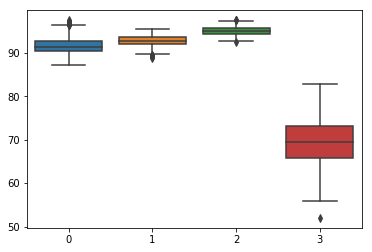

In [76]:

ax=sns.boxplot(data=tmpDf)


In [23]:
statDf.head()

,0,bin_0,1,bin_1,2,bin_2,3,bin_3
0e2c395e-ddda-4833-b1ee-31a9bd08a845,0.955058,5852.0,0.939833,19396.0,0.948601,23405.0,0.730303,330.0
1c53dd51-3c27-427a-ba71-25026be0a8c1,0.935908,7380.0,0.915063,19697.0,0.940955,17275.0,0.700893,224.0
3594993e-f65c-434b-a64e-b1873f4b04ca,0.943798,5071.0,0.938576,26081.0,0.935877,6971.0,0.706422,109.0
3d94bd04-c878-47a4-a48d-accd9e1525c1,0.928556,4647.0,0.933270,22179.0,0.950989,21179.0,0.680000,250.0
7e2a7c2c-7497-4a45-a264-6401f36ed11b,0.906208,5203.0,0.926600,23474.0,0.952677,17560.0,0.657895,228.0


In [66]:
#statDf.columns.str.contains('bin_').fillna(False).values

In [71]:
statDf.loc[:,statDf.columns.str.contains('bin_').fillna(False)==False].mean(axis=0).to_frame()

,0
0,0.918148
1,0.926855
2,0.950479
3,0.694513


In [27]:
binDf=statDf.loc[:,statDf.columns.str.contains('bin_').fillna(False)]

In [40]:
%matplotlib inline

In [50]:
(binDf['bin_3']/binDf.sum(axis=1)).mean()

0.004550527480049814

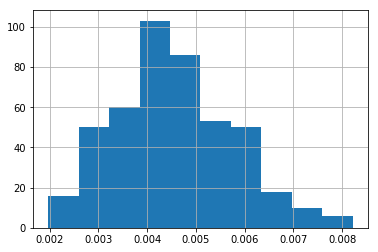

In [41]:
(binDf['bin_3']/binDf.sum(axis=1)).hist()

In [10]:

corrS=pd.Series(corrDict)

In [11]:
import seaborn as sns
%matplotlib inline

In [12]:
tmpMergedDf=(mergedDf)

In [13]:
from scipy import stats

In [14]:
cutoff=10
tmpSubDf=tmpMergedDf[tmpMergedDf.mean(axis=1)<=cutoff]
stats.linregress(tmpSubDf['wo'],tmpSubDf['w'])

LinregressResult(slope=0.8124150465504625, intercept=0.39307502558241225, rvalue=0.9832889959859111, pvalue=0.0, stderr=0.00030880301708599757)

In [3]:
ProcessedRunDigits[0]

'0e2c395e-ddda-4833-b1ee-31a9bd08a845'

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


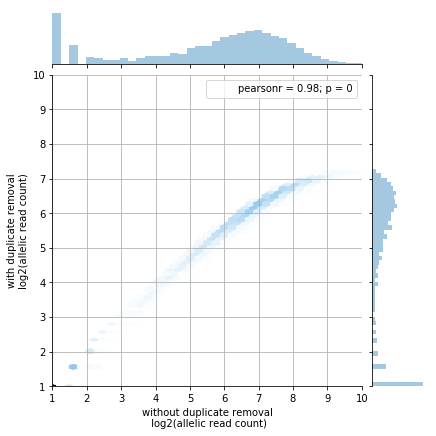

In [16]:
g=sns.jointplot(data=tmpSubDf,x='wo',y='w',kind='hex',xlim=[1,cutoff],ylim=[1,cutoff])
g.set_axis_labels(xlabel='without duplicate removal\n log2(allelic read count)',ylabel='with duplicate removal\nlog2(allelic read count)')
#g.ax_joint.axhline(6)
g.ax_joint.grid(True)
#g.ax_joint.axvline(6)

In [17]:
#woDupRemoved_inDf_tmp

In [18]:
woDupRemoved_inDf_DepthS=(woDupRemoved_inDf_tmp.groupby(['Chr','Pos']).sum())
wDupRemoved_inDf_DepthS=wDupRemoved_inDf_tmp.groupby(['Chr','Pos']).sum()

#wDupRemoved_inDf_DepthS

tmpI=woDupRemoved_inDf_tmp.index.to_frame().set_index(['Chr','Pos']).index

woDupRemoved_inDf_DepthS_algned=woDupRemoved_inDf_DepthS[tmpI]

tmpI=wDupRemoved_inDf_tmp.index.to_frame().set_index(['Chr','Pos']).index

wDupRemoved_inDf_DepthS_algned=wDupRemoved_inDf_DepthS[tmpI]

woDupRemoved_inDf_AllelicFreqS=woDupRemoved_inDf_tmp/woDupRemoved_inDf_DepthS_algned.values
wDupRemoved_inDf_AllelicFreqS=wDupRemoved_inDf_tmp/wDupRemoved_inDf_DepthS_algned.values

%time allelicDf=pd.DataFrame({'woDupRemoved':woDupRemoved_inDf_AllelicFreqS,'wDupRemoved':wDupRemoved_inDf_AllelicFreqS}).dropna()

### load in dbSNP vcf

In [26]:
inVcfDir='/data/cellardata/users/btsui/dbsnp/Homo_sapiens/All_20170710.f1_byte2_not_00.vcf.gz' 
vcfDf=pd.read_csv(inVcfDir,sep='\t',header=None)
vcfDf.columns=['Chr','Pos','RsId','RefBase','AltBase','','','Annot']
vcfDf['Chr']=vcfDf['Chr'].astype(np.str)

allelicDfResetDf=allelicDf.reset_index()

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
refI=vcfDf.set_index(['Chr','Pos','RefBase']).index

In [29]:
ChrPosI=allelicDfResetDf.set_index(['Chr','Pos','base']).index

ref_m=ChrPosI.isin(refI)

allelicDfResetDf['is_ref']=ref_m

bins = np.linspace(0, 1, 11)


allelicDfResetDf['wDupRemoved_bin']=np.digitize(allelicDfResetDf['wDupRemoved'],bins)

(allelicDfResetDf['woDupRemoved']-allelicDfResetDf['wDupRemoved']).abs()

allelicDfResetDf['abs_diff']=(allelicDfResetDf['woDupRemoved']-allelicDfResetDf['wDupRemoved']).abs()

In [76]:
woDupRemoved_inDf_DepthS_algned.head()

Chr  Pos   
1    14727     700
     14727     700
     630825      7
     630833      5
     850609      1
Name: ReadDepth, dtype: uint16

In [78]:
allelicDfResetDf['woDupRemoved_inDf_DepthS']=woDupRemoved_inDf_DepthS[ChrPosI].values

In [87]:
allelicDfResetDf['woDupRemoved_inDf_DepthS_log10']=np.log10(allelicDfResetDf['woDupRemoved_inDf_DepthS']+1)

binsize=1
allelicDfResetDf['woDupRemoved_inDf_DepthS_bin']=(allelicDfResetDf['woDupRemoved_inDf_DepthS_log10']/binsize).astype(int)*binsize

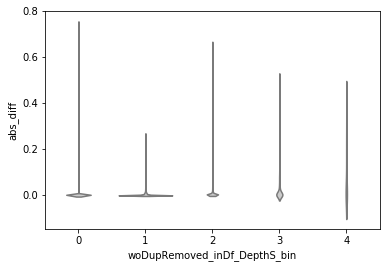

In [92]:
ax = sns.violinplot(data=allelicDfResetDf,x="woDupRemoved_inDf_DepthS_bin", y="abs_diff",
                     inner=None, color=".8")


In [99]:
allelicDfResetDf.head()

,Chr,Pos,base,woDupRemoved,wDupRemoved,is_ref,wDupRemoved_bin,abs_diff,woDupRemoved_inDf_DepthS,woDupRemoved_inDf_DepthS_bin,woDupRemoved_inDf_DepthS_log,woDupRemoved_inDf_DepthS_log10
0,1,14727,A,0.062857,0.085714,False,1,0.022857,700,2,2.845718,2.845718
1,1,14727,G,0.937143,0.914286,True,10,0.022857,700,2,2.845718,2.845718
2,1,630825,T,1.000000,1.000000,True,11,0.000000,7,0,0.903090,0.903090
3,1,630833,C,1.000000,1.000000,True,11,0.000000,5,0,0.778151,0.778151
4,1,850609,T,1.000000,1.000000,True,11,0.000000,1,0,0.301030,0.301030


In [108]:
allelicDfResetDf.head()

,Chr,Pos,base,woDupRemoved,wDupRemoved,is_ref,wDupRemoved_bin,abs_diff,woDupRemoved_inDf_DepthS,woDupRemoved_inDf_DepthS_bin,woDupRemoved_inDf_DepthS_log,woDupRemoved_inDf_DepthS_log10
0,1,14727,A,0.062857,0.085714,False,1,0.022857,700,2,2.845718,2.845718
1,1,14727,G,0.937143,0.914286,True,10,0.022857,700,2,2.845718,2.845718
2,1,630825,T,1.000000,1.000000,True,11,0.000000,7,0,0.903090,0.903090
3,1,630833,C,1.000000,1.000000,True,11,0.000000,5,0,0.778151,0.778151
4,1,850609,T,1.000000,1.000000,True,11,0.000000,1,0,0.301030,0.301030


In [124]:
import matplotlib.pyplot as plt

array([0, 1, 2, 3])

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


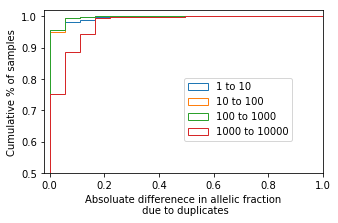

In [162]:
myBin=2
n_bins=20
fig, ax = plt.subplots(figsize=(5, 3))
# plot the cumulative histogram
# "xx to xx read "
for myBin in np.arange(0,4):
    x=allelicDfResetDf['abs_diff'][(allelicDfResetDf['woDupRemoved_inDf_DepthS_bin']==myBin)&(~allelicDfResetDf.is_ref)]#.sample(1000)
    n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                               cumulative=True, label='{} to {}'.format(10**(myBin),10**(myBin+1)),range=[0,1.1])
ax.set_xlim([-0.02,1.0])
ax.set_ylim([0.5,1.02])
ax.set_ylabel('Cumulative % of samples')
ax.set_xlabel('Absoluate differenece in allelic fraction\n due to duplicates')
ax.legend(loc=(0.5,0.2))

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Absoluate differenece in allelic fraction due to duplicates')

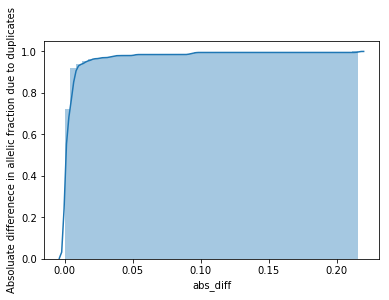

In [121]:
#x, 0 to 1
ax=sns.distplot(allelicDfResetDf['abs_diff'][allelicDfResetDf['woDupRemoved_inDf_DepthS_bin']==2].sample(200),
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
               )

ax.set_ylabel('Cumulative % of samples')
ax.set_ylabel('Absoluate differenece in allelic fraction due to duplicates')

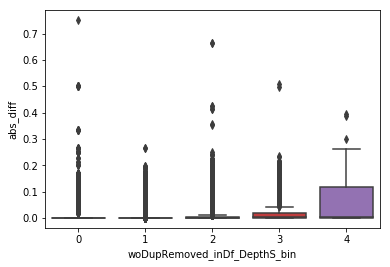

In [94]:
sns.boxplot(data=allelicDfResetDf,x='woDupRemoved_inDf_DepthS_bin',y='abs_diff')

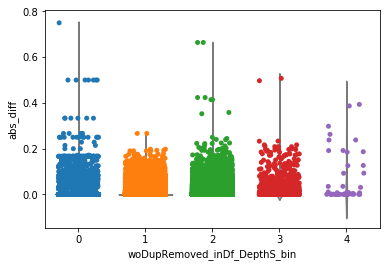

In [91]:
##
sns.stripplot(data=allelicDfResetDf,x='woDupRemoved_inDf_DepthS_bin',y='abs_diff',jitter=0.3)

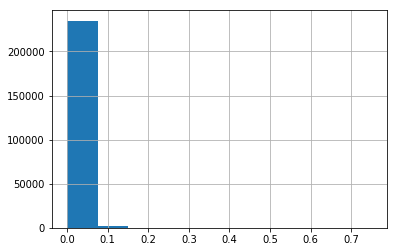

In [68]:
ax=.hist()

In [64]:
allelicDfResetDf.head()

,Chr,Pos,base,woDupRemoved,wDupRemoved,is_ref,wDupRemoved_bin
0,1,14727,A,0.062857,0.085714,False,1
1,1,14727,G,0.937143,0.914286,True,10
2,1,630825,T,1.000000,1.000000,True,11
3,1,630833,C,1.000000,1.000000,True,11
4,1,850609,T,1.000000,1.000000,True,11


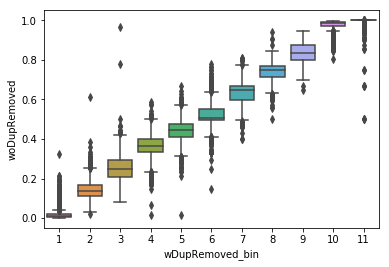

In [65]:
sns.boxplot(data=allelicDfResetDf[~allelicDfResetDf.is_ref],x='wDupRemoved_bin',y='woDupRemoved')

In [47]:
np.digitize(allelicDfResetDf['wDupRemoved'],bins=10)

ValueError: object of too small depth for desired array

In [48]:
#allelicDfResetDf['wDupRemoved']

/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/cellar/users/btsui/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


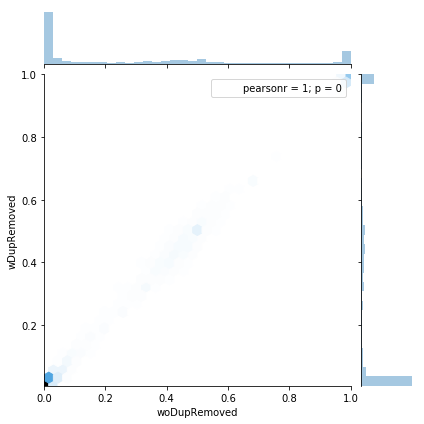

In [39]:
sns.jointplot(data=allelicDfResetDf[(~allelicDfResetDf['is_ref'])&(allelicDfResetDf['woDupRemoved']>0)&(allelicDfResetDf['woDupRemoved']<1.0)],x='woDupRemoved',y='wDupRemoved',kind='hex')

In [137]:
### variant allele only
sns.jointplot(data=allelicDf,x='woDup',y='wDup')

woDup      wDup
Chr Pos      base                    
1   14727    A     0.062857  0.085714
             G     0.937143  0.914286
    630825   T     1.000000  1.000000
    630833   C     1.000000  1.000000
    850609   T     1.000000  1.000000
    948136   G     1.000000  1.000000
    955964   G     1.000000  1.000000
    970788   G     1.000000  1.000000
    1013541  C     0.581967  0.510204
             T     0.409836  0.489796
    1014143  C     1.000000  1.000000
    1014228  G     1.000000  1.000000
    1014316  C     0.997067  1.000000
    1014359  G     1.000000  1.000000
    1020217  G     1.000000  1.000000
    1020221  C     1.000000  1.000000
    1020239  G     1.000000  1.000000
    1022188  A     1.000000  1.000000
    1022225  A     0.007092  0.008929
             G     0.992908  0.991071
    1022260  C     0.997783  1.000000
    1022313  A     0.993318  1.000000
    1040679  C     1.000000  1.000000
    1041174  C     1.000000  1.000000
    1041183  C     1.000000  1.000000
    1041218  A     0.066667  0.076923
             C     0.933333  0.923077
    1041249  C     1.000000  1.000000
    1041582  C     1.000000  1.000000
    1041583  A     0.987013  1.000000
...                     ...       ...
Y   26420477 G     0.888889  0.904762
    26508094 A     0.750000  0.750000
             G     0.250000  0.250000
    26509986 C     1.000000  1.000000
    26510310 G     1.000000  1.000000
    26510337 A     1.000000  1.000000
    26510425 G     1.000000  1.000000
    26515535 A     0.181818  0.181818
             G     0.818182  0.818182
    26515550 C     0.833333  0.833333
             T     0.166667  0.166667
    26515553 A     0.833333  0.833333
             G     0.166667  0.166667
    26515558 A     0.866667  0.857143
             C     0.133333  0.142857
    26530858 G     1.000000  1.000000
    26530883 A     1.000000  1.000000
    26530902 C     1.000000  1.000000
    26541498 C     1.000000  1.000000
    26541512 A     1.000000  1.000000
    26543653 C     1.000000  1.000000
    26554088 A     1.000000  1.000000
    26557077 C     0.053763  0.013158
             T     0.946237  0.986842
    26557102 C     0.747664  0.769231
             T     0.252336  0.230769
    26566504 G     1.000000  1.000000
    26567812 C     1.000000  1.000000
    26567857 C     1.000000  1.000000
    26568527 C     1.000000  1.000000

[237318 rows x 2 columns]

In [133]:
allelicDf.corr()

,wo_allele,w
wo_allele,1.00000,0.99838
w,0.99838,1.00000


In [118]:
tmpDf2=pd.DataFrame({'wo_alle':woDupRemoved_inDf_tmp,'wo_allel_site_depth':woDupRemoved_inDf_DepthS_algned,
                  'w':wDupRemoved_inDf_tmp})

ValueError: operands could not be broadcast together with shapes (447902,2) (3,) (447902,2) 

In [ ]:
%time allelicFracDf=tmpDf2.groupby(['Chr','Pos']).sum(axis=0)

In [ ]:
allelicFracDf